# Laboratorio 1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/andonyns/air-quality/blob/main/main.ipynb)

# 1. Generalidades

A continuación se hace un análisis exploratorio de los datos de [OpenAQ](https://openaq.org/), con el fin de obtener conclusiones y recomendaciones respecto a la contaminación del aire en 6 países, para 6 parámetros de contaminación en específico.



# 2. Preparar el ambiente y las utilidades

## 2.a Instalar dependencias en google colab

In [ ]:
%pip install -q python-dotenv matplotlib numpy pandas requests seaborn cartopy statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 108.0 MB/s eta 0:00:00


## 2.b ¿Ejecutando localmente? Instala las dependencias con uv.

Clona el repositorio [https://github.com/andonyns/air-quality/tree/main](https://github.com/andonyns/air-quality/tree/main) y luego, dentro del directorio, ejecuta el siguiente comando:
```bash
pip install uv
```
Luego ejecuta el siguiente comando:
```bash
uv sync
```
Después, abre el cuaderno en Visual Studio Code o Jupyter Notebook y selecciona como kernel el entorno virtual creado por uv dentro del directorio actual.

# 2.c Importar bibliotecas

In [ ]:
# For API requests
import requests
from urllib.parse import urljoin

# For env
import os
from dotenv import load_dotenv

try:
    import google.colab
    from google.colab import userdata

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# For data manipulation
from pprint import pprint
import pandas as pd
import pickle as pkl
import numpy as np
import statsmodels.api as sm

import time
import logging
import sys

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.lines as mlines

## 2.d Funciones de ayuda

In [ ]:
def set_color(text: str, color: str = "green") -> str:
    """Set the color of the text using ANSI escape codes.

    Parameters
    ----------
    text : str
        The text to be colored.
    color : str, optional
        The color to apply to the text. Available options are:
        'green', 'yellow', 'red', 'blue', and 'orange'.
        Default is 'green'.

    Returns
    -------
    str
        The text with the specified ANSI color codes applied.
    """
    colors: dict[str, str] = {
        "green": "\033[32m",
        "yellow": "\033[33m",
        "red": "\033[31m",
        "blue": "\033[34m",
        "orange": "\033[38;5;214m",
        "reset": "\033[0m",
    }
    return f"{colors[color]}{text}{colors['reset']}"


class StdOutLogger:
    """A custom logger that outputs to stdout with colored messages."""

    def __init__(self) -> None:
        """Initialize the StdOutLogger."""
        self.logger = logging.getLogger("Logger")
        self.logger.setLevel(logging.INFO)

        # Avoid duplicate handlers
        if not self.logger.hasHandlers():
            handler = logging.StreamHandler(sys.stdout)
            handler.setLevel(logging.INFO)
            formatter = logging.Formatter(
                "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                datefmt="%Y-%m-%d %H:%M:%S",
            )
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

    def info(self, message: str) -> None:
        """Log an info-level message.

        Parameters
        ----------
        message : str
            The message to log.
        """
        self.logger.info(message)

    def highlight(self, message: str) -> None:
        """Log a highlighted message in blue.

        Parameters
        ----------
        message : str
            The message to log.
        """
        self.logger.info(set_color(message, "blue"))

    def success(self, message: str) -> None:
        """Log an info-level success message in green.

        Parameters
        ----------
        message : str
            The success message to log.
        """
        self.logger.info(set_color(message, "green"))

    def warning(self, message: str) -> None:
        """Log a warning-level message in orange.

        Parameters
        ----------
        message : str
            The warning message to log.
        """
        self.logger.warning(set_color(message, "orange"))

    def critical(self, message: str) -> None:
        """Log a critical-level message in red.

        Parameters
        ----------
        message : str
            The critical message to log.
        """
        self.logger.critical(set_color(message, "red"))

    def error(self, message: str) -> None:
        """Log a error-level message in red.

        Parameters
        ----------
        message : str
            The critical message to log.
        """
        self.logger.critical(set_color(message, "red"))

Instanciamos un logger y cargamos las variables de ambiente para obtener API_KEY.

In [ ]:
logger = StdOutLogger()
load_dotenv()

False

## 2.e Constantes

In [ ]:
DATA_DIR = "data"
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

BASE_API_URL = "https://api.openaq.org/v3/"

if IN_COLAB:
    HEADERS = {"X-API-Key": userdata.get("API_KEY")}
else:
    HEADERS = {"X-API-Key": os.getenv("API_KEY")}

LOCATIONS_ENDPOINT = urljoin(BASE_API_URL, "locations/{location_id}")
MEASUREMENTS_ENDPOINT = urljoin(BASE_API_URL, "sensors/{sensor_id}/measurements")

## 2.f Cliente básico para obtener datos de OpenAQ

Ahora, creamos un cliente básico de OpenA! que haga las solicitudes a los endpoints correspondientes, y obtenga los datos para las localizaciones.

In [ ]:
class OpenAQClient:
    """A static client for interacting with the OpenAQ API."""

    _base_url: str = BASE_API_URL
    _headers: dict = {"X-API-Key": os.getenv("API_KEY")}
    _logger: logging.Logger = logger

    @staticmethod
    def set_config(
        base_api_url: str = BASE_API_URL,
        api_key: str | None = None,
        logger: logging.Logger | None = None,
    ) -> None:
        """Configure the OpenAQClient.

        This method sets the base URL, API key, and logger for all
        subsequent requests.  It's a class method, so it's called on
        the class itself (e.g., OpenAQClient.set_config(...)).

        Parameters
        ----------
        base_api_url : str, optional
            The base URL for the OpenAQ API.  Default is the module-level
            BASE_API_URL.
        api_key : str, optional
            The API key for OpenAQ. If None, it will try to get it from
            the environment variable "API_KEY". Default is None.
        logger : logging.Logger, optional
            The logger to use.  Default is the module-level logger.
        """
        OpenAQClient._base_url = base_api_url
        OpenAQClient._headers = {
            "X-API-Key": api_key or os.getenv("API_KEY") or userdata.get("API_KEY")
        }
        OpenAQClient._logger = logger or logging.getLogger(__name__)

    @staticmethod
    def _fetch_data(
        endpoint: str,
        parameters: dict | None = None,
        query_parameters: dict | None = None,
        verbose: bool = False,
    ) -> requests.Response:
        """Fetch data from a given API endpoint.

        This is a static method, so it's called on the class
        (e.g., OpenAQClient._fetch_data(...)).

        Parameters
        ----------
        endpoint : str
            The specific endpoint URL (relative to the base URL).
        parameters : dict of str to any, optional
            Path parameters to format the endpoint URL.
        query_parameters : dict of str to any, optional
            Query parameters to append to the URL.
        verbose : bool, optional
            If True, print the response headers.

        Returns
        -------
        requests.Response
            The raw requests.Response object.

        Raises
        ------
        Exception
            If the HTTP request returns a status code other than 200.
        """
        url = urljoin(OpenAQClient._base_url, endpoint)

        if parameters:
            url = url.format(**parameters)

        if query_parameters:
            url += "?" + "&".join(f"{k}={v}" for k, v in query_parameters.items())

        response = requests.get(url=url, headers=OpenAQClient._headers)

        if response.status_code != 200:
            raise Exception(
                f"Request failed with status: {response.status_code}. Reason: {response.text}"
            )

        if verbose:
            OpenAQClient._logger.info(response.headers)

        return response

    @staticmethod
    def fetch_location_sensors_data(
        location_id: int,
        locations_endpoint: str = "locations/{location_id}",
        measures_endpoint: str = "sensors/{sensor_id}/measurements",
    ) -> dict:
        """Fetch sensor data for a specific location.

        This is a static method, so it's called on the class.

        Parameters
        ----------
        location_id : int
            The ID of the location.

        Returns
        -------
        dict
            A dictionary where keys are sensor IDs and values are lists of
            measurement data pages.
        """
        OpenAQClient._logger.info(f"Fetching data for location ID: {location_id}...")
        rate_limit_remaining = None
        rate_limit_reset = None

        try:
            if rate_limit_remaining == "1" and rate_limit_reset is not None:
                OpenAQClient._logger.warning(
                    f"Reached rate limit for location {location_id}. Waiting for {rate_limit_reset} seconds."
                )
                time.sleep(int(rate_limit_reset))

            location_response = OpenAQClient._fetch_data(
                endpoint=locations_endpoint, parameters={"location_id": location_id}
            )
            location_data = location_response.json()
            OpenAQClient._logger.success(
                f"Finished fetching location data for ID: {location_id}"
            )
        except Exception as e:
            OpenAQClient._logger.critical(
                f"Error fetching location data for ID {location_id}: {e}"
            )
            return {}

        sensors_data: dict = {}
        sensors = location_data["results"][0].get("sensors", [])

        for i, sensor in enumerate(sensors):
            sensor_id = sensor["id"]
            sensors_data[sensor_id] = []
            query_params: dict = {"limit": 1000, "page": 1}
            OpenAQClient._logger.info(
                f"Processing sensor ID: {sensor_id} (sensor {i + 1}/{len(sensors)})"
            )

            while True:
                try:
                    measurements_response = OpenAQClient._fetch_data(
                        endpoint=measures_endpoint,
                        parameters={"sensor_id": sensor_id},
                        query_parameters=query_params,
                    )
                    measurements_data = measurements_response.json()
                    OpenAQClient._logger.info(
                        f"Processing sensor ID {sensor_id}, page {measurements_data['meta']['page']}"
                    )
                    OpenAQClient._logger.warning(
                        f"Remaining requests: {measurements_response.headers.get('X-Ratelimit-Remaining', 'N/A')}"
                    )
                    sensors_data[sensor_id].append(measurements_data)

                    rate_limit_remaining = measurements_response.headers.get(
                        "X-Ratelimit-Remaining"
                    )
                    rate_limit_reset = measurements_response.headers.get(
                        "X-Ratelimit-Reset"
                    )
                    if rate_limit_remaining == "1" and rate_limit_reset is not None:
                        OpenAQClient._logger.warning(
                            f"Reached rate limit for sensor {sensor_id}. Waiting for {rate_limit_reset} seconds."
                        )
                        time.sleep(int(rate_limit_reset))
                    if len(measurements_data["results"]) < 1000:
                        break

                    query_params["page"] += 1
                except Exception as e:
                    OpenAQClient._logger.error(
                        f"Error fetching measurements for sensor ID {sensor_id}: {e}"
                    )
                    break

            OpenAQClient._logger.success(f"Finished processing sensor ID: {sensor_id}")

        OpenAQClient._logger.success(
            f"Finished processing all sensors for location ID: {location_id}"
        )
        return sensors_data

Establecemos una configuración inicial para el cliente:

In [ ]:
OpenAQClient.set_config(
    base_api_url=BASE_API_URL,
    api_key=os.getenv("API_KEY"),
    logger=logger,
)

### Ejemplo de CR

Podemos obtener los datos de una localización llamando a la función y accediendo al endpoint de las localizaciones. De antemano, se buscó el ID de la localización existente en [Explore the data](https://explore.openaq.org/#1.2/20/40). Así se usa esto como parámetro para obtener la información de la localización.

In [ ]:
# Costa Rica example
cr_location_id = 3070644

cr_location_data = OpenAQClient._fetch_data(
    endpoint=LOCATIONS_ENDPOINT,
    parameters={"location_id": cr_location_id},
).json()
pprint(cr_location_data)

{'meta': {'found': 1,
          'limit': 100,
          'name': 'openaq-api',
          'page': 1,
          'website': '/'},
 'results': [{'bounds': [-84.0417, 9.938, -84.0417, 9.938],
              'coordinates': {'latitude': 9.938, 'longitude': -84.0417},
              'country': {'code': 'CR', 'id': 29, 'name': 'Costa Rica'},
              'datetimeFirst': {'local': '2024-09-19T14:01:34-06:00',
                                'utc': '2024-09-19T20:01:34Z'},
              'datetimeLast': {'local': '2025-04-28T17:02:59-06:00',
                               'utc': '2025-04-28T23:02:59Z'},
              'distance': None,
              'id': 3070644,
              'instruments': [{'id': 4, 'name': 'Clarity Sensor'}],
              'isMobile': False,
              'isMonitor': False,
              'licenses': [{'attribution': {'name': 'Clarity', 'url': None},
                            'dateFrom': '2021-10-20',
                            'dateTo': None,
                            'id

Específicamente, este endpoint extrae, entre otras cosas, la información de los sensores que toman datos allí. Con esta información es posible obtener la información de los datos que han medido los sensores a través del tiempo.

En este caso, y a modo de ejemplo, vamos a obtener la información del primer sensor de Costa Rica.

In [ ]:
# Get the first sensor
sensor = cr_location_data["results"][0]["sensors"][0]
not_finished = True
query_params = {"limit": 1000, "page": 1}

while not_finished:
    sensor_id = sensor["id"]
    sensor_data = OpenAQClient._fetch_data(
        endpoint=MEASUREMENTS_ENDPOINT,
        parameters={"sensor_id": sensor_id},
        query_parameters=query_params,
    ).json()
    if len(sensor_data["results"]) < 1000:
        print(f"last page: {sensor_data['meta']['page']}")
        not_finished = False

    else:
        query_params["page"] += 1

print(f"Total pages: {query_params['page']}")

Agrupando las mediciones por día, se obtiene una granularidad decente para el análisis de los datos, pues muchos países no tiene una única página de datos como Costa Rica, si no que tiene muchísimas páginas más.

Vamos a hacer una función para obtener la información de todas las páginas de medidas que arroja el endpoint.

### Obtención de datos de todas las localizaciones

Por comodidad, también podemos hacer una clase localización, que guarde datos básicos de ella y además los datos de sus sensores.

In [ ]:
class Location:
    def __init__(
        self,
        country: str,
        name: str,
        id: int,
        sensors_data: dict = None,
    ) -> None:
        self.country: str = country
        self.name: str = name
        self.id: int = id
        self.sensors_data: dict = sensors_data
        self.coordinates: tuple[float, float] = None
        self.file_path: str = f"{DATA_DIR}/{country}_{name}/{country}_{name}"

    def pull_location_data(self):
        location_data = OpenAQClient._fetch_data(
            endpoint="locations/{location_id}",
            parameters={"location_id": location.id},
        ).json()

        self.coordinates = location_data["results"][0]["coordinates"]

    def pull_sensors_data(self, grouped_by: str = None) -> None:
        if grouped_by is None:
            self.sensors_data = OpenAQClient.fetch_location_sensors_data(self.id)
        else:
            self.sensors_data = OpenAQClient.fetch_location_sensors_data(
                self.id,
                measures_endpoint="sensors/{sensor_id}/measurements/" + grouped_by,
            )

    @staticmethod
    def save(location: "Location") -> None:
        if not os.path.isdir(DATA_DIR + f"/{location.country}_{location.name}"):
            os.mkdir(DATA_DIR + f"/{location.country}_{location.name}")

        with open(f"{location.file_path}.pkl", "wb") as f:
            pkl.dump(location, f)

    @staticmethod
    def load(location: "Location") -> "Location":
        with open(f"{location.file_path}.pkl", "rb") as f:
            location = pkl.load(f)

        return location

Los países y localizaciones seleccionados para el análisis son los siguientes:

In [ ]:
locations = [
    Location(
        country="Costa Rica",
        name="San José, San Pedro, Montes de Oca",
        id=3070644,
    ),
    Location(country="China", name="Hong Kong, North", id=233335),
    Location(country="Italia", name="Marche, Genga -Parco Gola della Rossa", id=8232),
    Location(country="España", name="Madrid, Villa del Prado", id=2162432),
    Location(
        country="India",
        name="Mahape, Navi Mumbai",
        id=6943,
    ),
    Location(
        country="Perú",
        name="Ayacucho, Pariachi",
        id=2143681,
    ),
]

Además, se quieren medir estos parámetros, que son mencionados por documentos oficiales de la [EPA](https://www.epa.gov/). Las definiciones fueron tomadas de la [Ley de Aire Limpio](https://www.epa.gov/criteria-air-pollutants/information-pollutant):

1. PM (Partículas Materiales): Estas partículas vienen en muchos tamaños y formas y pueden estar compuestas de cientos de químicos diferentes. Algunas se emiten directamente de una fuente, como sitios de construcción, caminos sin pavimentar, campos, chimeneas o incendios. La mayoría de las partículas se forman en la atmósfera como resultado de reacciones complejas de químicos como el dióxido de azufre y los óxidos de nitrógeno, que son contaminantes emitidos por plantas de energía, industrias y automóviles.

   - PM₂.₅ (Partículas Materiales de 2.5 micrómetros o más pequeñas):
     partículas inhalables finas, con diámetros que generalmente son de 2.5 micrómetros o más pequeños.

   - PM₁₀ (Partículas Materiales de 10 micrómetros o más pequeñas):
     partículas inhalables, con diámetros que generalmente son de 10 micrómetros o más pequeños.

2. O₃ (Ozono):
   El ozono troposférico, o a nivel del suelo, no se emite directamente al aire, sino que se crea por reacciones químicas entre los óxidos de nitrógeno (NOx) y los compuestos orgánicos volátiles (COV). Esto sucede cuando los contaminantes emitidos por automóviles, plantas de energía, calderas industriales, refinerías, plantas químicas y otras fuentes reaccionan químicamente en presencia de la luz solar.

3. NO₂ (Dióxido de Nitrógeno):
   El dióxido de nitrógeno (NO₂) es uno de un grupo de gases altamente reactivos conocidos como óxidos de nitrógeno (NOx). Otros óxidos de nitrógeno incluyen el ácido nitroso y el ácido nítrico. El NO₂ se utiliza como indicador del grupo más grande de óxidos de nitrógeno. El NO₂ llega principalmente al aire por la quema de combustible. El NO₂ se forma a partir de las emisiones de automóviles, camiones y autobuses, plantas de energía y equipos todoterreno.

4. SO₂ (Dióxido de Azufre):
   El SO₂ es el componente de mayor preocupación y se utiliza como indicador del grupo más grande de óxidos de azufre gaseosos (SOx). Otros SOx gaseosos (como el SO₃) se encuentran en la atmósfera en concentraciones mucho más bajas que el SO₂. La mayor fuente de SO₂ en la atmósfera es la quema de combustibles fósiles por parte de las centrales eléctricas y otras instalaciones industriales. Las fuentes más pequeñas de emisiones de SO₂ incluyen: procesos industriales como la extracción de metal de los minerales; fuentes naturales como los volcanes; y locomotoras, barcos y otros vehículos y equipos pesados que queman combustible con un alto contenido de azufre.

5. CO (Monóxido de Carbono):
   El CO es un gas incoloro e inodoro que puede ser dañino cuando se inhala en grandes cantidades. El CO se libera cuando se quema algo. Las mayores fuentes de CO en el aire exterior son los automóviles, camiones y otros vehículos o maquinaria que queman combustibles fósiles. Una variedad de artículos en su hogar, como calentadores de ambiente de queroseno y gas sin ventilación, chimeneas y hornos con fugas, y estufas de gas también liberan CO y pueden afectar la calidad del aire en interiores.

In [ ]:
selected_parameters = [
    "pm25 µg/m³",
    "co µg/m³",
    "no2 µg/m³",
    "o3 µg/m³",
    "pm10 µg/m³",
    "so2 µg/m³",
]

Vamos a obtener los datos agrupados por día para cada localización. Sería posible obtener cada una de las mediciones individuales, sin embargo, el endpoint no está optimizado para que le soliciten tantas páginas. Mientras más alto es el número de página que se le solicita, más lenta va a ser la respuesta. El servidor finaliza la solicitud si tarda demasiado. Ejecute esta celda para ver el comportamiento descrito:

ADVERTENCIA: Esta celda dura demasiado ejecutando. Favor no ejecutar a menos que esté dispuesto a esperar para ver el error que lanza. Igualmente, puede inspeccionar la salida de la celda ya ejecutada a priori.

In [ ]:
# For every location, save all info
for location in locations:
    # No grouping
    location.pull_sensors_data(grouped_by=None)
    Location.save(location)

    del location.sensors_data

    logger.success(f"Saved data for location {location.name}")

Varios senores muestra errores al intentar conseguir los datos, pues las solicitudes tardaron demasiado. Por lo tanto, **se prefirió hacer las solicitudes agrupadas por día**, que todavía son suficientemente representativas.

In [ ]:
# For every location, save all info
for location in locations:
    # Set daily group
    location.pull_location_data()
    location.pull_sensors_data(grouped_by="daily")
    Location.save(location)

    del location.sensors_data

    logger.success(f"Saved data for location {location.name}")

INFO:Logger:Fetching data for location ID: 3070644...
INFO:Logger:Finished fetching location data for ID: 3070644
INFO:Logger:Processing sensor ID: 10669679 (sensor 1/1)
INFO:Logger:Processing sensor ID 10669679, page 1
INFO:Logger:Finished processing sensor ID: 10669679
INFO:Logger:Finished processing all sensors for location ID: 3070644
INFO:Logger:Saved data for location San José, San Pedro, Montes de Oca
INFO:Logger:Fetching data for location ID: 233335...
INFO:Logger:Finished fetching location data for ID: 233335
INFO:Logger:Processing sensor ID: 1342527 (sensor 1/6)
INFO:Logger:Processing sensor ID 1342527, page 1
INFO:Logger:Processing sensor ID 1342527, page 2
INFO:Logger:Finished processing sensor ID: 1342527
INFO:Logger:Processing sensor ID: 1342531 (sensor 2/6)
INFO:Logger:Processing sensor ID 1342531, page 1
INFO:Logger:Processing sensor ID 1342531, page 2
INFO:Logger:Finished processing sensor ID: 1342531
INFO:Logger:Processing sensor ID: 1342530 (sensor 3/6)
INFO:Logger:P

¡Listo! Ya obtuvimos los datos de cada localización y sensor.


# 3. Tareas de limpieza y transformación:

Se deben realizar las tareas de limpieza y transformación necesarias para poder hacer un comparativo de la evolución de los diferentes indicadores de la calidad del aire en Costa Rica y las otras ciudades.


Primero, vamos a cargar los datos recientemente obtenidos con el cliente de OpenAQ.

In [ ]:
# Load the data
locations = [Location.load(location) for location in locations]

## 3.a Paso a csv

Primero, vamos a eliminar los datos que no interesan y quedarnos con los que son relevantes para hacer análisis

In [ ]:
def location_to_pd(location_data: Location) -> pd.DataFrame:
    """Convert location measurement data into a pandas DataFrame.

    Extracts individual sensor measurements from the nested structure
    within a Location object (typically obtained from an API client like
    OpenAQClient) and organizes them into a flat DataFrame format.

    Parameters
    ----------
    location_data : Location
        An object representing a specific location. It is expected to have
        attributes: `id` (int), `name` (str), `country` (str), and
        `sensors_data` (dict). The `sensors_data` attribute should be a
        dictionary mapping sensor IDs to lists of page results. Each page
        is expected to be a dictionary containing a 'results' key, which
        maps to a list of individual measurement dictionaries.

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row represents a single measurement period
        for a specific sensor at the given location. Columns include:
        'location_id', 'location_name', 'sensor_id', 'from_date',
        'to_date', 'parameter_name', 'parameter_units', 'value',
        'aggregated_count', 'summary_avg', 'summary_max', 'summary_median',
        'summary_min', 'summary_q02', 'summary_q25', 'summary_q75',
        'summary_q98', 'summary_sd'.

    Notes
    -----
    Assumes the nested structure of `location_data.sensors_data` where
    measurements are contained within pages under the 'results' key.
    The structure typically originates from paginated API responses.

    """
    rows = []
    location_name = location_data.name
    country_name = location.country

    for sensor_id, sensor_pages in location_data.sensors_data.items():
        for page in sensor_pages:
            measurements = page.get("results", [])

            for measurement in measurements:
                period = measurement.get("period", {})
                datetime_from = period.get("datetimeFrom", {})
                datetime_to = period.get("datetimeTo", {})
                parameter = measurement.get("parameter", {})
                coverage = measurement.get("coverage", {})
                summary = measurement.get("summary", {})

                rows.append(
                    [
                        location_data.id,
                        country_name,
                        location_name,
                        sensor_id,
                        datetime_from.get("utc"),
                        datetime_to.get("utc"),
                        parameter.get("name") + " " + parameter.get("units"),
                        parameter.get("units"),
                        measurement.get("value"),
                        coverage.get("observedCount"),
                        summary.get("avg"),
                        summary.get("max"),
                        summary.get("median"),
                        summary.get("min"),
                        summary.get("q02"),
                        summary.get("q25"),
                        summary.get("q75"),
                        summary.get("q98"),
                        summary.get("sd"),
                    ]
                )

    columns = [
        "location_id",
        "country_name",
        "location_name",
        "sensor_id",
        "from_date",
        "to_date",
        "parameter_name",
        "parameter_units",
        "value",
        "aggregated_count",
        "summary_avg",
        "summary_max",
        "summary_median",
        "summary_min",
        "summary_q02",
        "summary_q25",
        "summary_q75",
        "summary_q98",
        "summary_sd",
    ]

    return pd.DataFrame(rows, columns=columns)

In [ ]:
for location in locations:
    df = location_to_pd(location)
    df.to_csv(f"{location.file_path}.csv", index=False)

In [ ]:
locations_dfs = [pd.read_csv(f"{location.file_path}.csv") for location in locations]
locations_dfs[0].replace(
    to_replace="NASA GSFC Rutgers Calib. N13",
    value="San José, San Pedro Montes de Oca",
    inplace=True,
)

## 3.b Descripción de los datos

Veamos si hay valores nulos en alguno de los data frames.

In [ ]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"DataFrame null values: {df.isnull().sum()}")

INFO:Logger:Location: Costa Rica San José, San Pedro, Montes de Oca
INFO:Logger:DataFrame null values: location_id         0
country_name        0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q98         0
summary_sd          0
dtype: int64
INFO:Logger:Location: China Hong Kong, North
INFO:Logger:DataFrame null values: location_id          0
country_name         0
location_name        0
sensor_id            0
from_date            0
to_date              0
parameter_name       0
parameter_units      0
value                0
aggregated_count     0
summary_avg          0
summary_max          0
summary_median       0
summary_min          0
summary_q02          0
summary_q25          0
summary_q75       

Aparentemente hay valores nulos en el campo de "sd". Estos son datos en donde el proceso de agregado solo tenía un elemento, por lo que no hay una desviación estándar para los datos de ese día. Esto no es preocupante, pero se deben cambiar estos datos a un 0.

In [ ]:
for df in locations_dfs:
    df["summary_sd"] = df["summary_sd"].replace({np.nan: 0})

Verifiquemos nuevamente la cantidad de nulos.

In [ ]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"DataFrame null values: \n{df.isnull().sum()}")

INFO:Logger:Location: Costa Rica San José, San Pedro, Montes de Oca
INFO:Logger:DataFrame null values: 
location_id         0
country_name        0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q98         0
summary_sd          0
dtype: int64
INFO:Logger:Location: China Hong Kong, North
INFO:Logger:DataFrame null values: 
location_id         0
country_name        0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q9

Hemos limpiado los datos y están listos para el análisis.

Además, seleccionamos únicamente los parámetros 'pm25 µg/m³', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³', 'so2 µg/m³', vamos a eliminar aquellos que no estén en la lista para cada localización.

In [ ]:
for idx, df in enumerate(locations_dfs):
    # Filtrar según los parámetros permitidos
    df = df[df["parameter_name"].isin(selected_parameters)]
    locations_dfs[idx] = df

In [ ]:
for df, location in zip(locations_dfs, locations):
    df.to_csv(f"{location.file_path}_cleaned.csv", index=False)

¡Listo! Los datos están preparados para el análisis.


# 4. Análisis y comparación:

Se debe realizar un análisis EDA que incluya análisis univariable y multivariable.

Analizar las tendencias de los indicadores para las diferentes ciudades y hacer comparaciones entre diferentes países y ciudades.

Incluir posibles correlaciones entre las variables y parámetros de calidad del aire de cada país/ciudad.

Utilizar diferentes tipos de visualizaciones relevantes para el análisis.



## 4.a Localizaciones

Primero, vamos a visualizar las localizaciones en el mapa para tener un mejor entendimiento de los lugares analizados.

In [ ]:
# Get a colormap
cmap = plt.get_cmap("Set2")

# Create a list of colors based on the number of locations
colors = [cmap(i / len(locations)) for i in range(len(locations))]

locations_color_map = {}
for i, location in enumerate(locations):
    locations_color_map[location.country] = colors[i]
locations[0].name = "San José, San Pedro Montes de Oca"

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


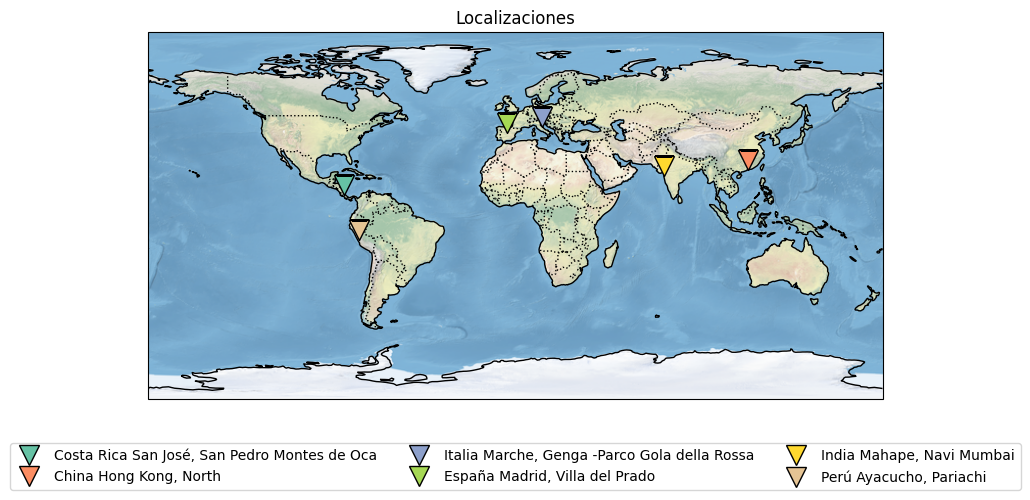

In [ ]:
# Setup the map
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})
ax.stock_img()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.coastlines()
# Plot each location on the map
for i, location in enumerate(locations):
    longitude = location.coordinates["longitude"]
    # We add a little offset to move the triangle tip to point
    latitude = location.coordinates["latitude"] + 5

    color = locations_color_map[location.country]

    ax.plot(
        longitude,
        latitude,
        label=location.country + " " + location.name,
        color=color,
        marker="v",
        markeredgewidth=1,
        markeredgecolor="black",
        markersize=15,
        linestyle="None",
        transform=ccrs.PlateCarree(),
    )

# Legend with colors
ax.legend(loc="upper center", fontsize=10, bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.title("Localizaciones")
plt.tight_layout()
plt.show()

## 4.b Análisis descriptivo

Veamos la cantidad de datos en cada localización. Si bien esto no es escencial para entender la naturaleza de los datos, es importante para interpretar algunos resultados. Mientras más datos a través de los años haya de cierta localización, es probable que haya más varianza, más valores atípicos, etc.

In [ ]:
data = []

for df, location in zip(locations_dfs, locations):
    data.append(
        {"Pais": location.country, "Localizacion": location.name, "Datos": df.shape[0]}
    )

data_df = pd.DataFrame(data)
data_df = data_df.sort_values(by="Datos", ascending=False)
data_df

Pais                           Localizacion  Datos
2      Italia  Marche, Genga -Parco Gola della Rossa   9050
1       China                       Hong Kong, North   7707
4       India                    Mahape, Navi Mumbai   5513
5        Perú                     Ayacucho, Pariachi   2292
3      España                Madrid, Villa del Prado   2018
0  Costa Rica      San José, San Pedro Montes de Oca    206

En este caso, Italia es la localización con más datos de todas, seguido por China y Mumbai. Perú y España están similares, pero Costa Rica tiene muy pocos datos. Veamos esto en un gráfico:

<Figure size 1000x800 with 0 Axes>

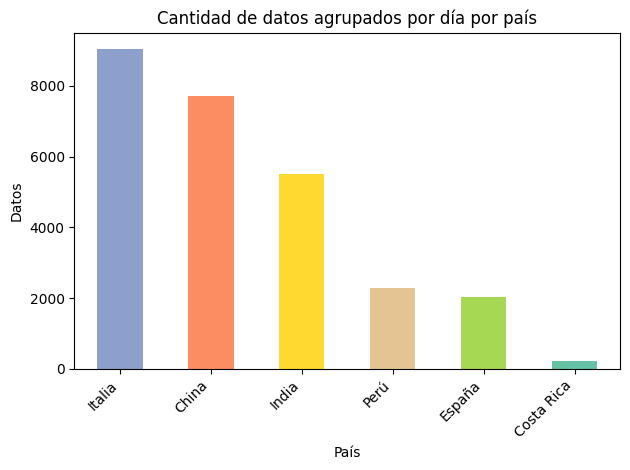

In [ ]:
ordered_colors = [locations_color_map[country] for country in data_df["Pais"].tolist()]

# Create the bar plot
plt.figure(figsize=(10, 8))
ax = data_df.plot(kind="bar", x="Pais", y="Datos", color=ordered_colors, legend=False)

# Rotate x-ticks
plt.xticks(rotation=45, ha="right")

plt.xlabel("País")
plt.ylabel("Datos")
plt.title("Cantidad de datos agrupados por día por país")

plt.tight_layout()
plt.show()

No obstante, hay que recordar que estos números son días completos y no mediciones individuales. Es decir, están agrupados por días. La cantidad real de datos recolectados en cada localización es la siguiente:

In [ ]:
data = []

for df, location in zip(locations_dfs, locations):
    data.append(
        {
            "Pais": location.country,
            "Localizacion": location.name,
            "Datos": df["aggregated_count"].sum(),
        }
    )

data_df = pd.DataFrame(data)
data_df = data_df.sort_values(by="Datos", ascending=False)
data_df

Pais                           Localizacion   Datos
4       India                    Mahape, Navi Mumbai  162700
1       China                       Hong Kong, North  161438
2      Italia  Marche, Genga -Parco Gola della Rossa  140900
5        Perú                     Ayacucho, Pariachi   51264
3      España                Madrid, Villa del Prado   29043
0  Costa Rica      San José, San Pedro Montes de Oca   12779

Acá sucede algo curioso, y es que Mumbai enrealidad es la localización con más datos, seguido de cerca con China. Al agrupar los datos por día se redujo el número de muestras para mumbai significativamente. Esto puede ser una indicación de que los datos de Mumbai enrealidad se acumulan en unos cuantos días, o que hubo algún periodo en el que no se tomaron muchas mediciones y otro en el que sí. Veamos esta información en un gráfico.

<Figure size 1000x800 with 0 Axes>

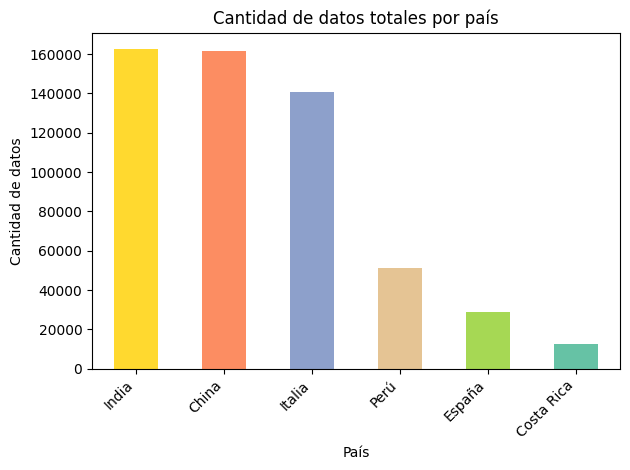

In [ ]:
ordered_colors = [locations_color_map[country] for country in data_df["Pais"].tolist()]

# Create the bar plot
plt.figure(figsize=(10, 8))
ax = data_df.plot(kind="bar", x="Pais", y="Datos", color=ordered_colors, legend=False)

# Rotate x-ticks
plt.xticks(rotation=45, ha="right")

plt.xlabel("País")
plt.ylabel("Cantidad de datos")
plt.title("Cantidad de datos totales por país")

plt.tight_layout()
plt.show()

De hecho, para comprobar la teoría de que Mumbai dejó de tomar mediciones en algún periodo, grafiquemos.

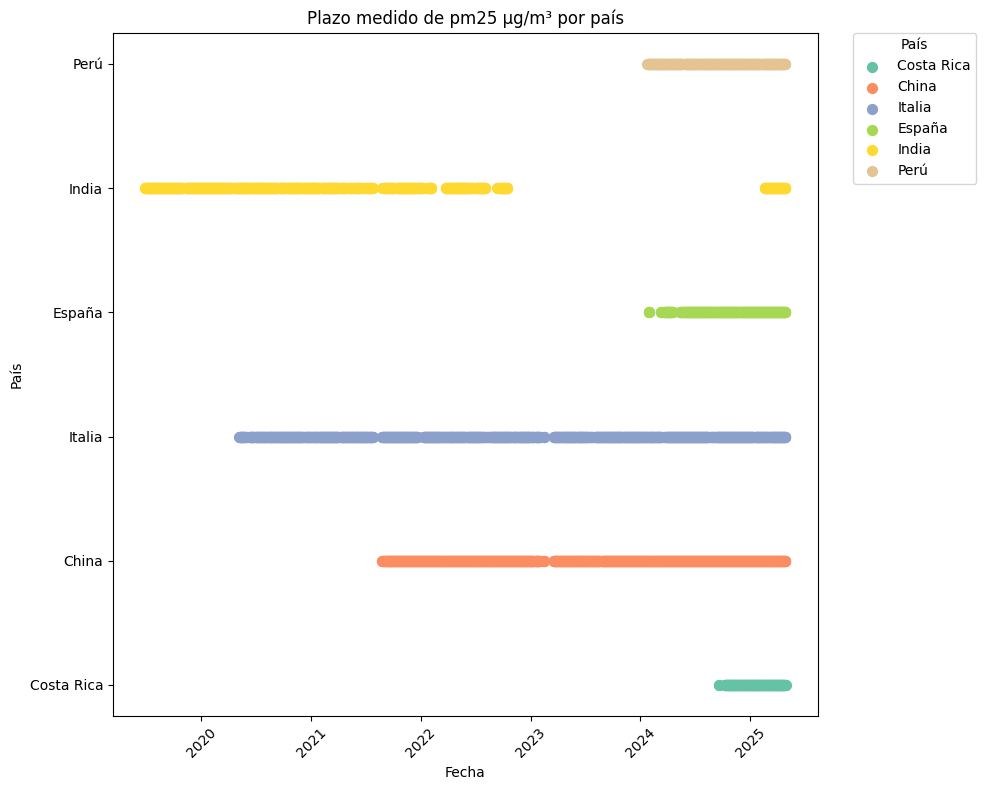

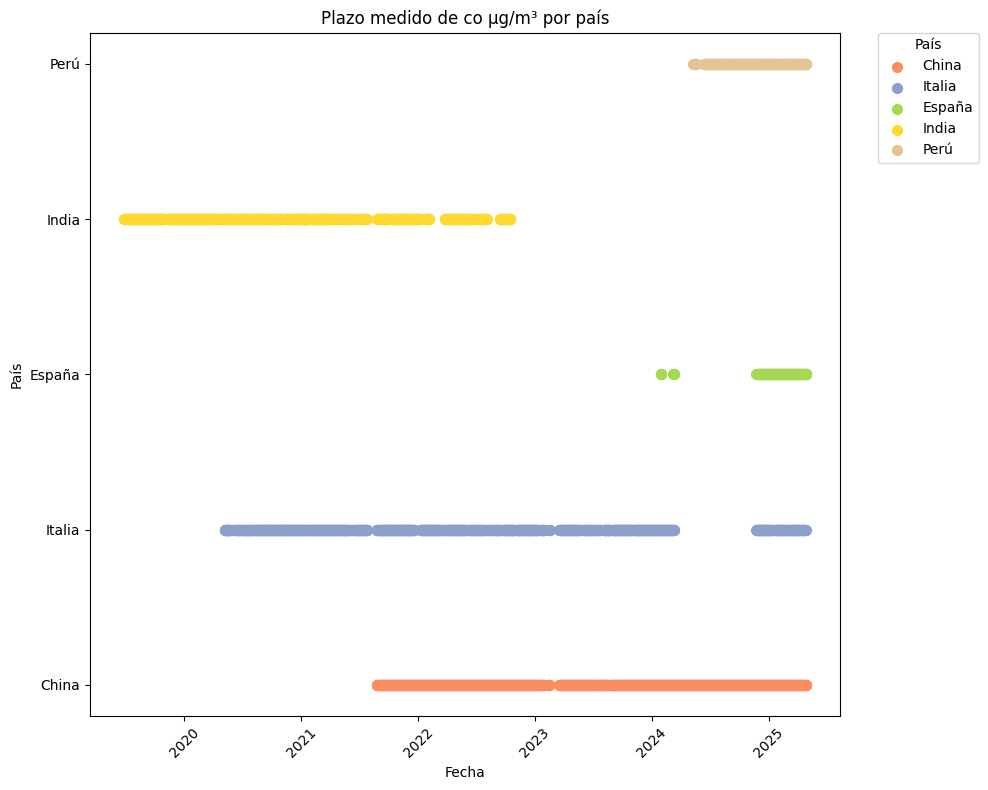

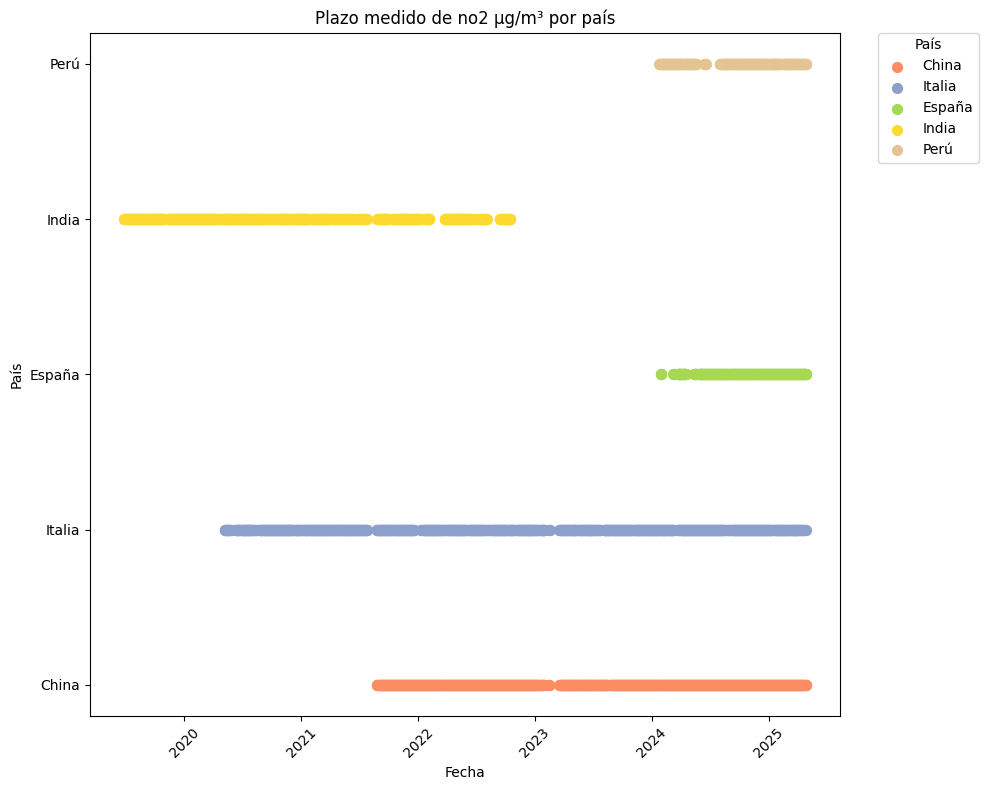

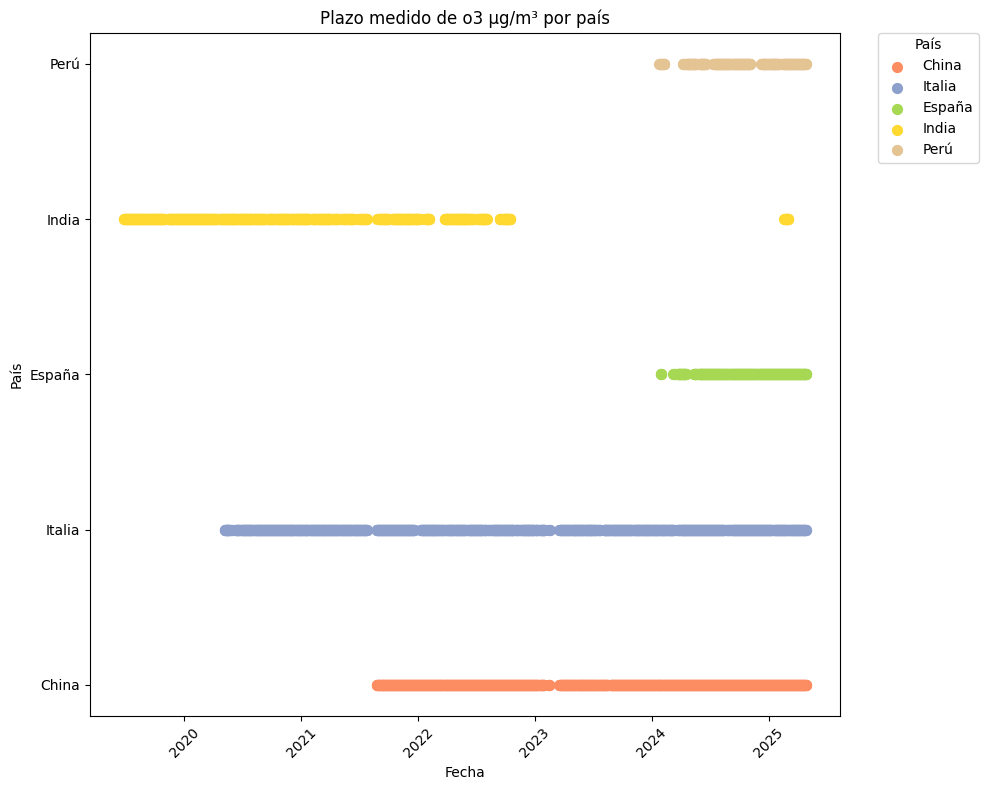

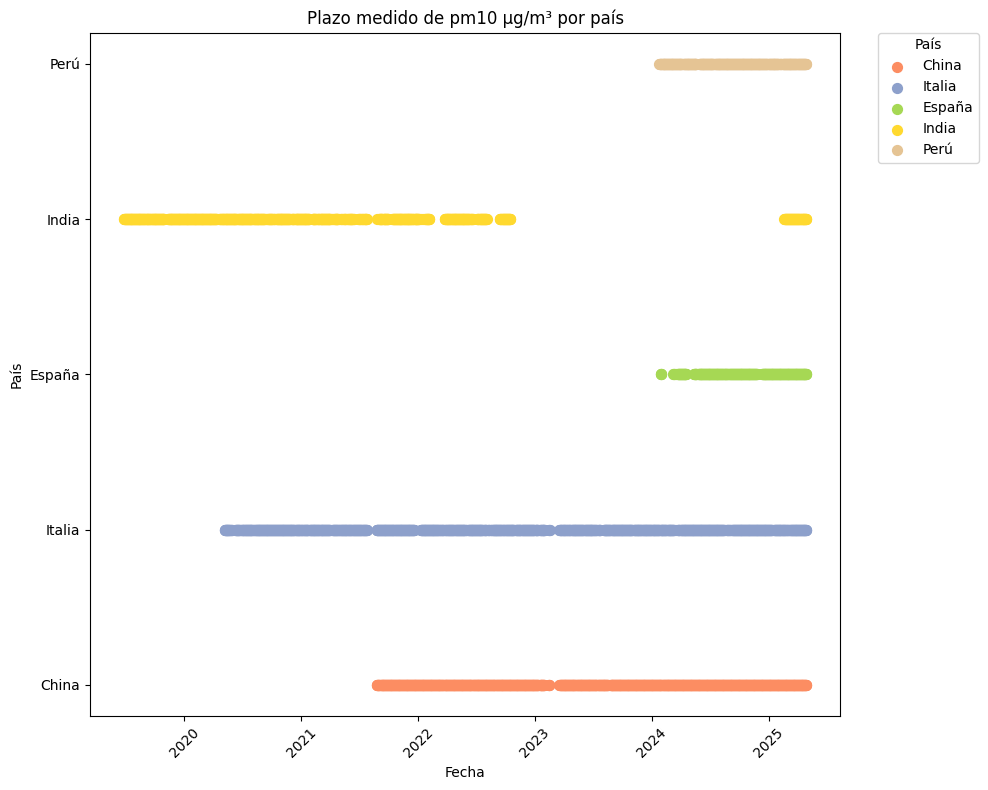

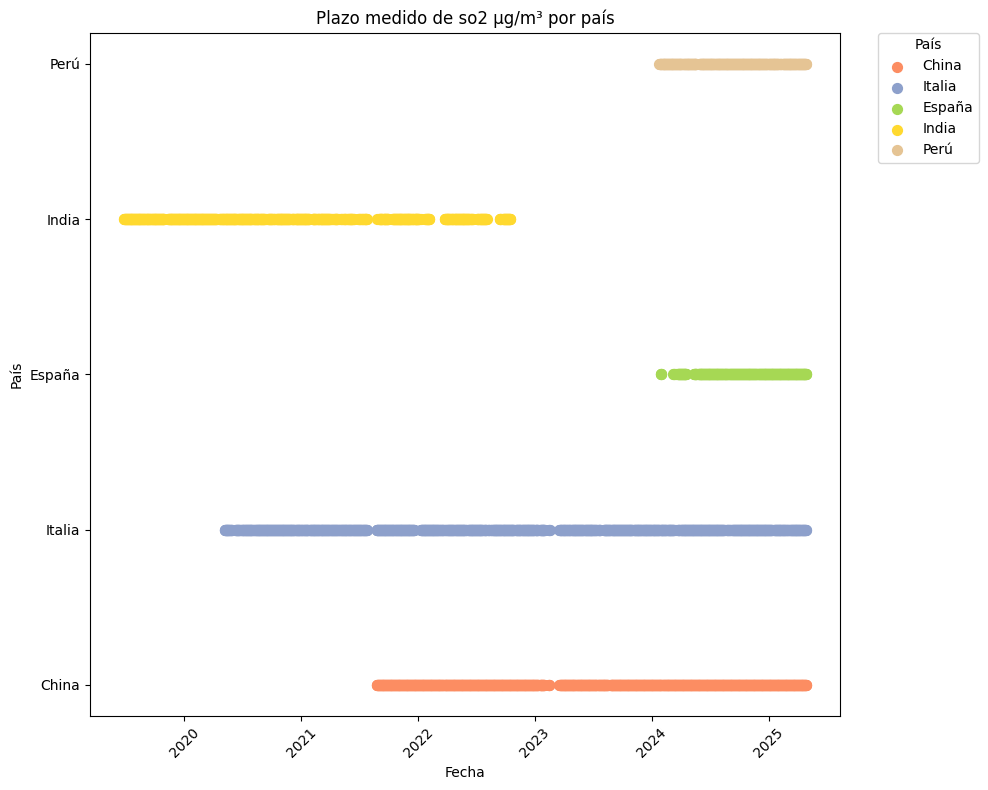

In [ ]:
all_dfs = pd.concat(locations_dfs, ignore_index=True)
all_dfs["from_date"] = pd.to_datetime(all_dfs["from_date"])

# Filter and plot each selected parameter
for parameter in selected_parameters:
    plt.figure(figsize=(10, 8))
    plt.title(f"Plazo medido de {parameter} por país")

    # Filter data for the current parameter
    df_param = all_dfs[all_dfs["parameter_name"] == parameter]

    for country in df_param["country_name"].unique():
        country_data = df_param[df_param["country_name"] == country]
        color = locations_color_map[country]
        # Plot the presence of the parameter for each date, using dots for data points
        plt.scatter(
            country_data["from_date"],
            [country] * len(country_data),
            label=country,
            s=50,
            color=color,
        )

    plt.xlabel("Fecha")
    plt.ylabel("País")

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.xticks(rotation=45)
    plt.legend(
        title="País", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0
    )

    plt.tight_layout()
    plt.show()

Efectivamente, existen huecos de tiempo entre 2023 y 2024/25 en donde India, Mumbai no colecciona datos de ninguno de sus sensores. Posiblemente tomó muchos datos antes del 2023, y por ello tiene tantas muestras, pero al agrupar por día disminuyen. Esto también influye en los promedios que veremos posteriormente, pues los datos pueden no ser representativos para fechas recientes, si no más lejanas.

Podemos por último ver cuáles parámetros son medidos por cada localización en una tabla:

In [ ]:
pd.set_option("future.no_silent_downcasting", True)

parameter_location_map = {}
# Fill the dictionary with a check if the location has the parameter
for df, location in zip(locations_dfs, locations):
    location_name = f"{location.country}"
    parameters = df["parameter_name"].unique()

    for param in parameters:
        if param not in parameter_location_map:
            parameter_location_map[param] = {}
        parameter_location_map[param][location_name] = True

parameter_location_df = pd.DataFrame.from_dict(parameter_location_map, orient="index")
parameter_location_df = parameter_location_df.fillna(False)
parameter_location_df = parameter_location_df.replace({True: "X", False: ""})
parameter_location_df = parameter_location_df.style.set_properties(
    **{"text-align": "center"}
)

print("Parámetros medidos por cada país")
parameter_location_df

Parámetros medidos por cada país


Únicamente Costa Rica no cuenta con los otros 5 contaminantes, pero todas las demás localizaciones los comparten.

## 4.c Análisis univariable

Ahora, procedemos a hacer el análisis de cada variable que seleccionamos. Primeramente, se pueden hacer box plots para ver la distribución de los datos en cada parámetro y localización:

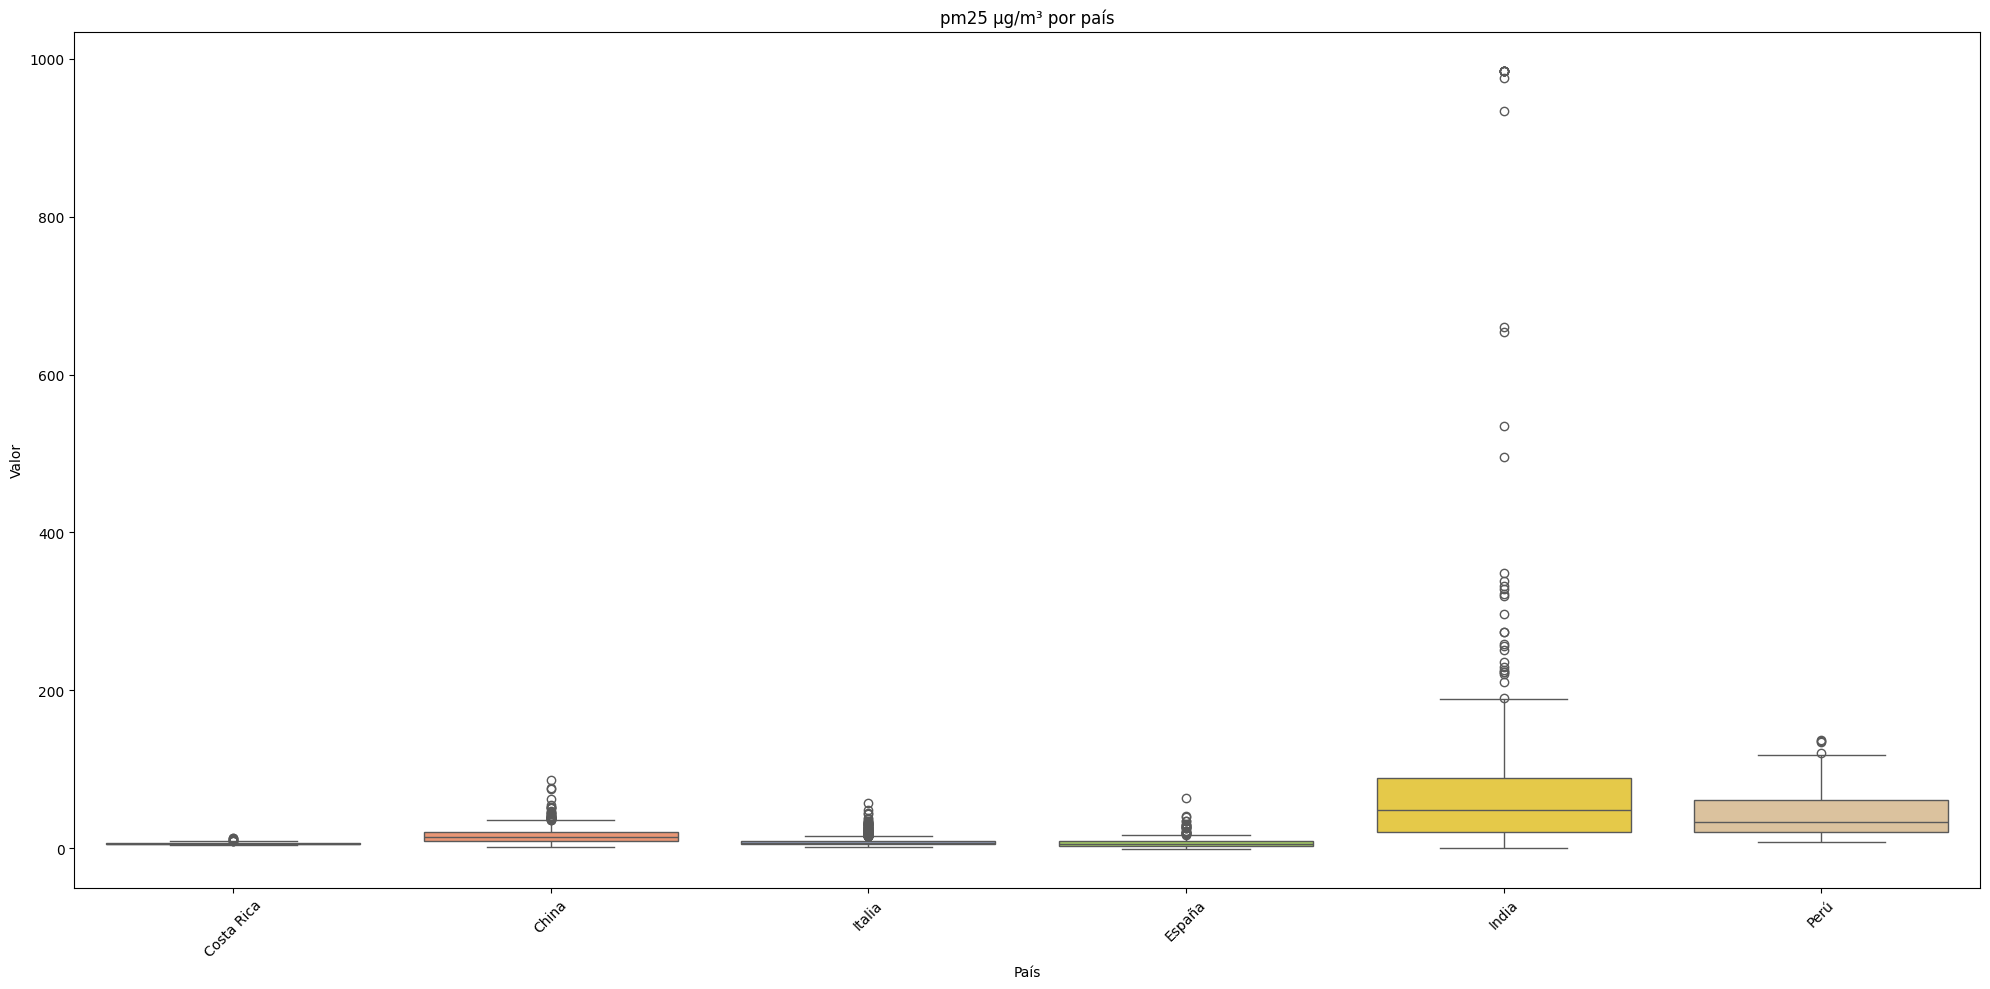

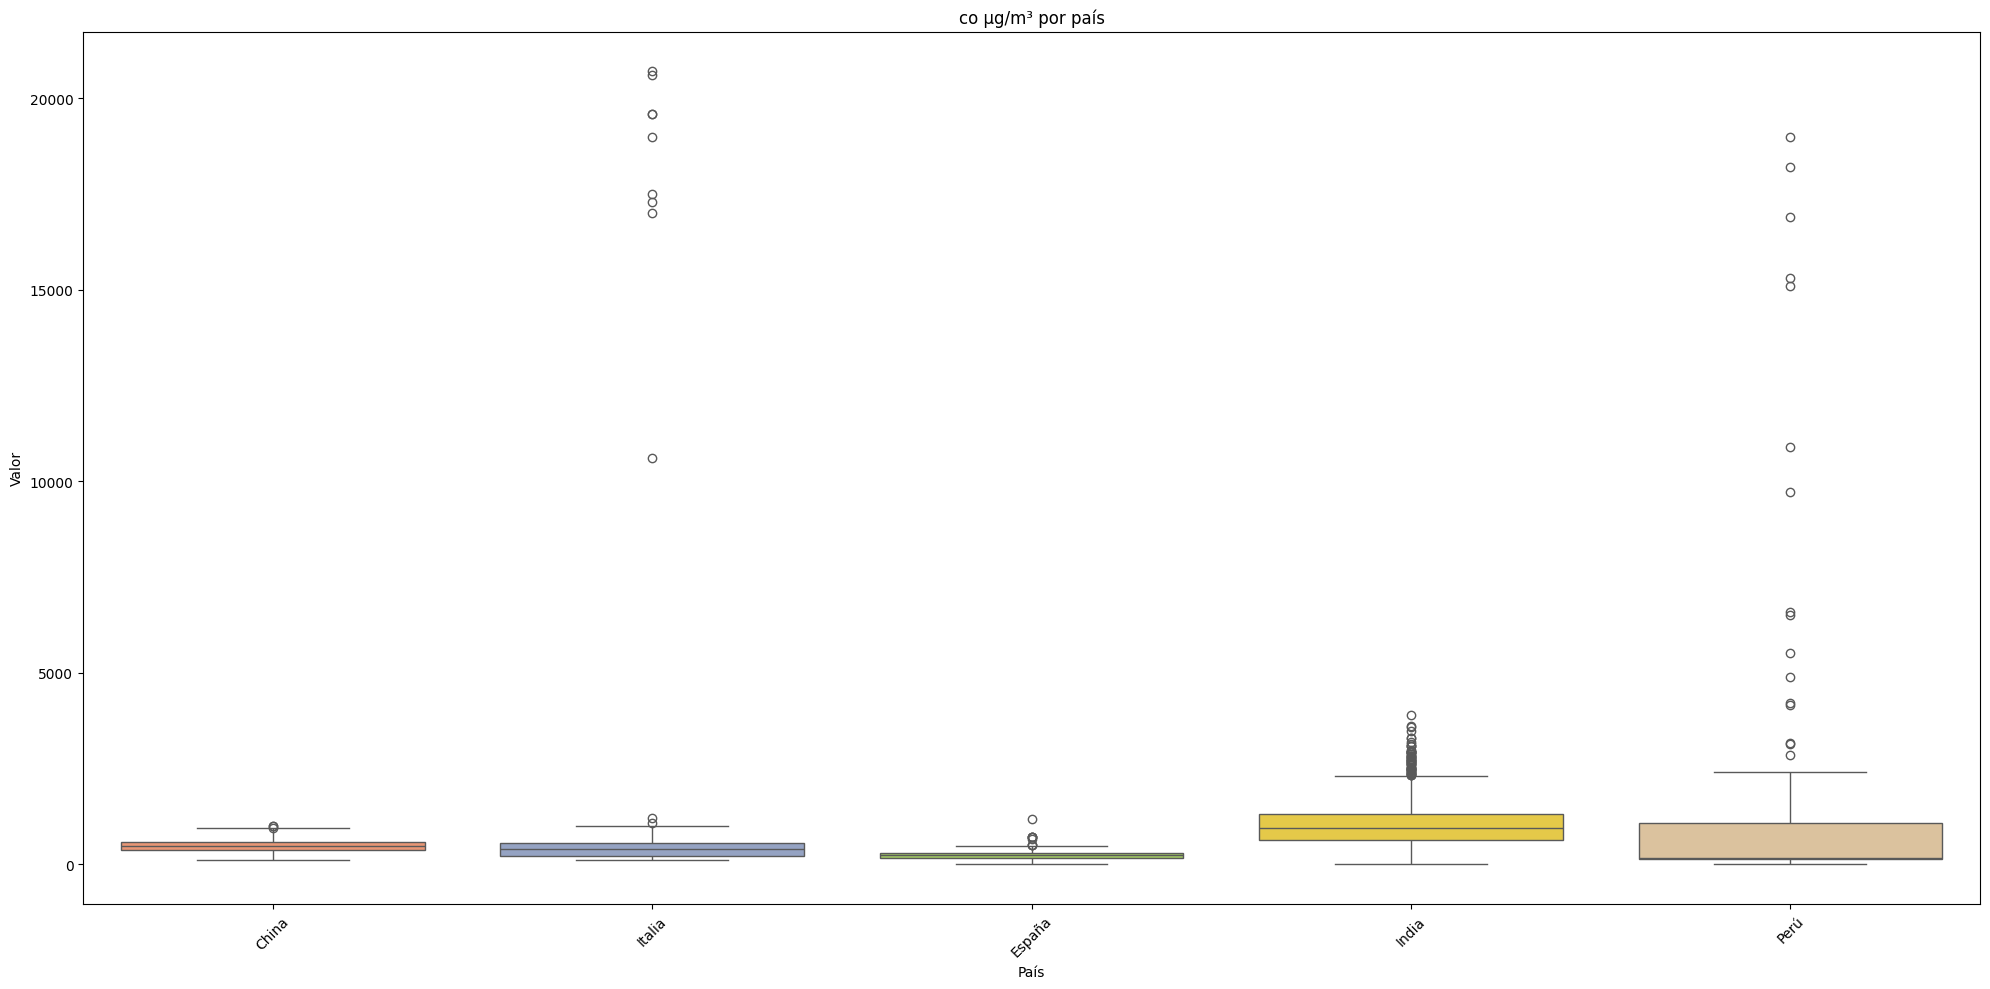

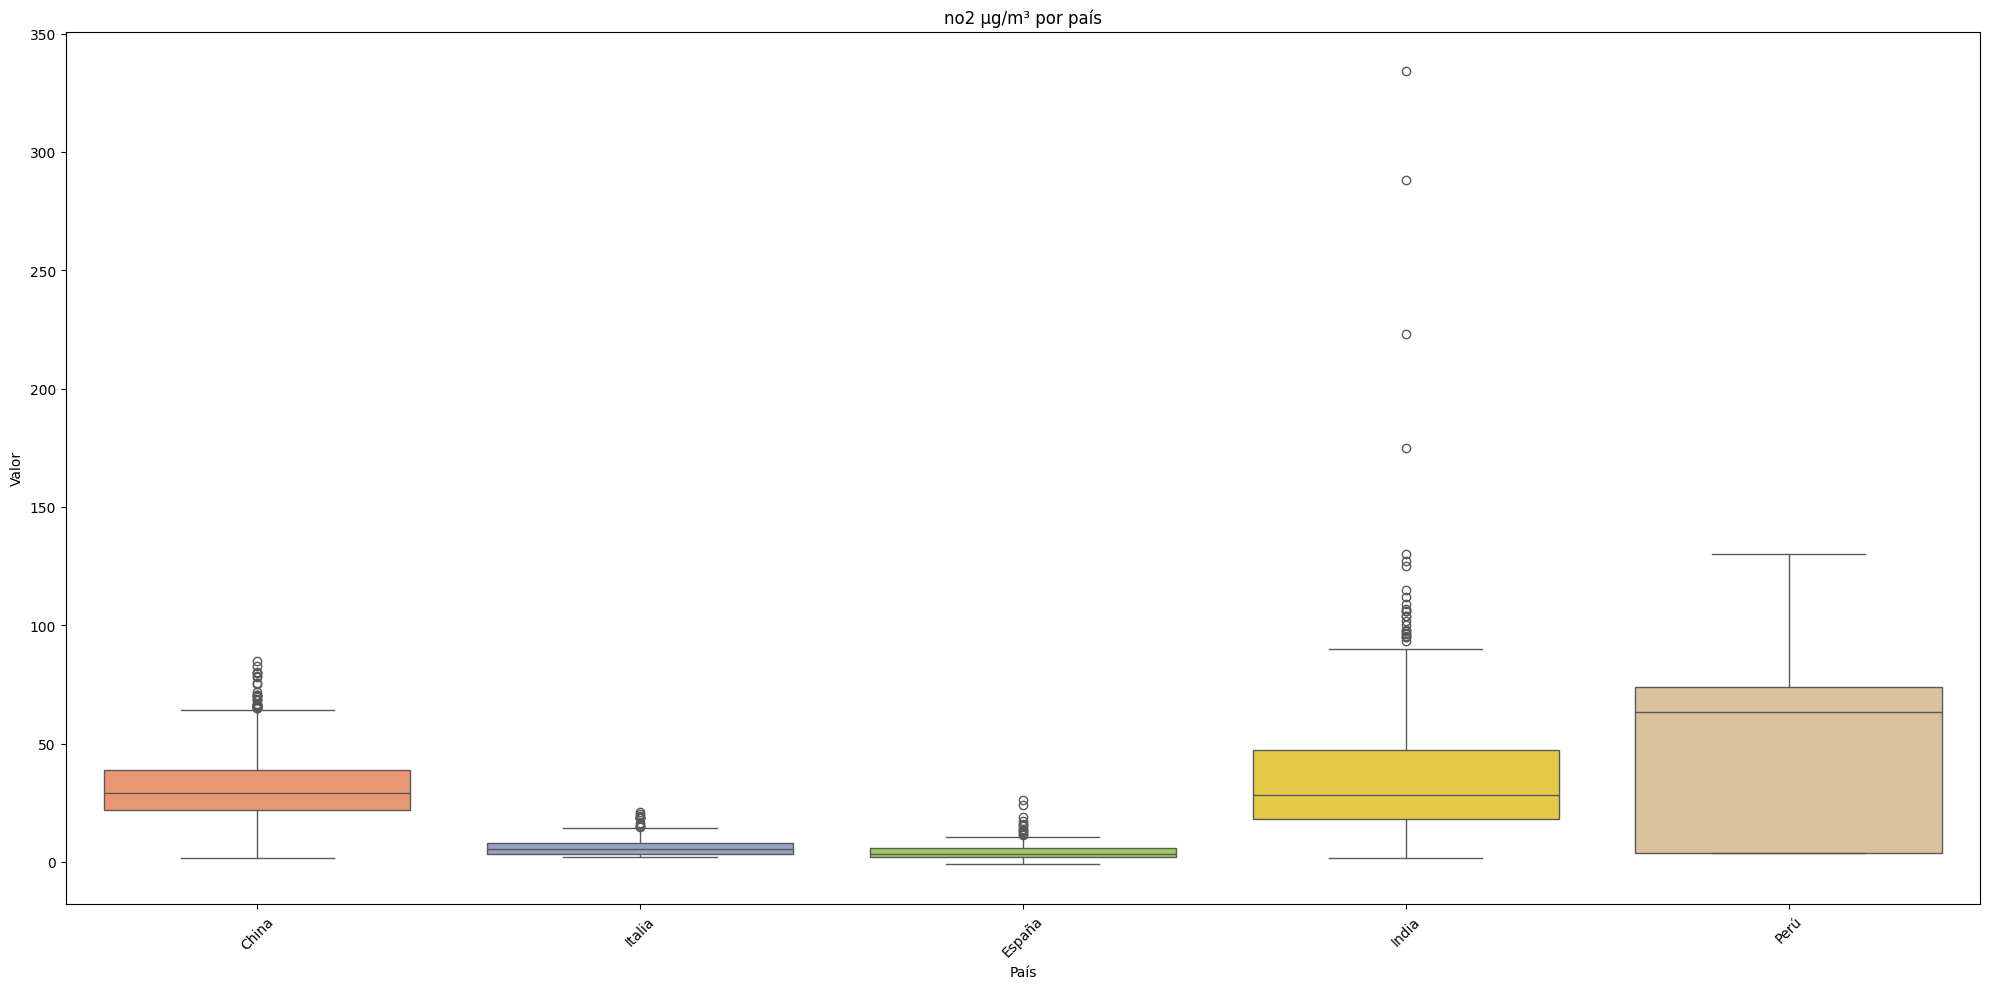

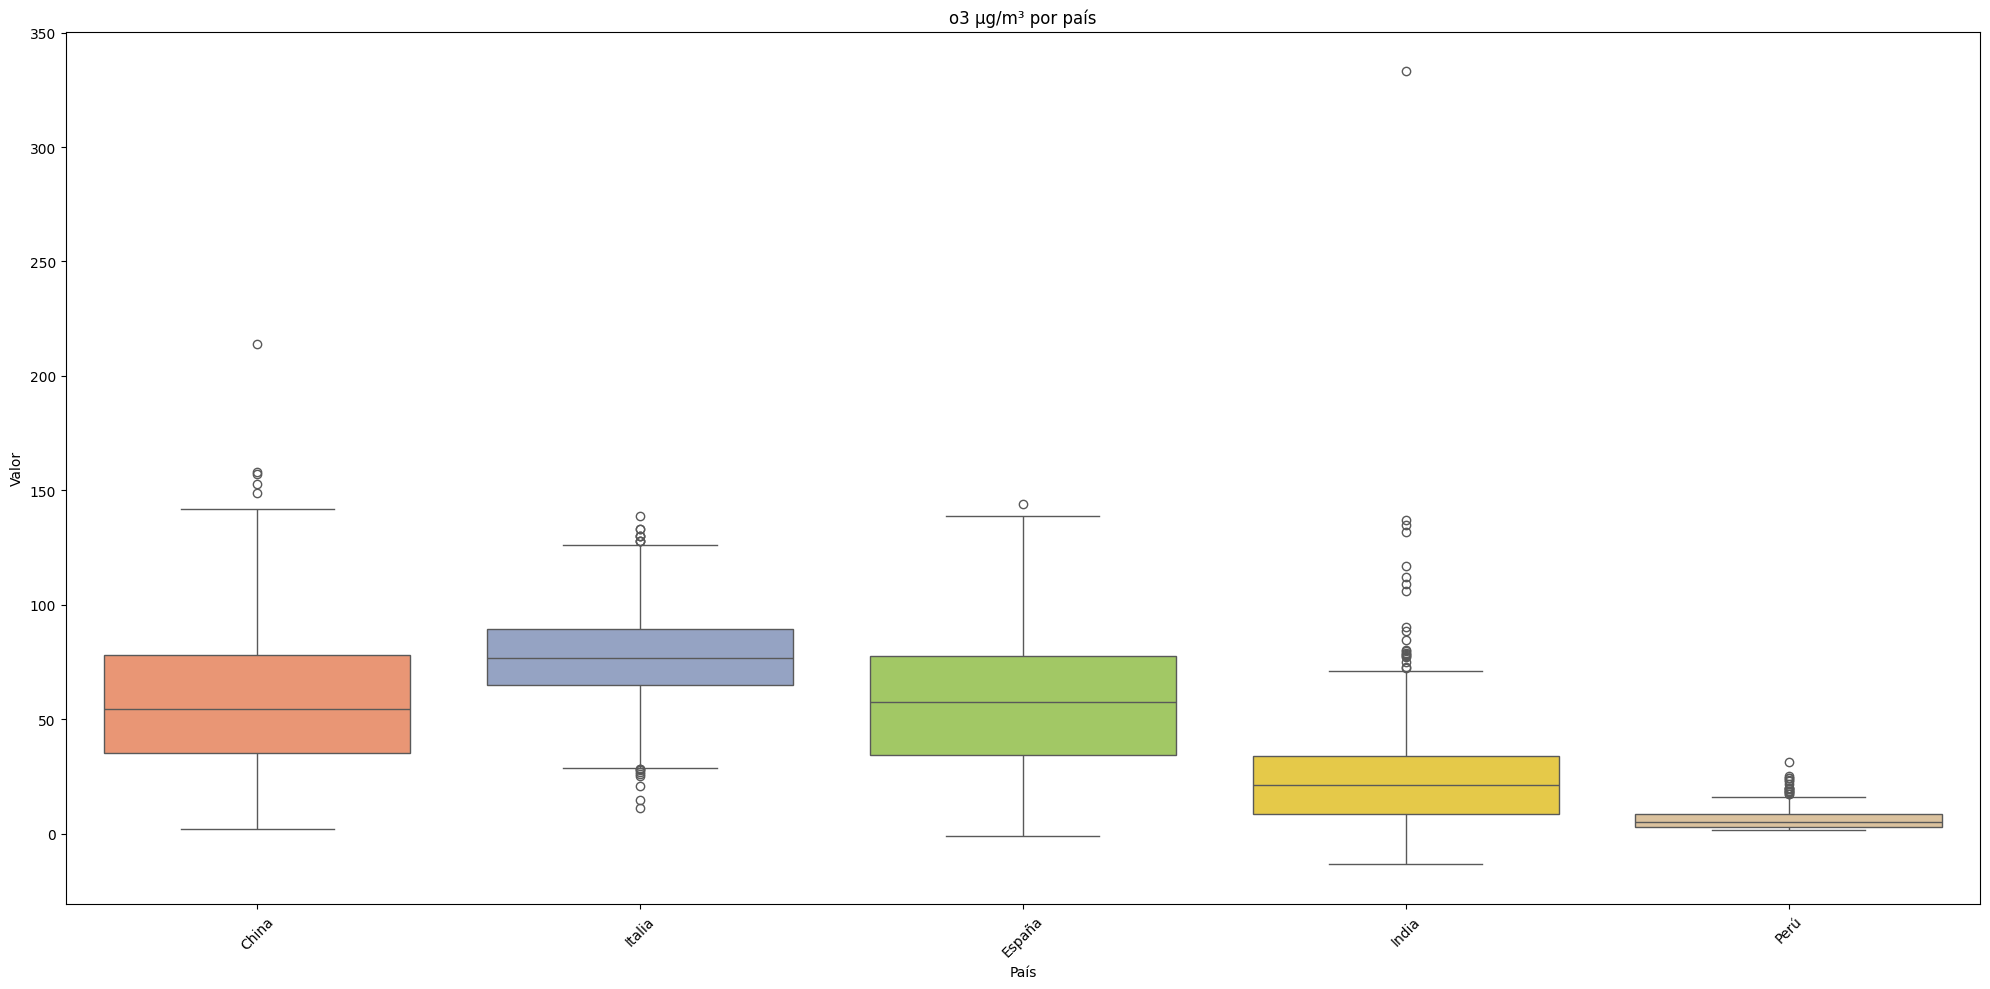

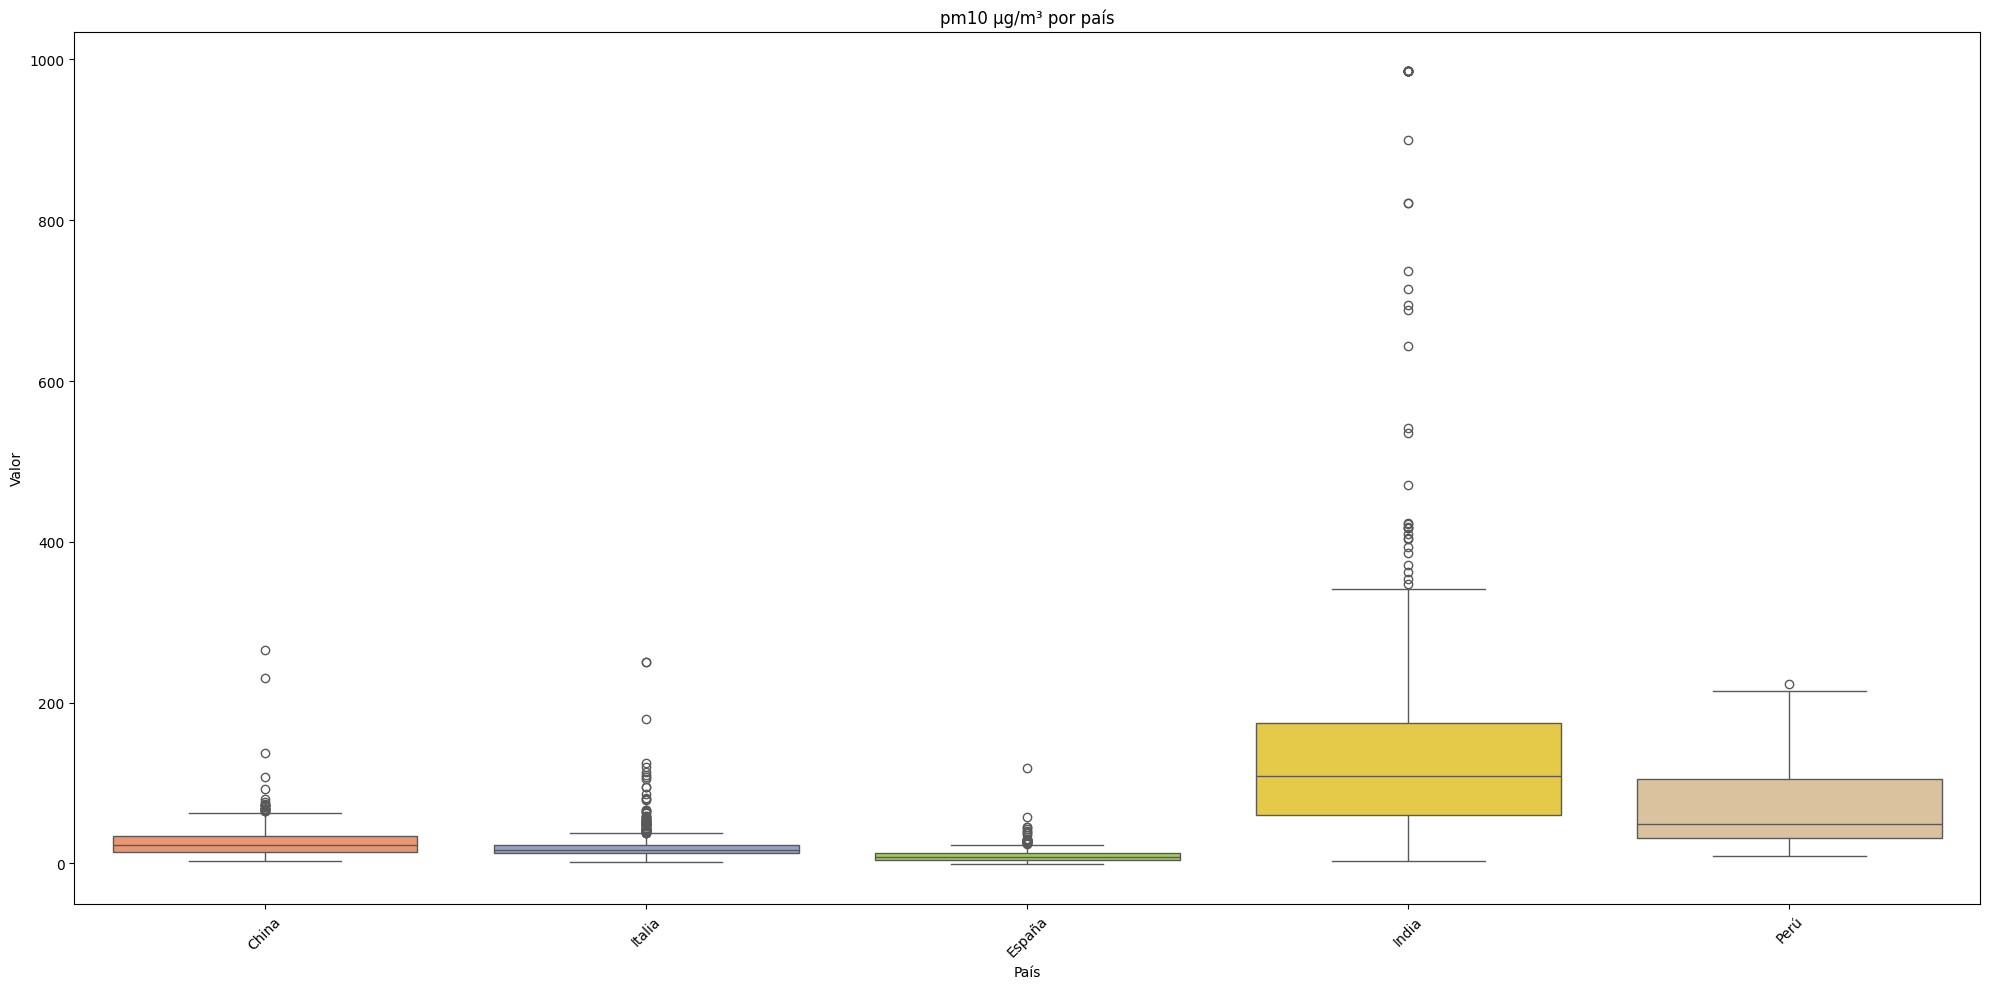

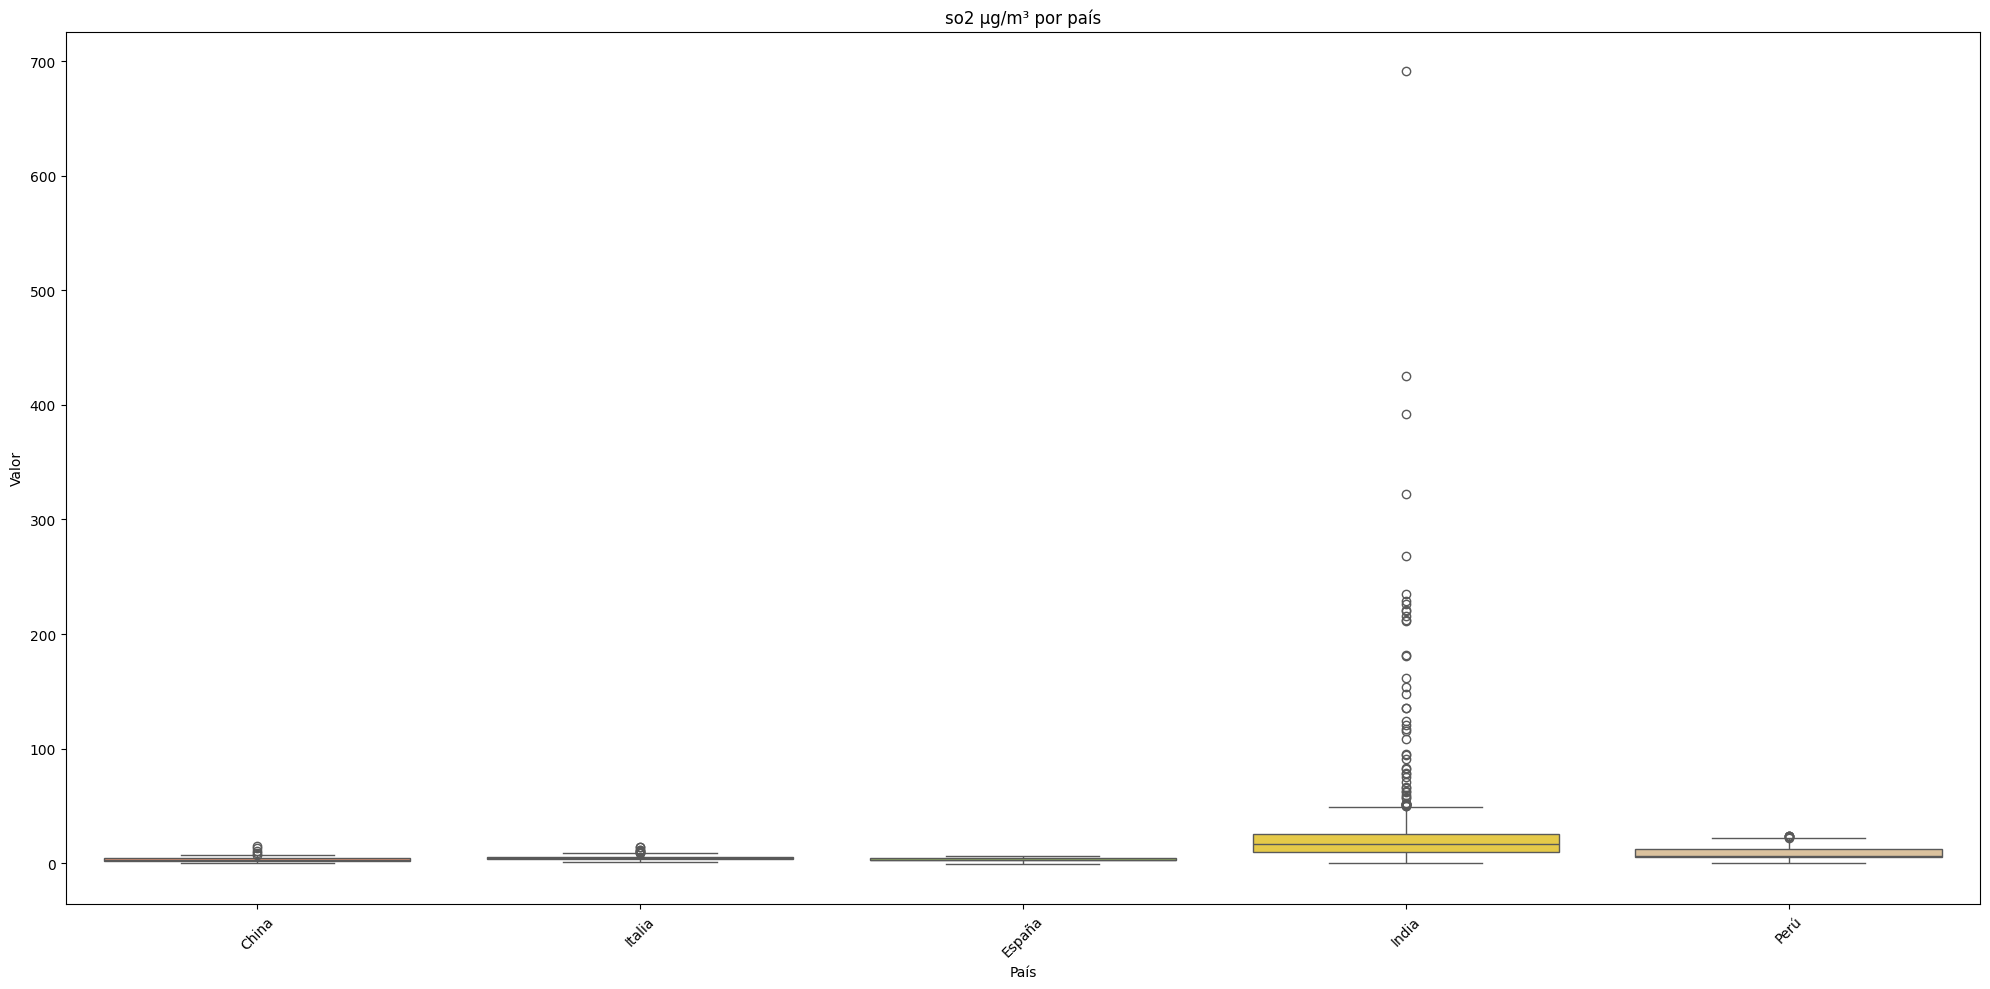

In [ ]:
all_dfs = pd.concat(locations_dfs, ignore_index=True)
different_parameters = all_dfs["parameter_name"].unique()

for i, parameter in enumerate(different_parameters):
    plt.figure(figsize=(20, 10))
    plt.title(f"{parameter} por país")
    plt.xlabel("País")
    plt.ylabel("Valor")
    plt.xticks(rotation=45)
    sns.boxplot(
        x="country_name",
        y="value",
        hue="country_name",
        data=all_dfs[all_dfs["parameter_name"] == parameter],
        palette=locations_color_map,
    )
    plt.tight_layout()

plt.show()

Para las mediciones de particula pm25, es un poco difícil de interpretar ya que India presenta muchos más datos que los demás de países, sin embargo parece ser que  los datos parecen mostrar que en Italia y España tienen comportamientos similares. Esto puede deberse a la zona y que ambos países pueden estar sujetos a regulaciones de la Unión Europea.

En el caso de las partículas de CO es muy interesante como Perú muestra una distribución muy similar a la de India en los últimos cuartiles. También es importante notar que Italia presenta los mayores outliers. Esto puede deberse a fallas en los sensores

Los gráficos de NO2 muestra el mismo patrón con respecto a Italia y España, China parece tener los datos más normalizados y Perú está mostrando una gran varianza en los datos.

Lo boxplots de O3 presentan un panórama diferente a los demás, en este caso casi todos los países presentan una distribución similiar con un promedio entre 50 y 80. Mientras que Perú si tiene sus con una varianza muy pequeña

El gráfico PM10 muestra un panórama muy similar al gráfico de párticulas PM25, sin embargo en este caso existe una mayor varianza en los datos

Finalmente en el caso de SO2 la mayoría de países muestra distribuciones muy similares a excepción de Mumbai que si presenta muchos outliers, lo cual generar un boxplot muy diferente al resto.

### Visualización de cada parámetro, en el mapa

Así mismo, se puede facilitar ver las conclusiones de los gráficos anteriores viendo la mediana graficada en un mapa de calor que refleja las zonas que tienen mayor influencia de esa variable.

In [ ]:
def make_heatmap(
    parameter, lons, lats, values, countries, grid_resolution=500, smoothing_sigma=6
):
    """
    Creates a heatmap of a specified parameter using given locations and values.

    Args:
        parameter (str): Name of the parameter (e.g., 'pm25').
        lons (list of float): Longitudes of the locations.
        lats (list of float): Latitudes of the locations.
        values (list of float): Values corresponding to each location.
        countries (list of str): List of country names.
        grid_resolution (int, optional): Resolution of the grid (default is 500).
        smoothing_sigma (float, optional): Sigma for Gaussian smoothing (default is 6).
    """
    grid_lon = np.linspace(-180, 180, grid_resolution)
    grid_lat = np.linspace(-90, 90, grid_resolution)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    grid_values = np.zeros_like(grid_lon)

    for lon, lat, value in zip(lons, lats, values):
        distance = np.sqrt((grid_lon - lon) ** 2 + (grid_lat - lat) ** 2)
        grid_values += value * np.exp(-(distance**2) / (2 * 3**2))

    grid_values = gaussian_filter(grid_values, sigma=smoothing_sigma)

    fig = plt.figure(figsize=(12, 8), dpi=100)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(color="white", linewidth=0.5)

    c = ax.pcolormesh(
        grid_lon,
        grid_lat,
        grid_values,
        cmap="inferno",
        shading="auto",
        transform=ccrs.PlateCarree(),
    )

    cb = plt.colorbar(c, ax=ax, orientation="vertical", fraction=0.025, pad=0.035)
    cb.set_label(f"Nivel de {parameter}", color="black")
    cb.ax.yaxis.set_tick_params(color="black")
    plt.setp(plt.getp(cb.ax.axes, "yticklabels"), color="black")

    cb.locator = ticker.MaxNLocator(nbins=5)
    cb.update_ticks()

    plt.title(
        f"Mediana de {parameter} en las localizaciones", fontsize=14, color="black"
    )

    sorted_countries_values = sorted(
        zip(countries, values), key=lambda x: x[1], reverse=True
    )
    sorted_legend_labels = [
        f"{country}: {value:.2f}" for country, value in sorted_countries_values
    ]

    bullet_marker = mlines.Line2D(
        [0], [0], marker="o", color="w", markerfacecolor="w", markersize=7, label=""
    )

    ax.legend(
        [bullet_marker] * len(sorted_countries_values),
        sorted_legend_labels,
        loc="center",
        fontsize=10,
        bbox_to_anchor=(0.5, -0.1),
        ncol=7,
        title=f"Países y sus medianas de {parameter}",
    )

    plt.tight_layout()
    plt.show()

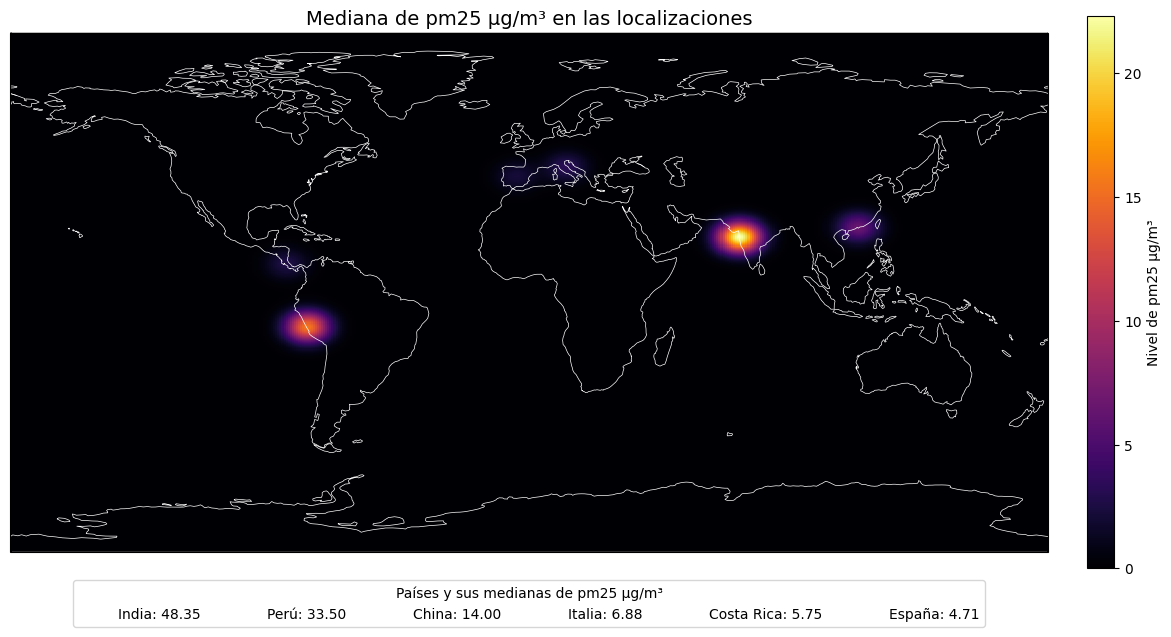

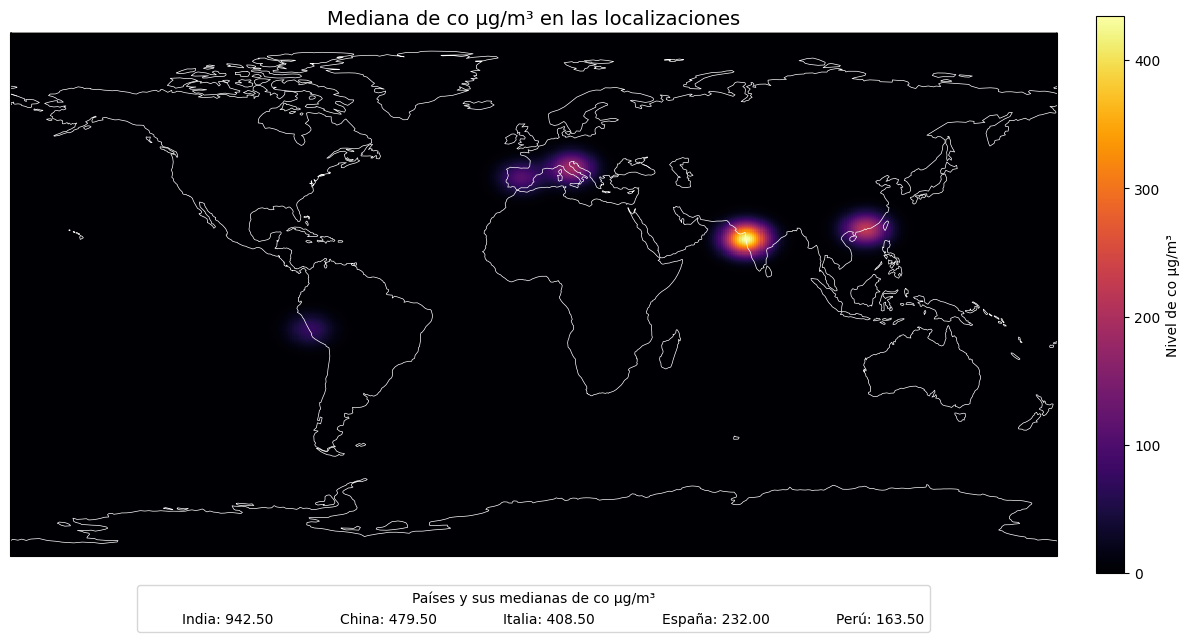

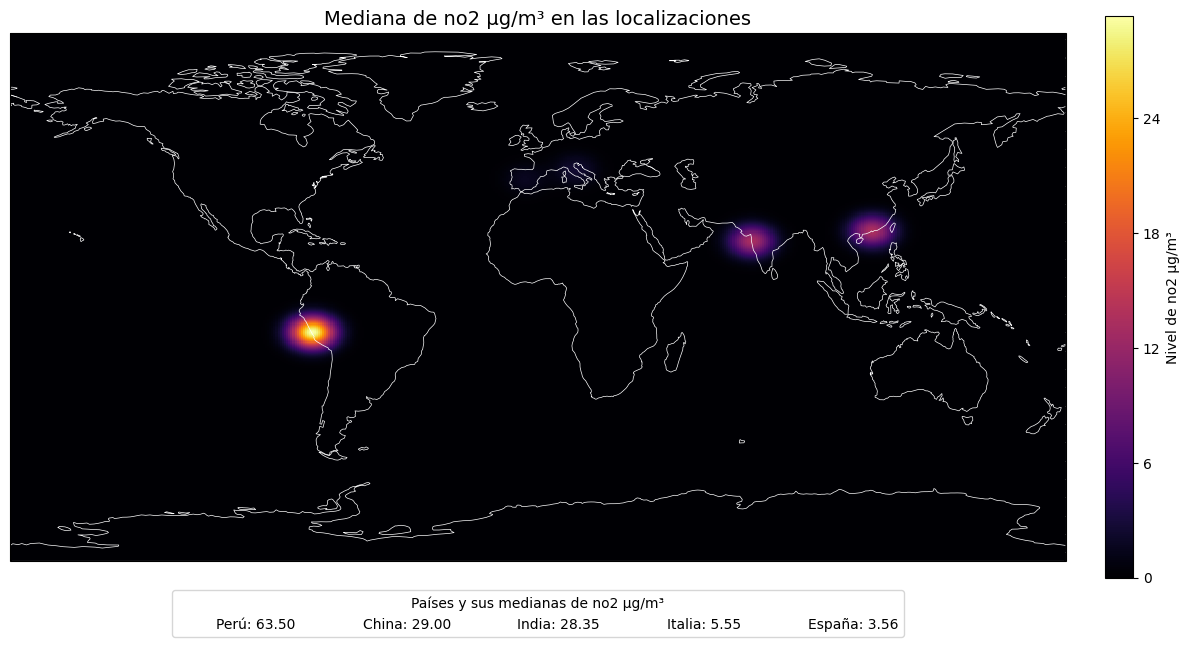

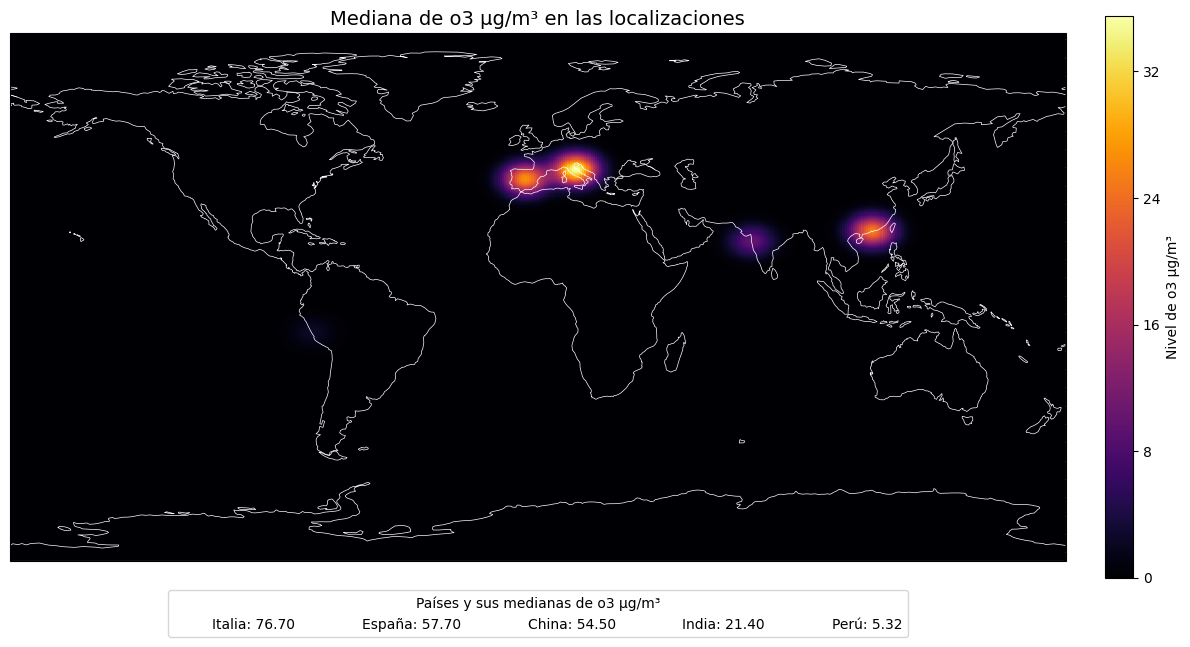

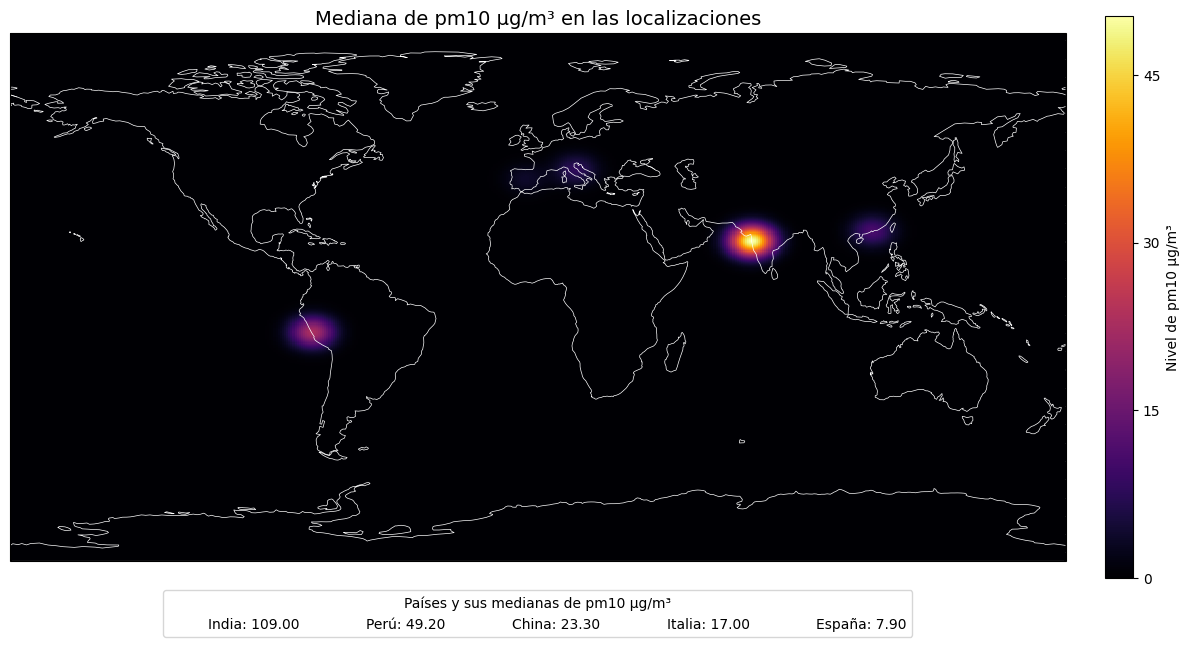

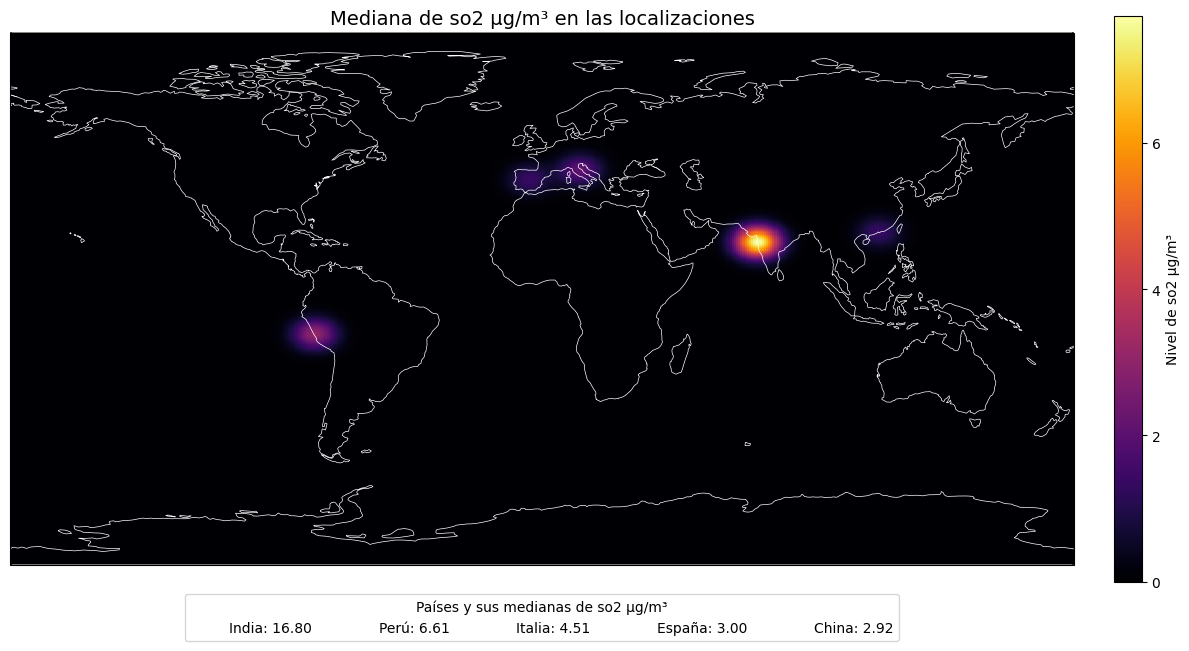

In [ ]:
for parameter in different_parameters:
    grouped = (
        all_dfs[all_dfs["parameter_name"] == parameter]
        .groupby("country_name")["value"]
        .median()
    )

    sorted_locations = sorted(locations, key=lambda x: x.country)
    lons, lats, values, countries = [], [], [], []
    for loc in sorted_locations:
        if loc.country in grouped.index:
            lons.append(loc.coordinates["longitude"])
            lats.append(loc.coordinates["latitude"])
            values.append(grouped[loc.country])
            countries.append(loc.country)

    make_heatmap(parameter, lons, lats, values, countries)

En los mapas se pueden notar comportamientos muy interesantes, los 3 paises que reportan las medianas más bajas en partículas PM25, son Costa Rica, España e Italia. Este patrón se repite en la mayoria de gráficos, esto puede deberse a que estos países tengan políticas ecológicas más estrictas. En este caso los mapas dan una imagen bastante similar a la obtenida por los boxplots con respecto a las concentraciones de partículas en el aire.


## 4.d Análisis multivariable:


### Progresion de tiempo

Podemos analizar los datos inicialmente con las funciones que ofrecen los pandas DF. Vamos a graficar el cambio de los parámetros a través del tiempo.

In [ ]:
locations_dfs = [
    pd.read_csv(f"{location.file_path}_cleaned.csv") for location in locations
]

In [ ]:
locations_dfs[0].head()

location_id country_name                       location_name  sensor_id  \
0      3070644   Costa Rica  San José, San Pedro, Montes de Oca   10669679   
1      3070644   Costa Rica  San José, San Pedro, Montes de Oca   10669679   
2      3070644   Costa Rica  San José, San Pedro, Montes de Oca   10669679   
3      3070644   Costa Rica  San José, San Pedro, Montes de Oca   10669679   
4      3070644   Costa Rica  San José, San Pedro, Montes de Oca   10669679   

              from_date               to_date parameter_name parameter_units  \
0  2024-09-19T06:00:00Z  2024-09-20T06:00:00Z     pm25 µg/m³           µg/m³   
1  2024-09-20T06:00:00Z  2024-09-21T06:00:00Z     pm25 µg/m³           µg/m³   
2  2024-10-08T06:00:00Z  2024-10-09T06:00:00Z     pm25 µg/m³           µg/m³   
3  2024-10-09T06:00:00Z  2024-10-10T06:00:00Z     pm25 µg/m³           µg/m³   
4  2024-10-10T06:00:00Z  2024-10-11T06:00:00Z     pm25 µg/m³           µg/m³   

   value  aggregated_count  summary_avg  summary_max  summary_median  \
0   6.78                22     6.778636         7.59            6.67   
1   6.94                31     6.943226         8.25            6.90   
2   5.89                30     5.889333         6.32            5.84   
3   5.74                78     5.736795         7.80            5.53   
4   7.50                75     7.501467        12.83            7.65   

   summary_min  summary_q02  summary_q25  summary_q75  summary_q98  summary_sd  
0         6.32       6.3368       6.5925       6.9600       7.4304    0.318094  
1         5.91       5.9760       6.5000       7.3150       8.2380    0.631593  
2         5.37       5.4860       5.7025       6.0825       6.3026    0.243607  
3         4.57       4.7640       5.2725       6.0325       7.3452    0.704368  
4         4.06       4.1136       5.6000       9.4250      12.1064    2.345845

Podemos visualizar el valor de los parámetros a través del tiempo para cada país:

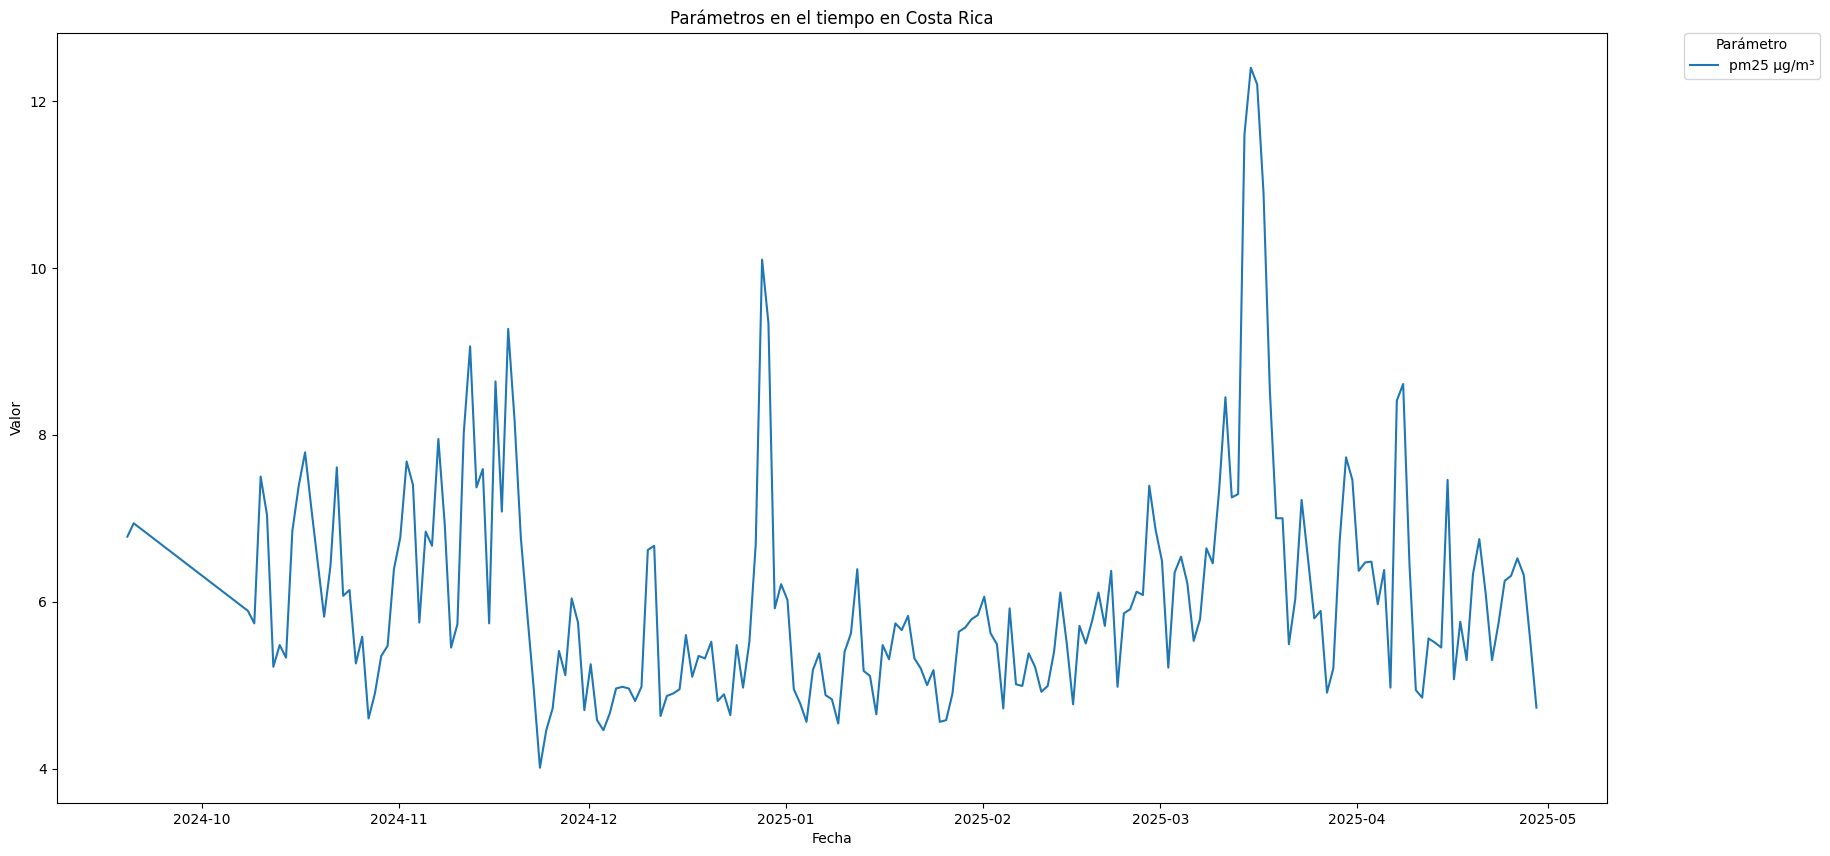

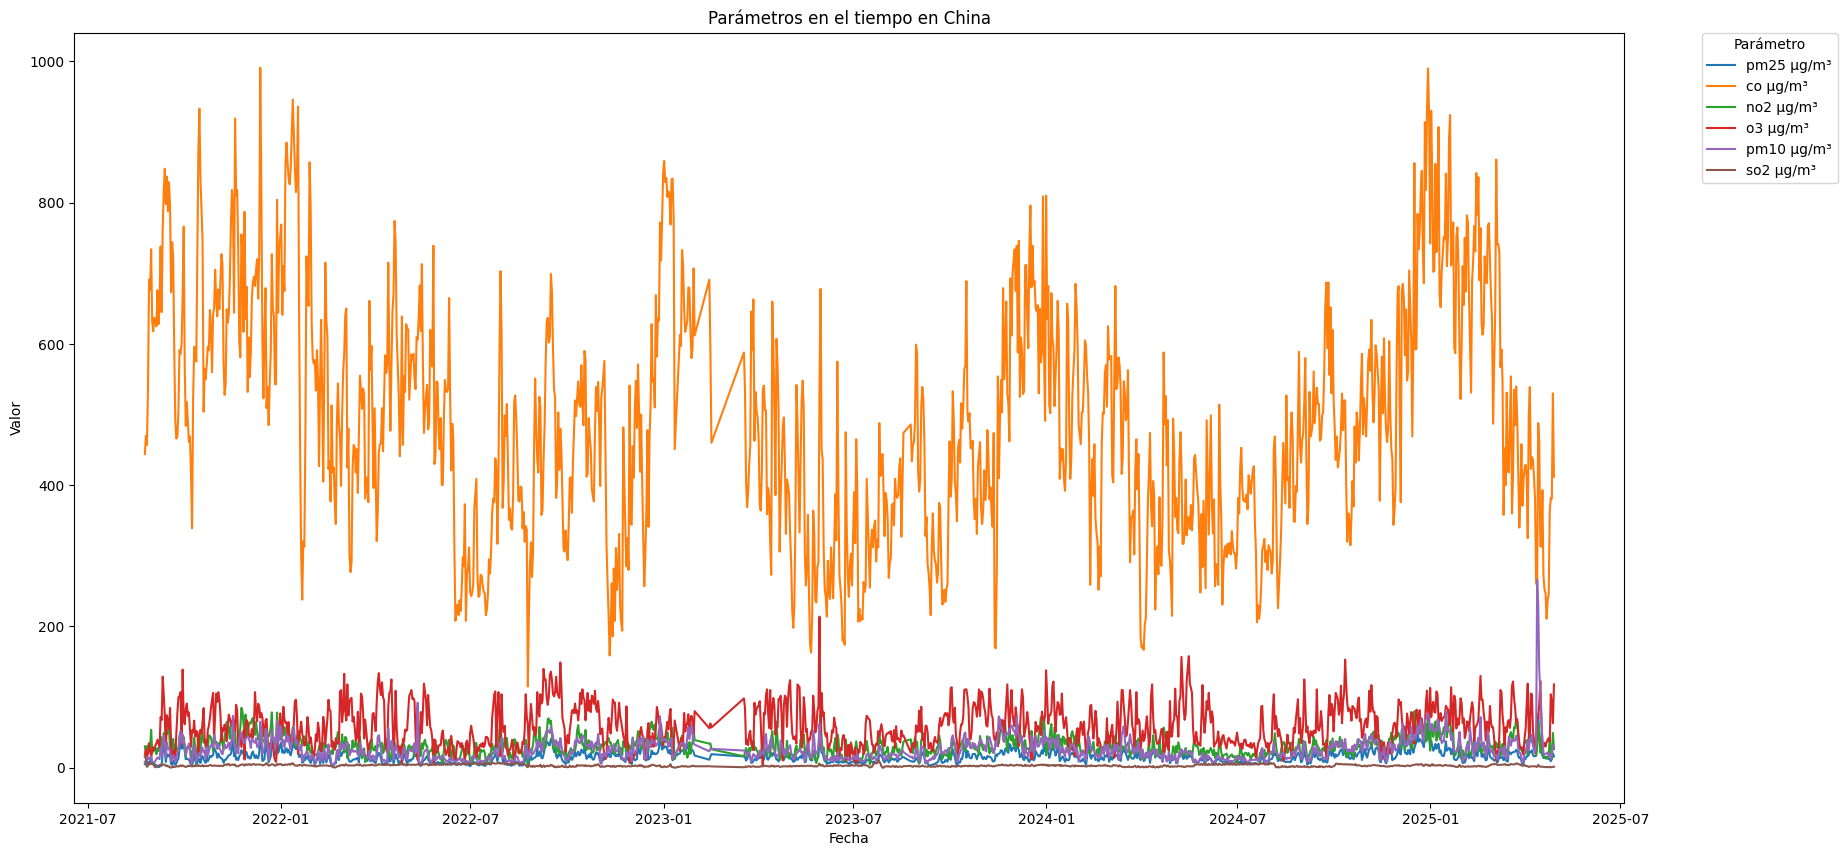

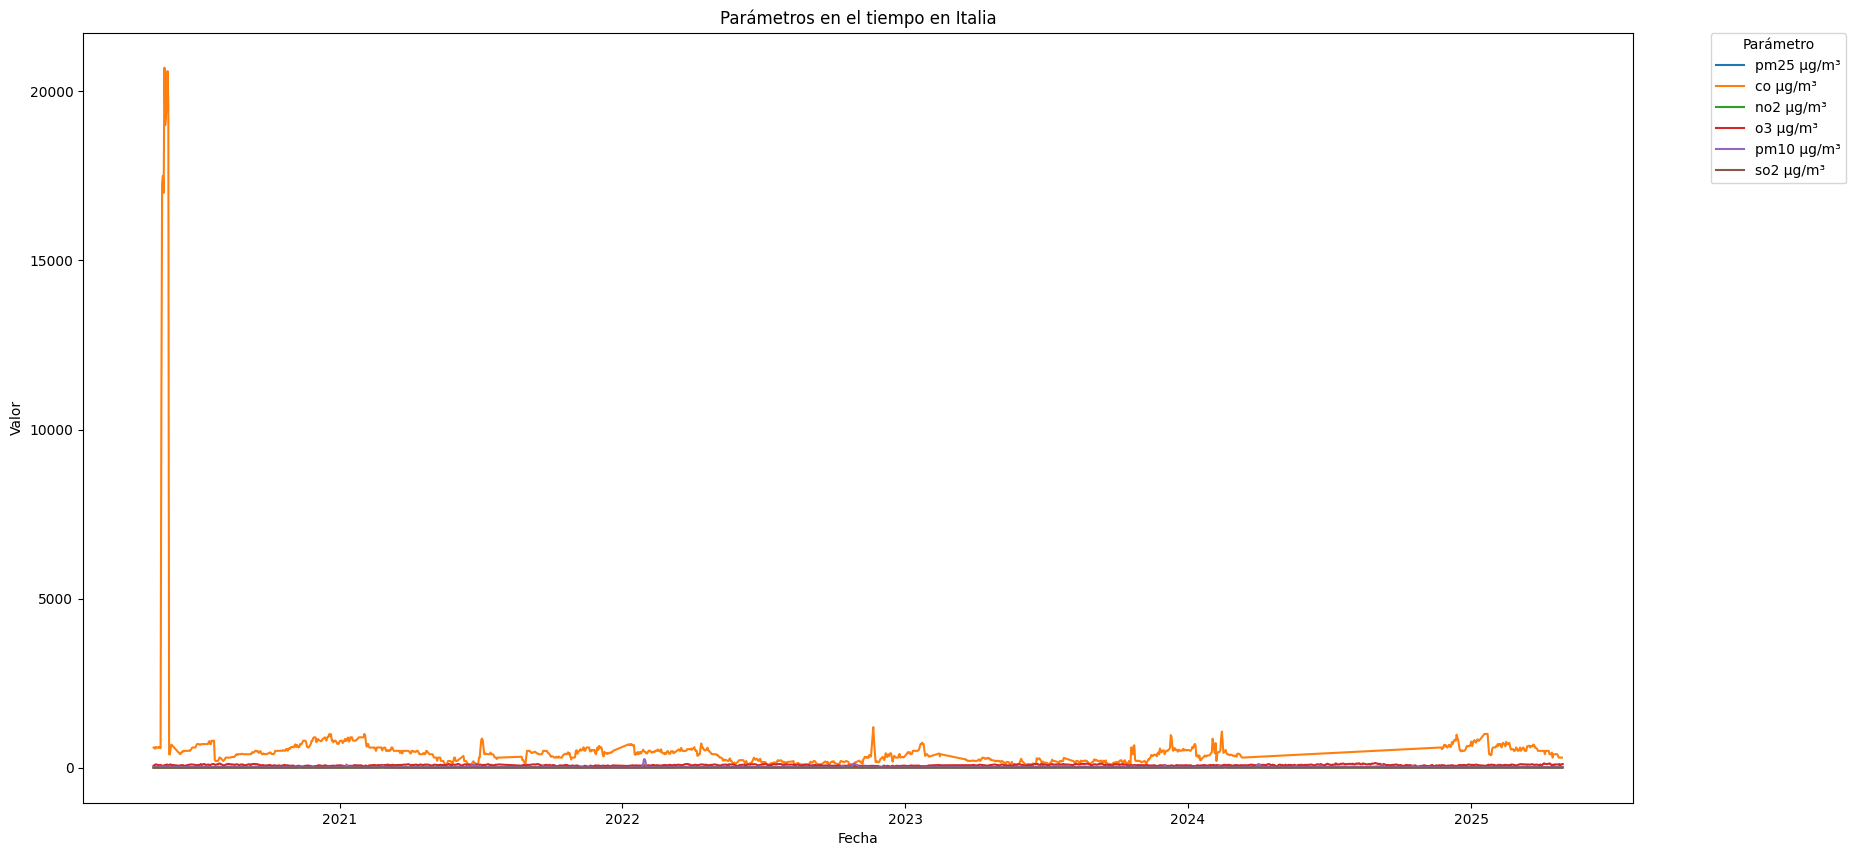

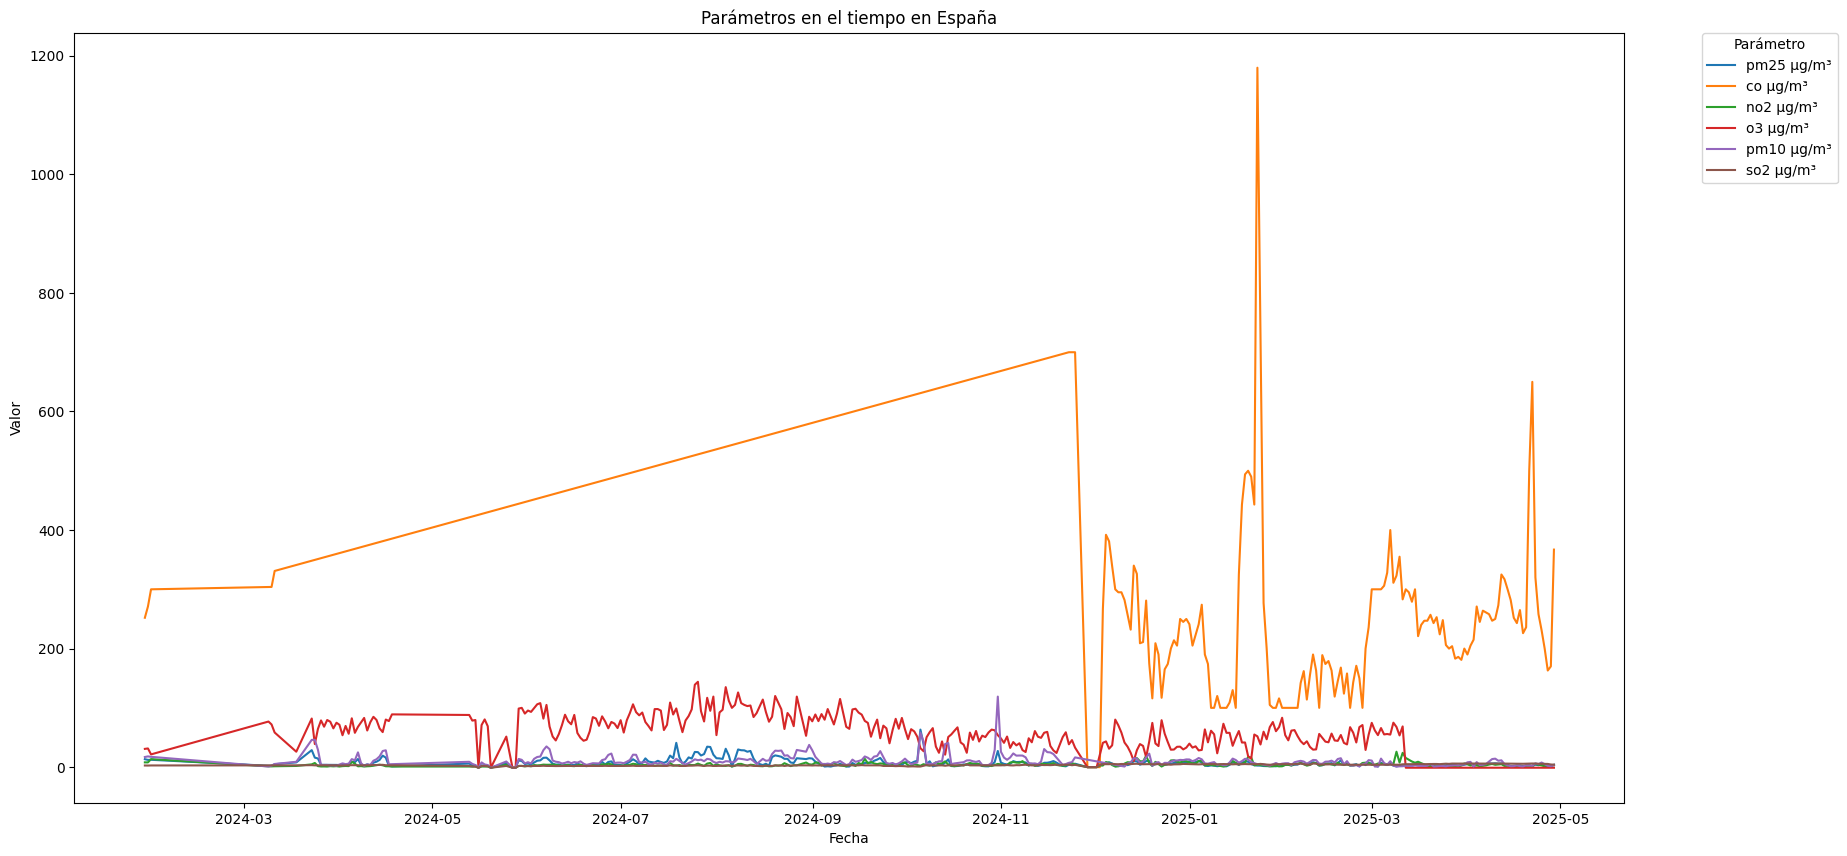

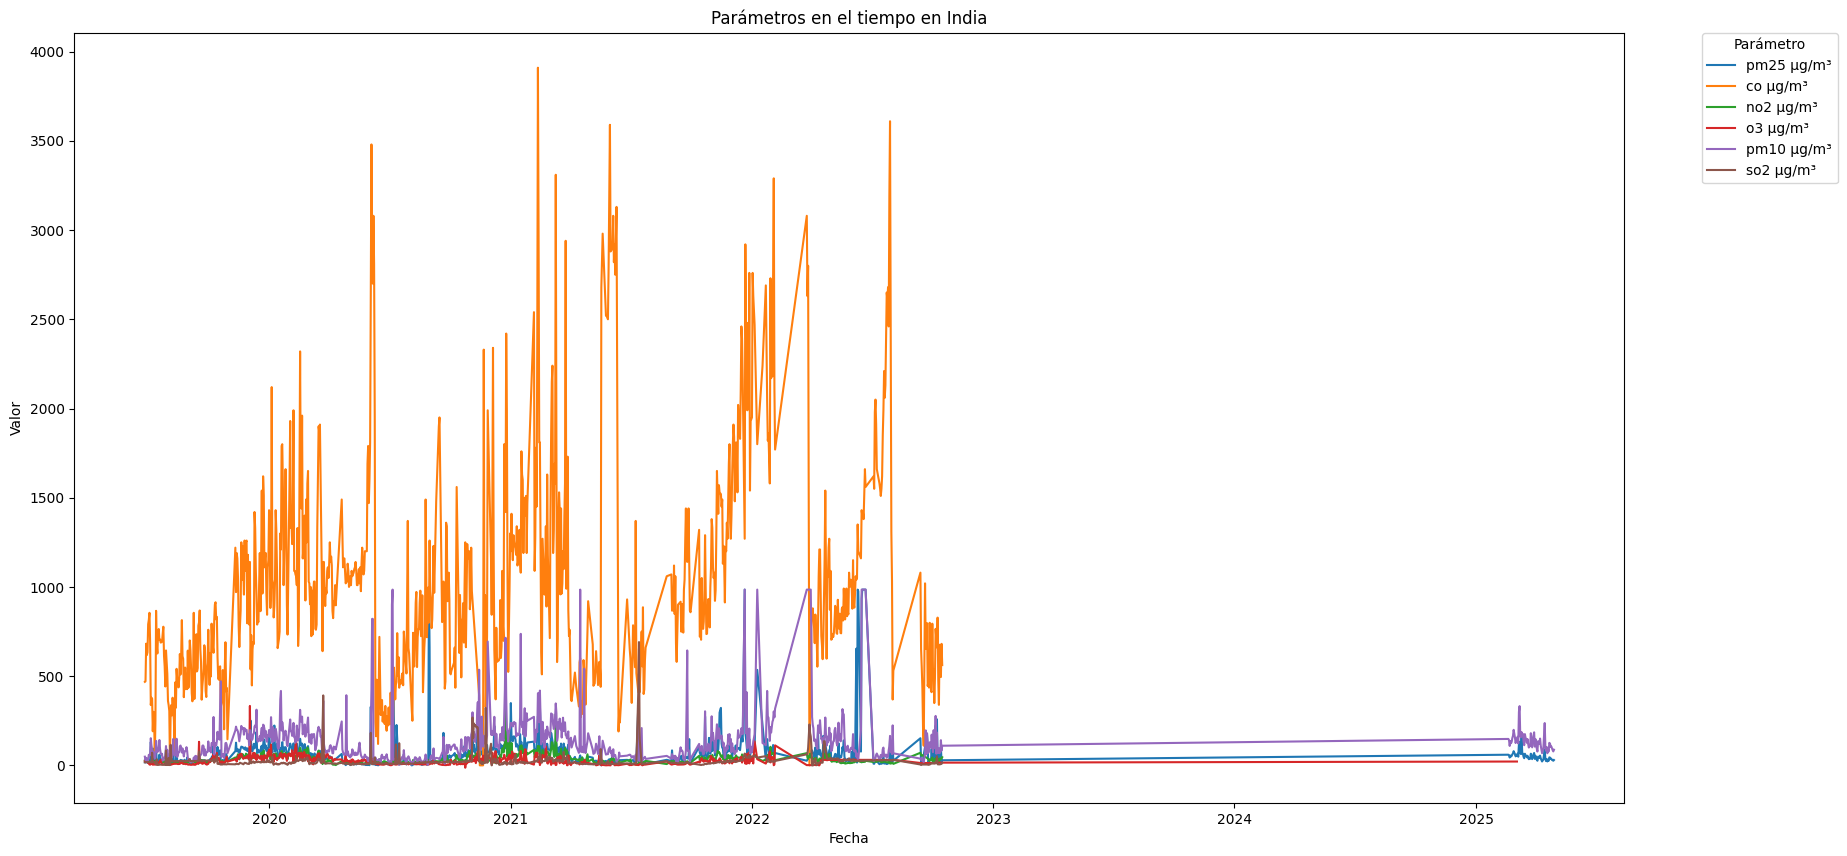

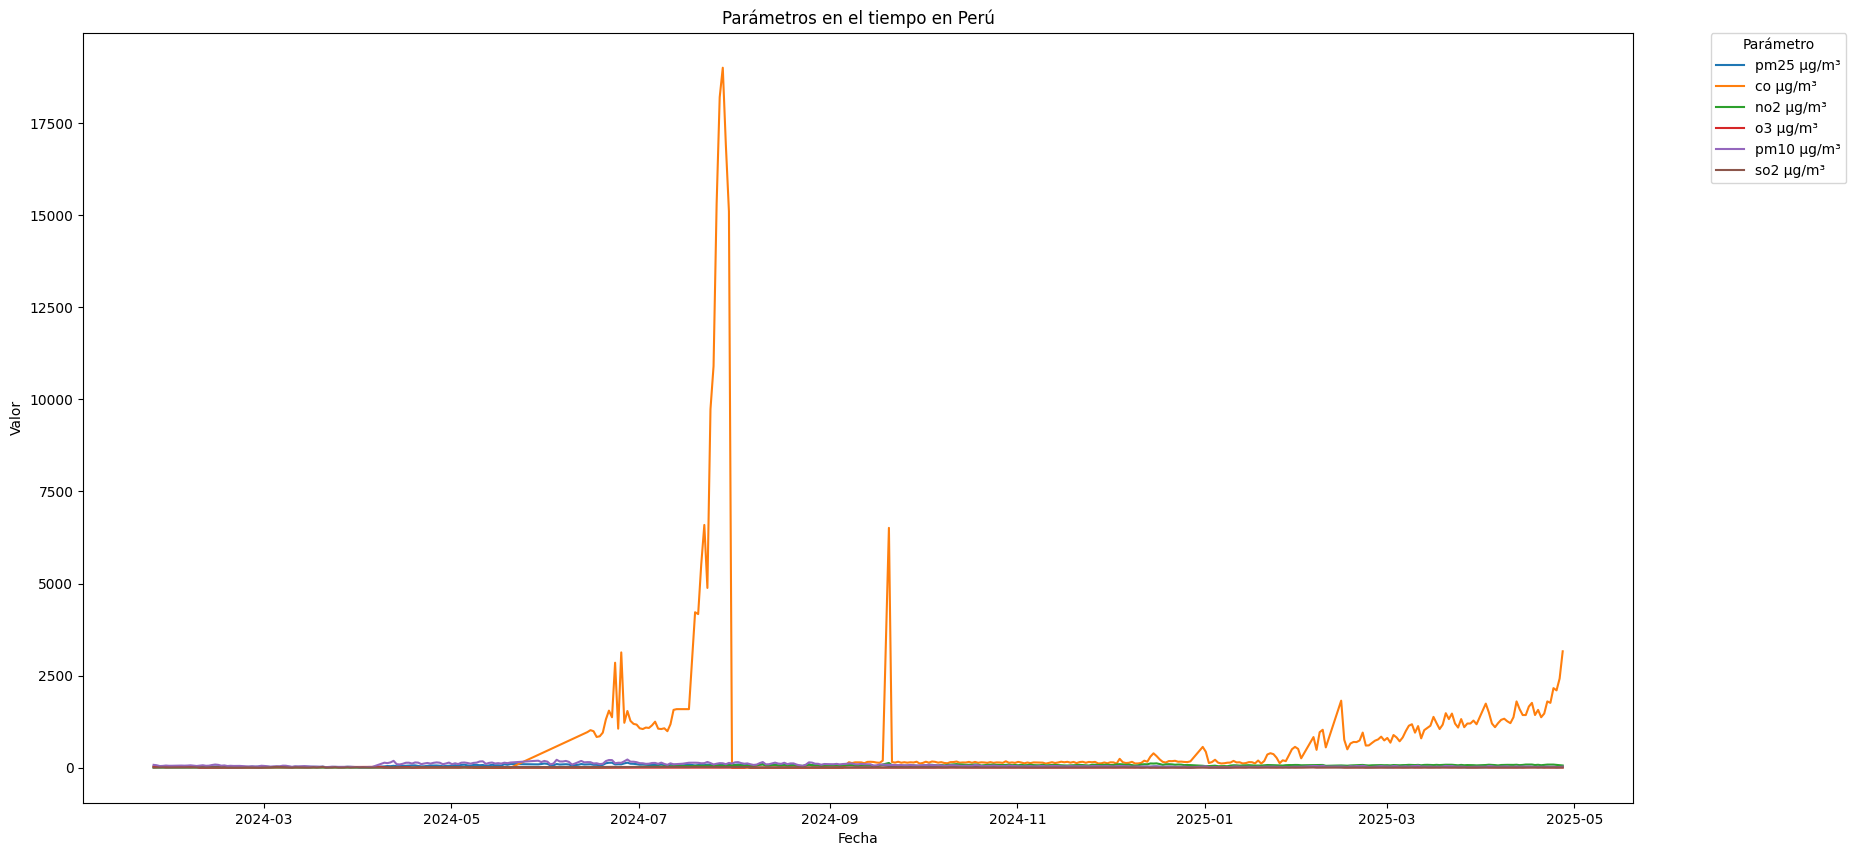

In [ ]:
df_countries = []
for country in locations_dfs:
    df_countries.append(
        country[["country_name", "from_date", "parameter_name", "value"]].copy()
    )

for i, df in enumerate(df_countries):
    plt.figure(figsize=(20, 10))
    df_countries[i]["from_date"] = pd.to_datetime(df["from_date"])
    df_countries[i] = df_countries[i].sort_values(by="from_date")

    for j in range(len(df_countries[i]["parameter_name"].unique())):
        x = df_countries[i][
            df_countries[i]["parameter_name"] == different_parameters[j]
        ]["from_date"]
        y = df_countries[i][
            df_countries[i]["parameter_name"] == different_parameters[j]
        ]["value"]
        plt.plot(x, y, label=different_parameters[j])

    plt.title(f"Parámetros en el tiempo en {df_countries[i]['country_name'].iloc[0]}")
    # Move legend outside the plot
    plt.legend(
        title="Parámetro", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0
    )

    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.show()

Según la [WHO](https://www.eea.europa.eu/publications/status-of-air-quality-in-Europe-2022/europes-air-quality-status-2022/world-health-organization-who-air), los valores máximos recomendados por día para cada parámetros son:

In [ ]:
recommended_values = {
    "parameter_name": [
        "pm25 µg/m³",
        "co µg/m³",
        "no2 µg/m³",
        "o3 µg/m³",
        "pm10 µg/m³",
        "so2 µg/m³",
    ],
    "recommended_value": [15, 4000, 25, 100, 45, 40],
}
recommended_values_df = pd.DataFrame(recommended_values)
recommended_values_df

parameter_name  recommended_value
0     pm25 µg/m³                 15
1       co µg/m³               4000
2      no2 µg/m³                 25
3       o3 µg/m³                100
4     pm10 µg/m³                 45
5      so2 µg/m³                 40

Podemos visualizar cuáles pases están cumpliendo este límite, viéndolo en un gráfico:

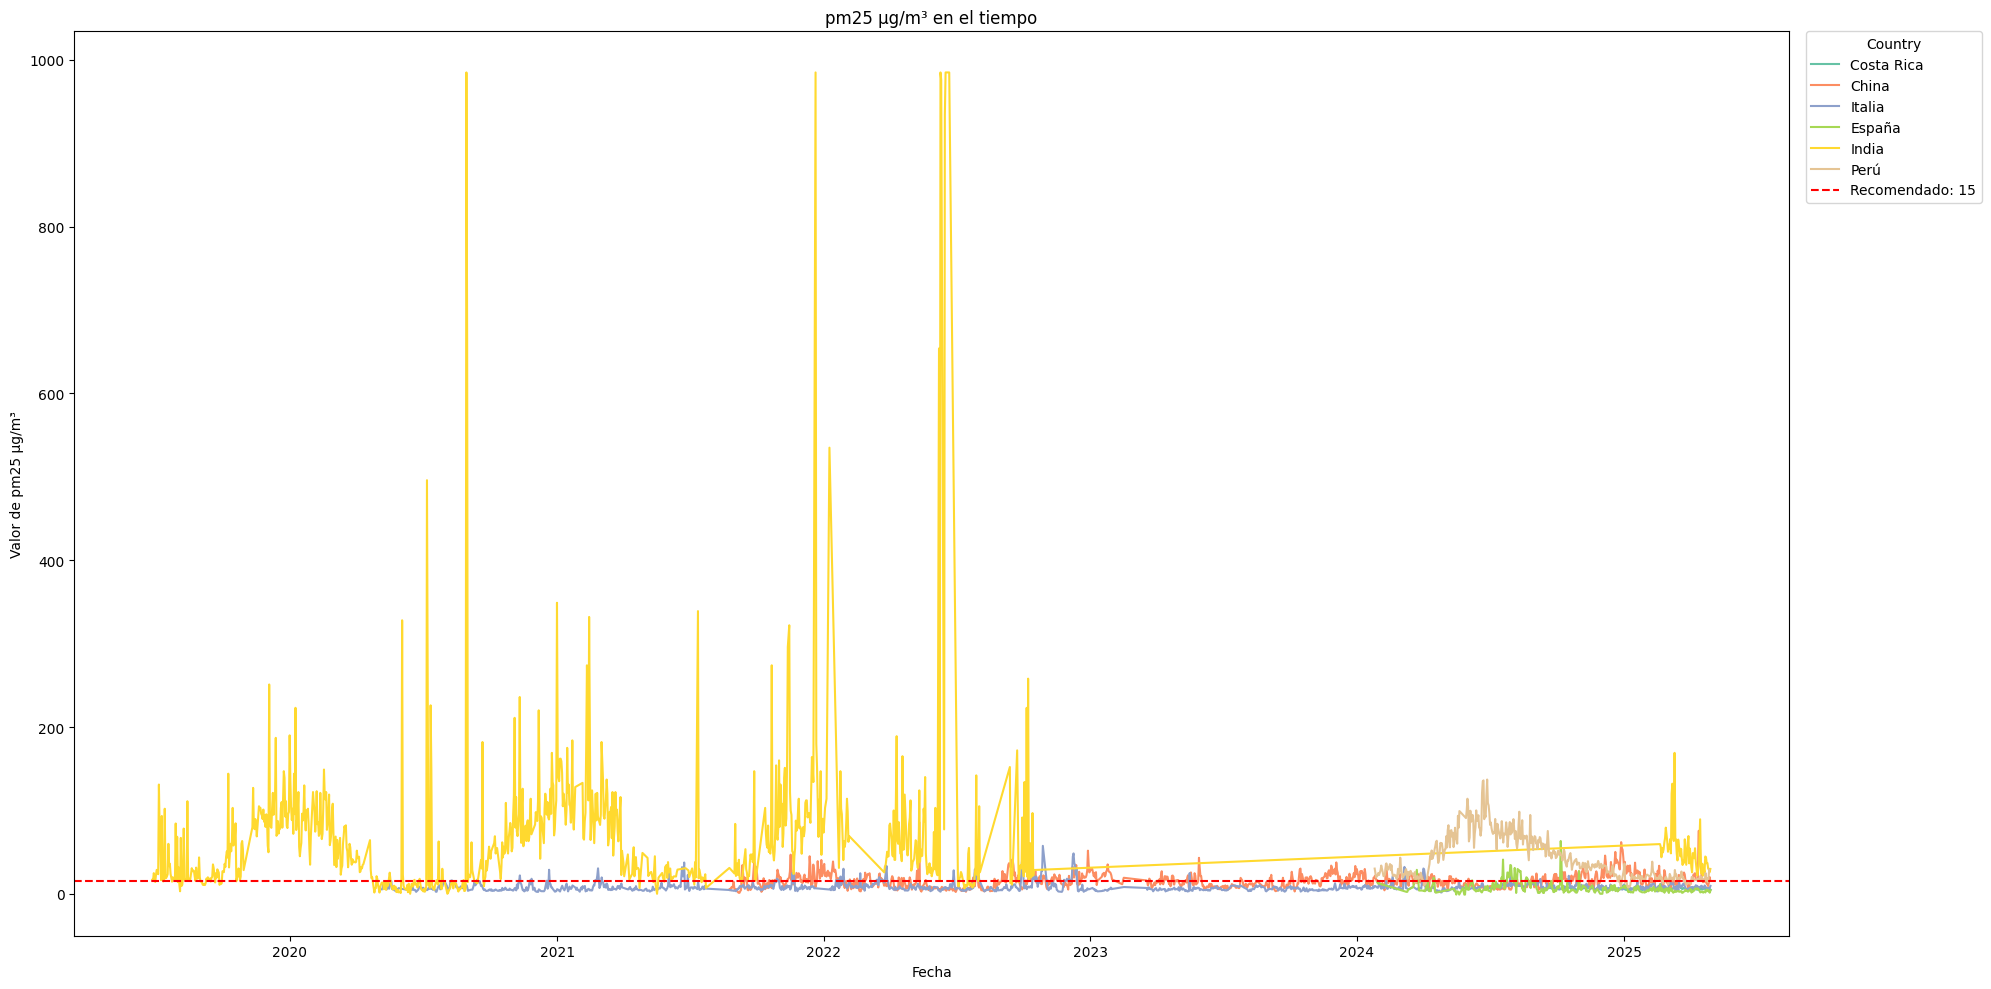

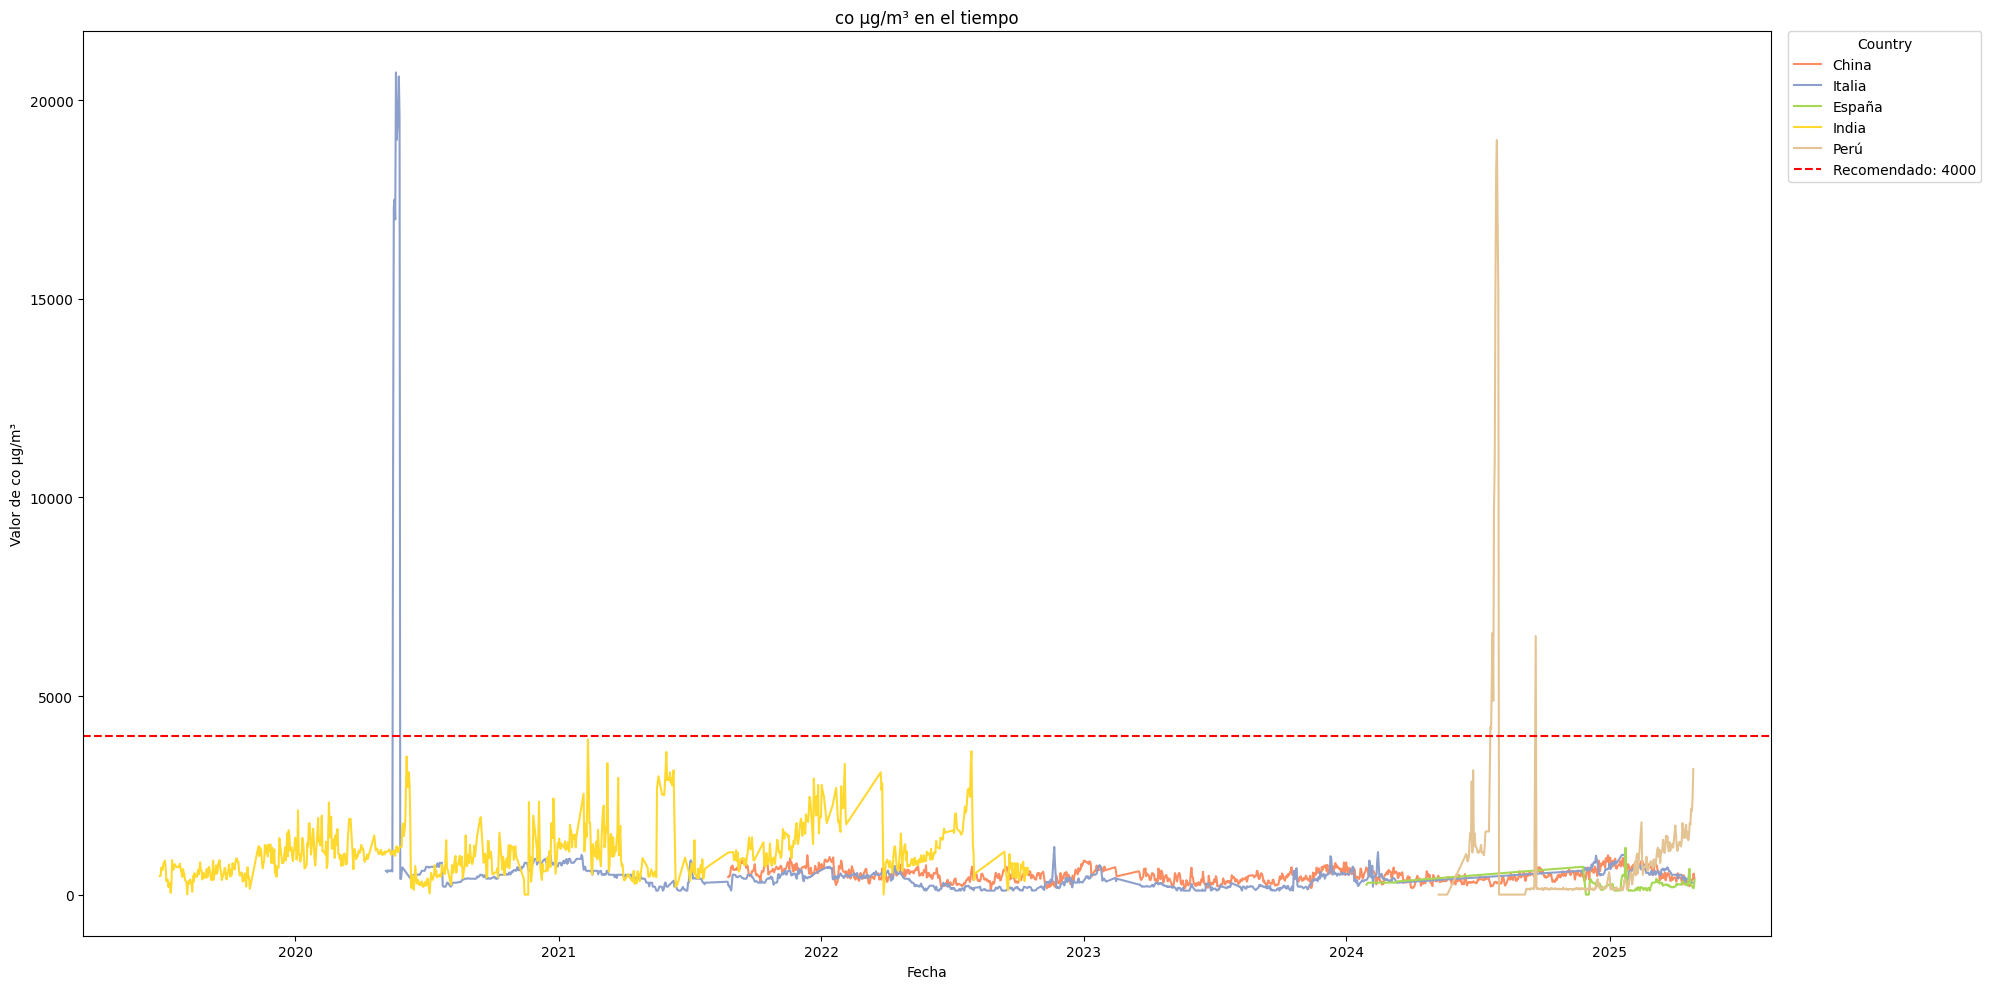

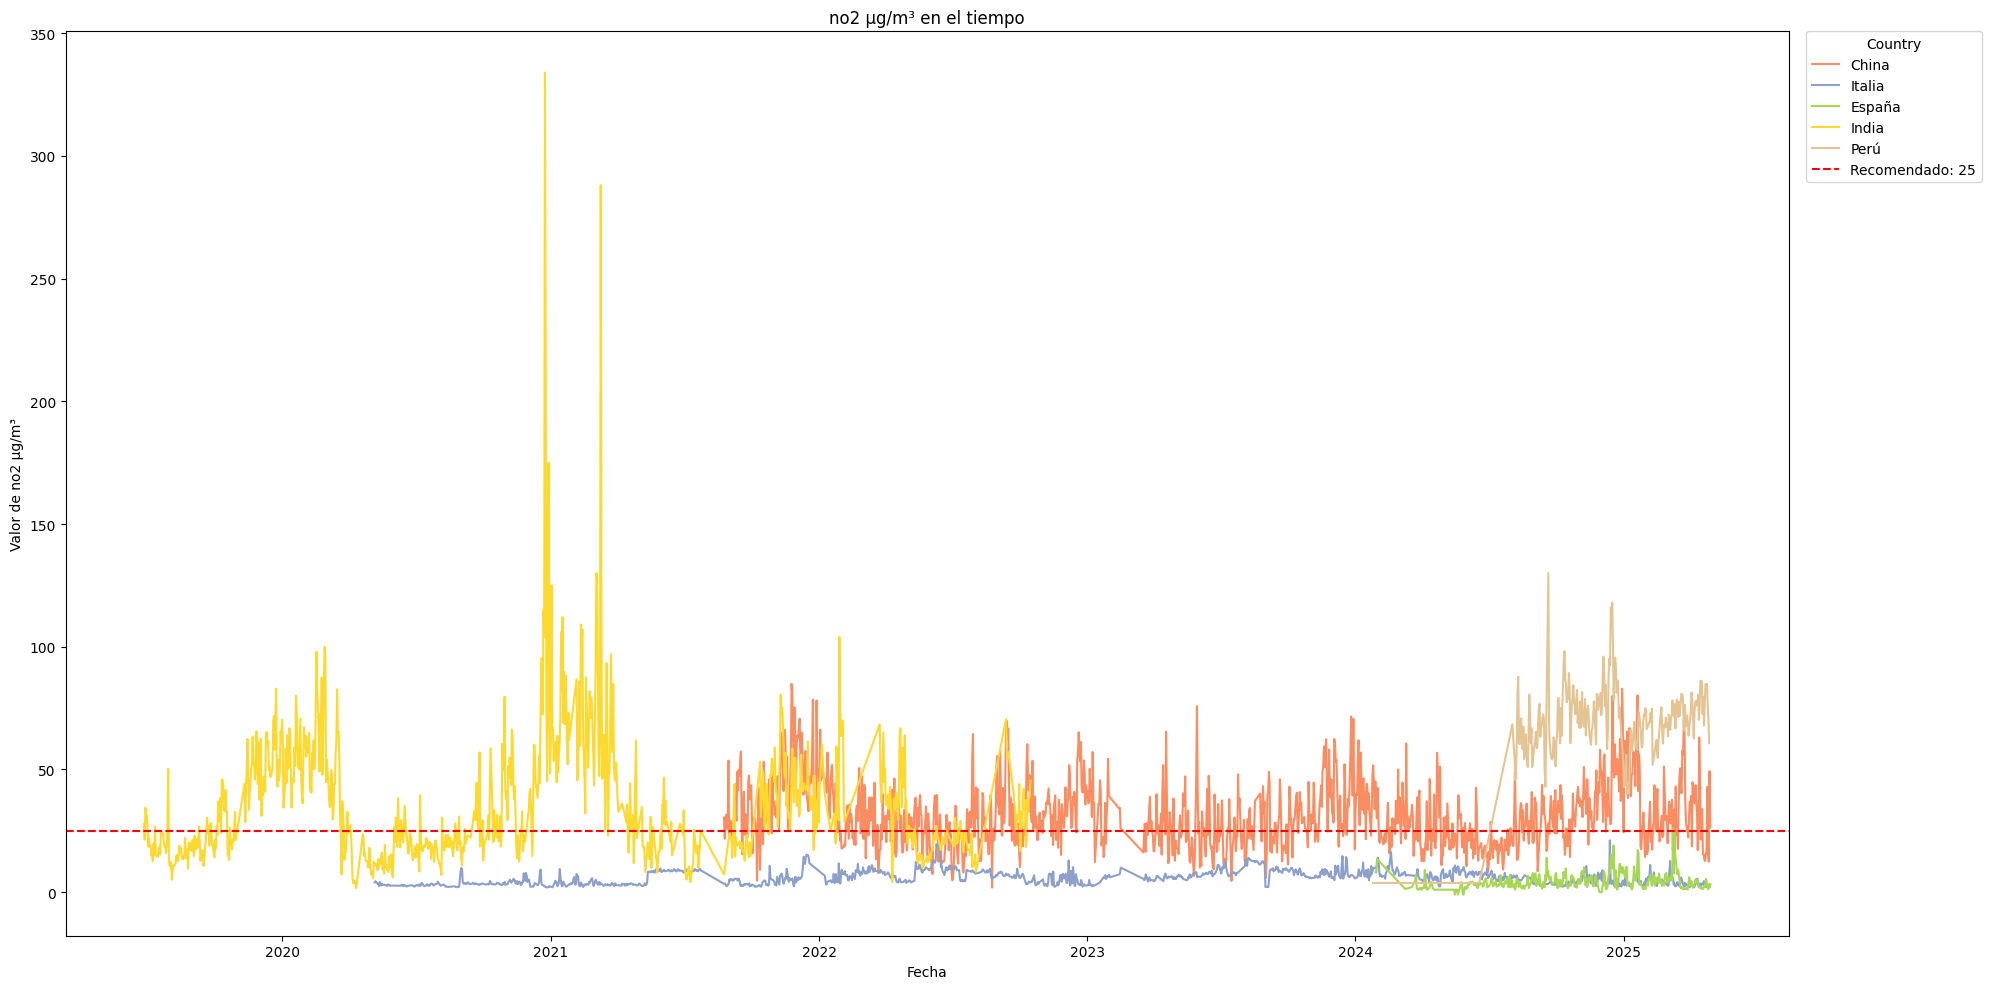

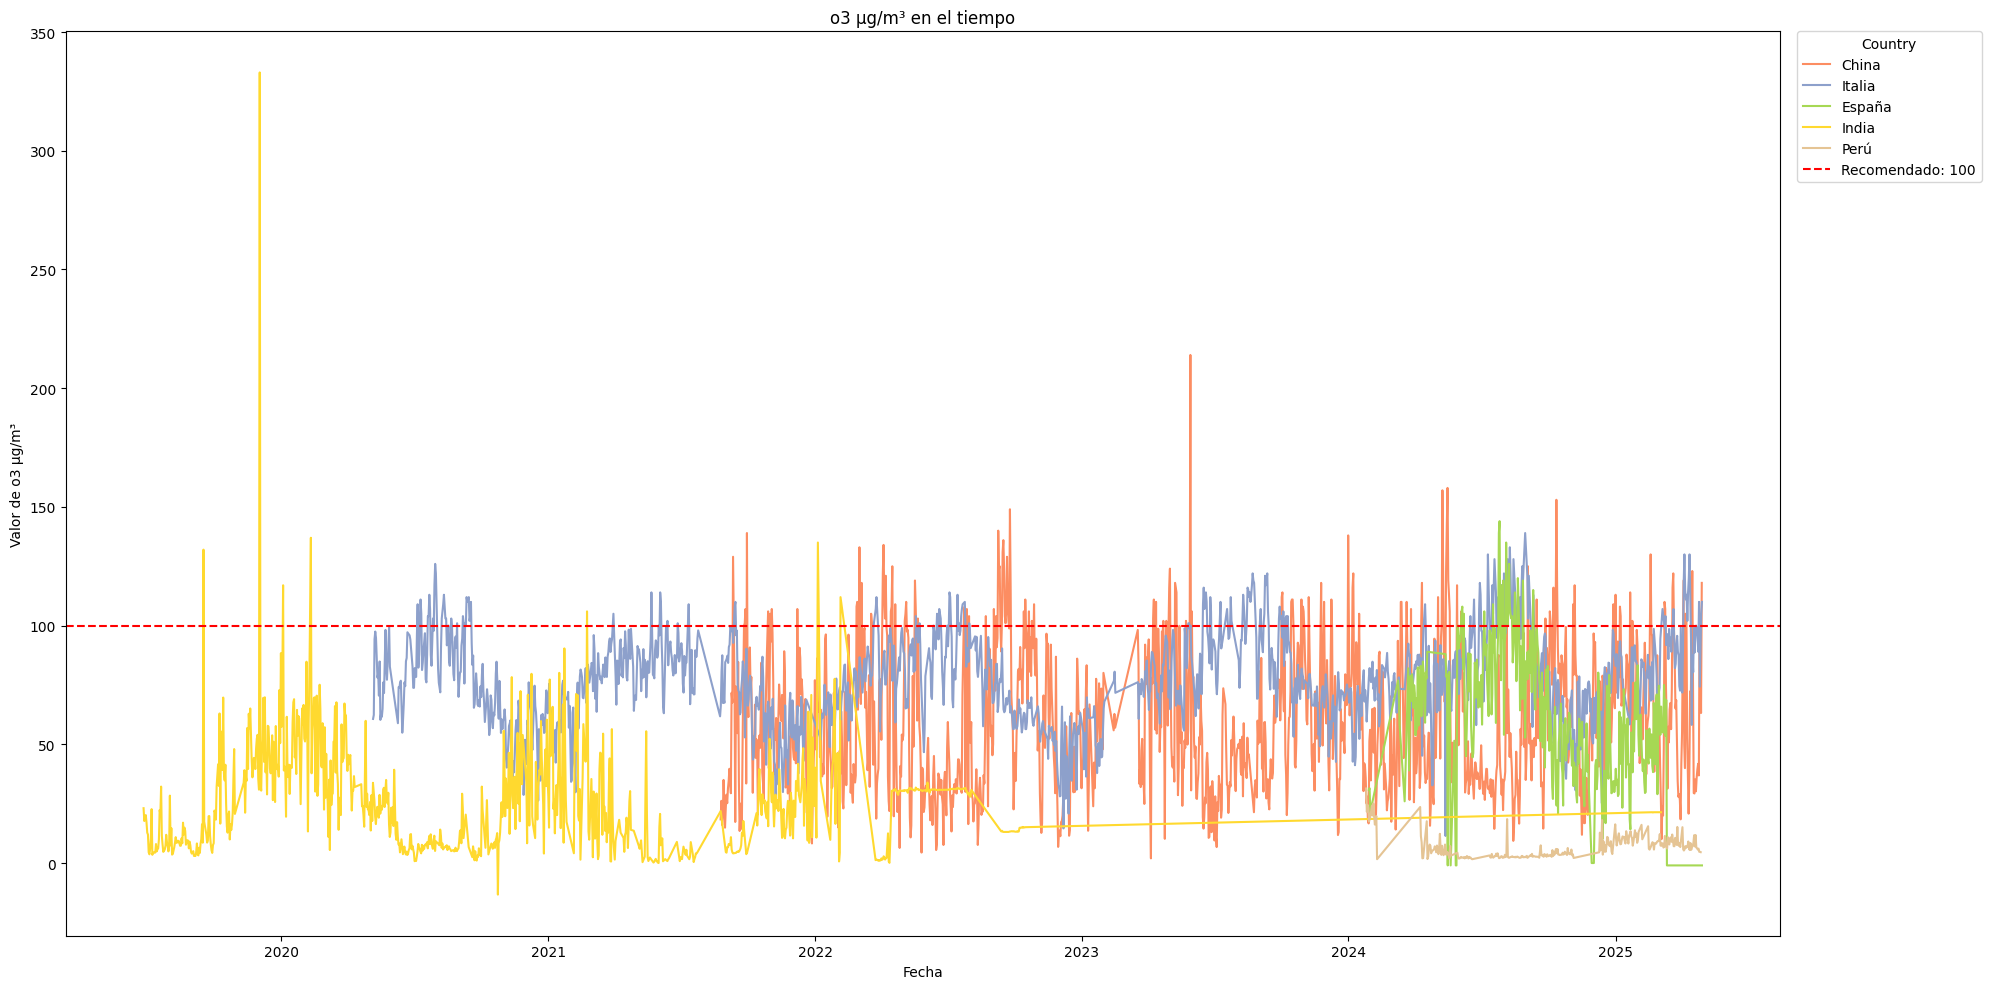

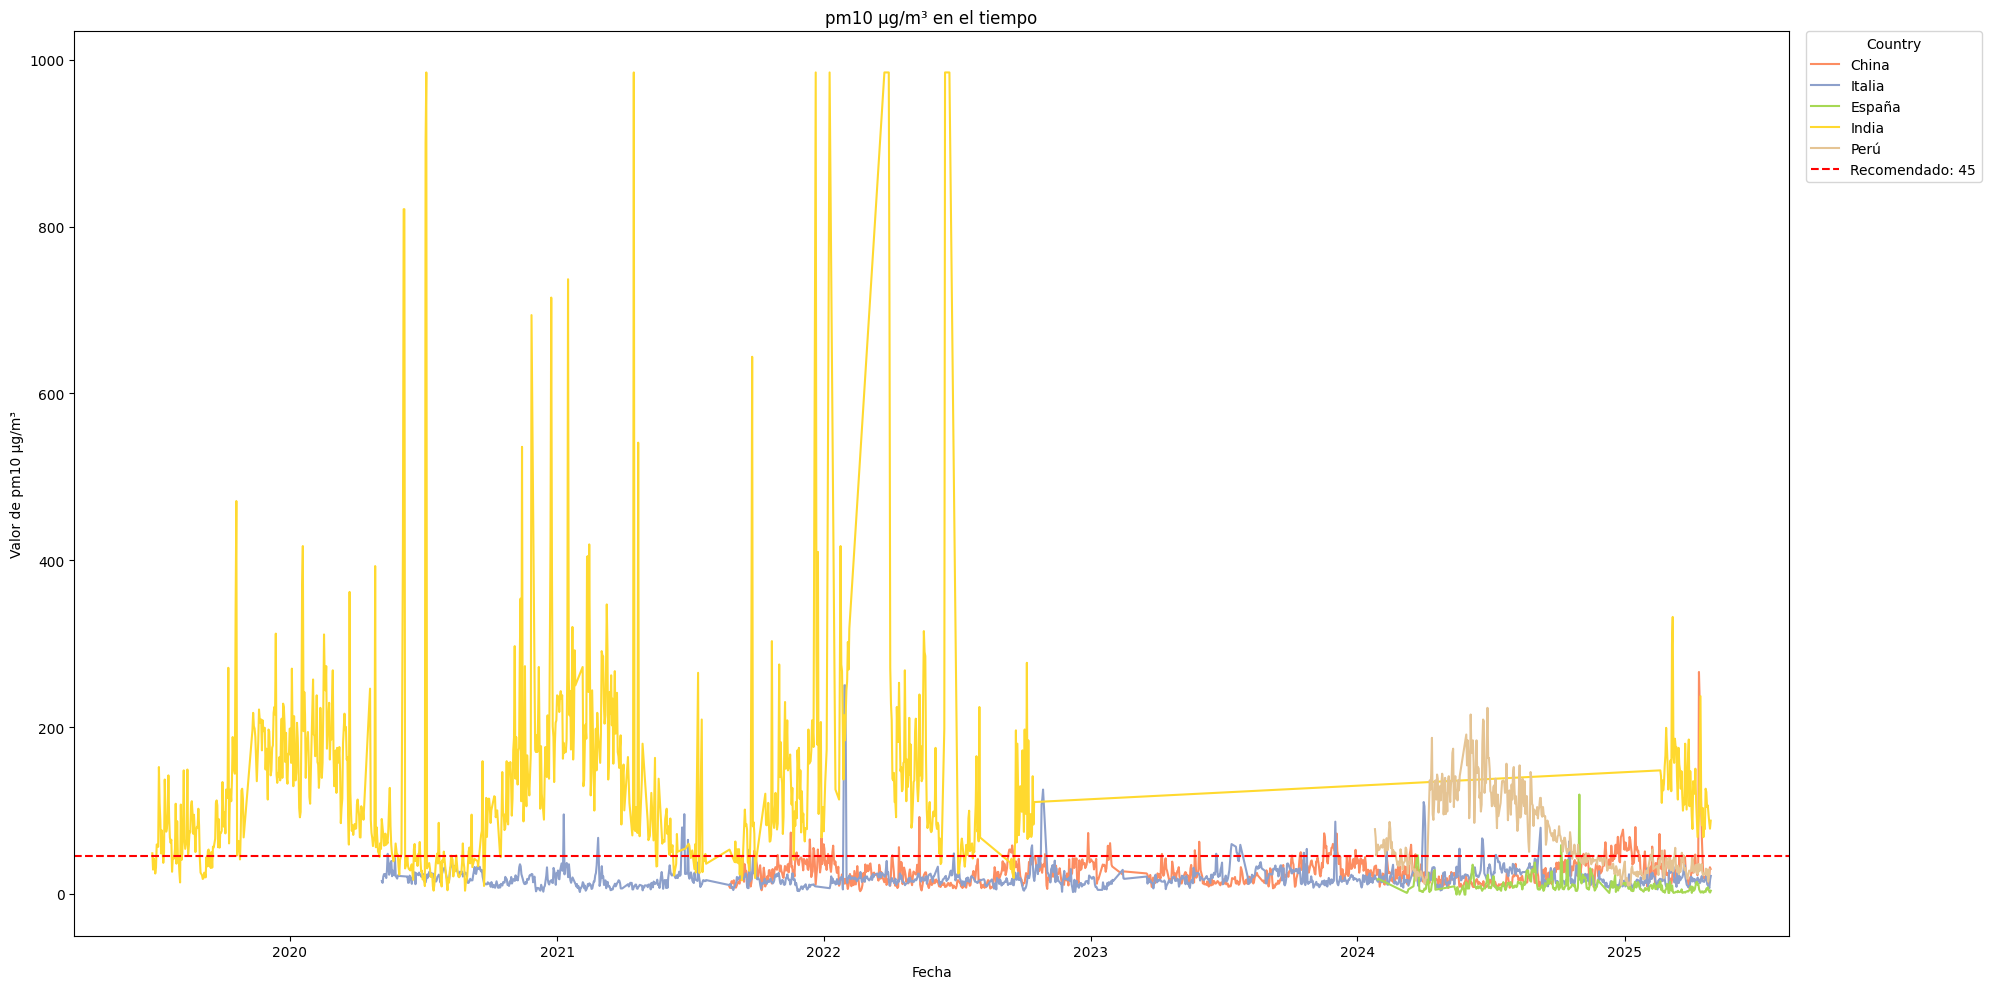

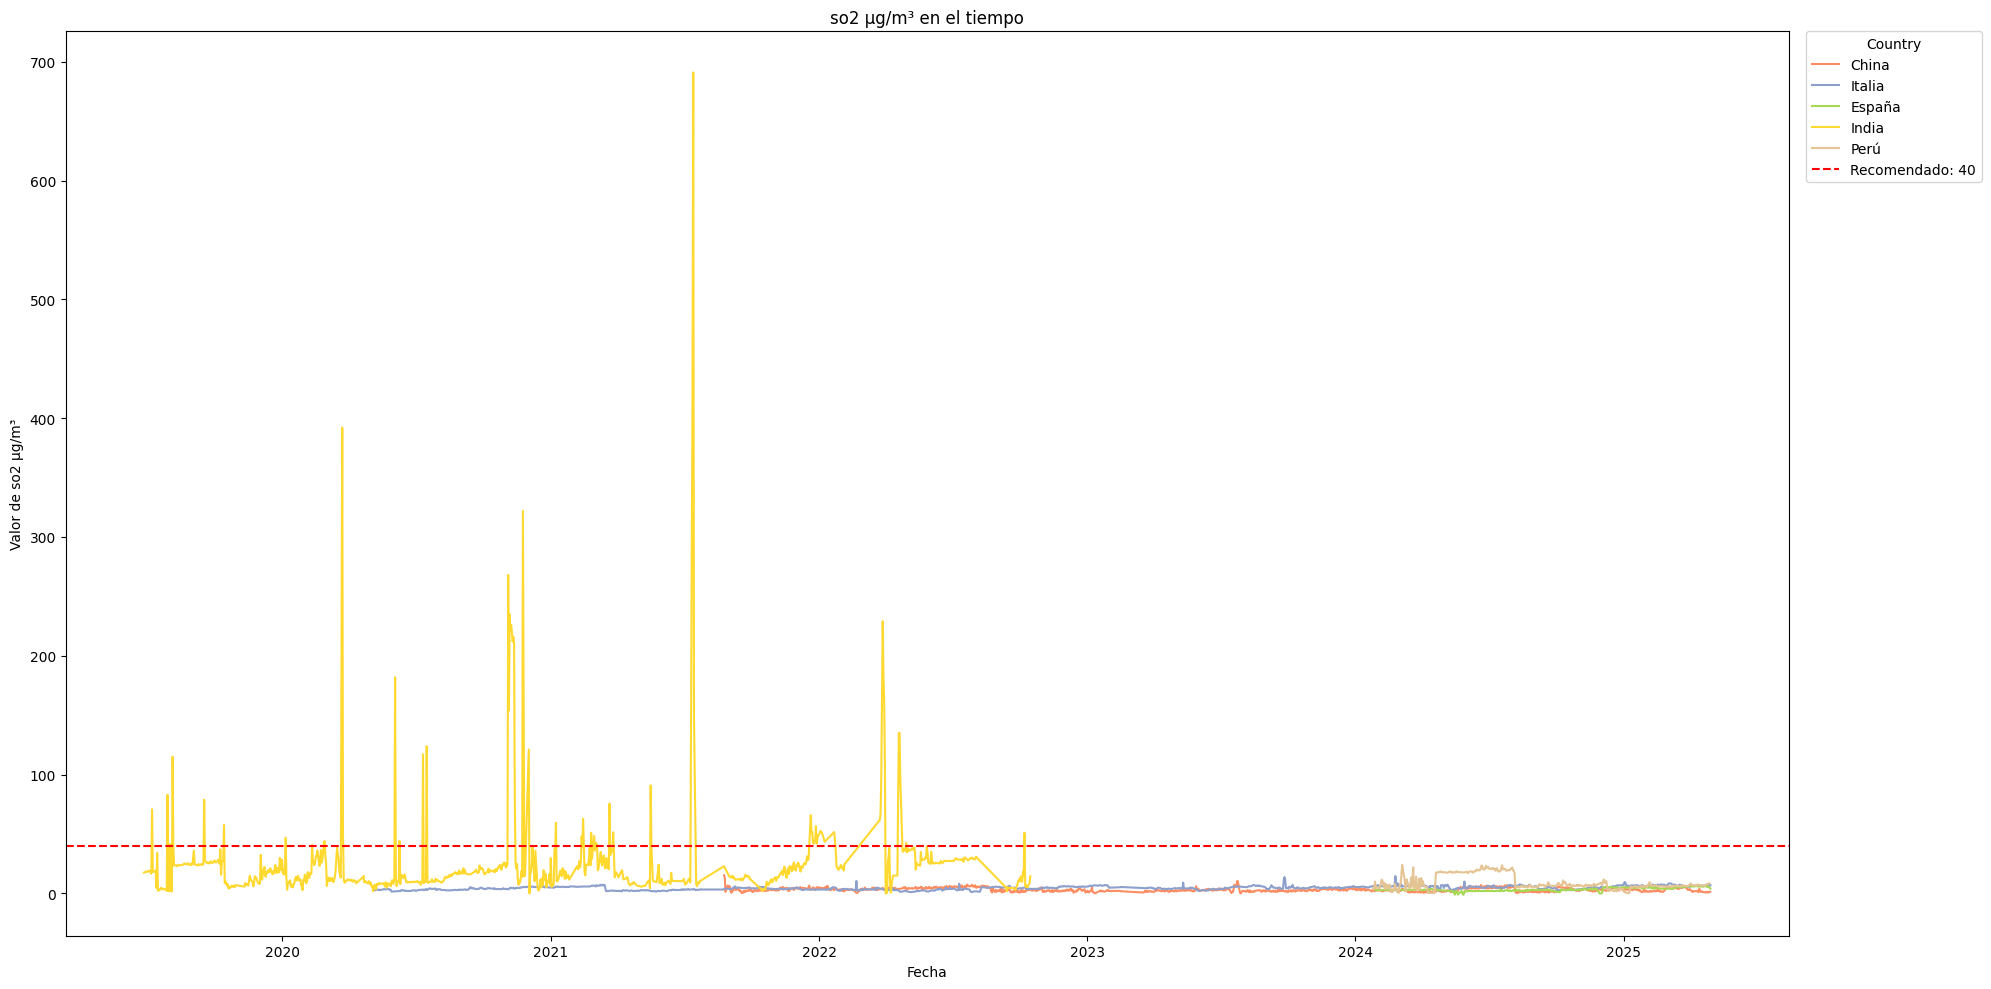

In [ ]:
df_countries = []

for country in locations_dfs:
    df_countries.append(
        country[["country_name", "from_date", "parameter_name", "value"]].copy()
    )

parameters = different_parameters

for parameter in parameters:
    plt.figure(figsize=(20, 10))

    # Get the recommended value for the current parameter
    recommended_value = recommended_values_df[
        recommended_values_df["parameter_name"] == parameter
    ]["recommended_value"].values[0]

    # Plot the lines for each country
    for i, df in enumerate(df_countries):
        df_param = df[df["parameter_name"] == parameter]

        if not df_param.empty:
            df_param.loc[:, "from_date"] = pd.to_datetime(df_param["from_date"])
            df_param = df_param.sort_values(by="from_date")

            color = locations_color_map[df_param["country_name"].unique()[0]]

            plt.plot(
                df_param["from_date"],
                df_param["value"],
                label=df_param["country_name"].iloc[0],
                color=color,
            )

    # Plot the dotted line for the recommended value last so it appears on top
    plt.axhline(
        y=recommended_value,
        color="red",
        linestyle="--",
        label=f"Recomendado: {recommended_value}",
    )

    plt.title(f"{parameter} en el tiempo")
    plt.legend(
        title="Country", bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0
    )

    plt.xlabel("Fecha")
    plt.ylabel(f"Valor de {parameter}")
    plt.tight_layout()
    plt.show()

Cabe resaltar que para observando los datos a traves del tiempo con respecto a las medidas recomendadas de la Organización mundial de la salud, para el indicador de pm2.5, excluyendo a India, los países se mantienne bajo el límite a excepción de algunos picos en ciertas ocasiones.

Para el indicador de co, todos los países parecen estar cumpliendo con el límite de la OMS, sin embargo, en el caso de Italia y Perú se pueden observar picos que superan el límite recomendado en momentos muy específicos.

Para el indicador o3 el comportamiento en general parace recurrentemen tener picos que superan el límite recomendado por la OMS a excepción de Peru que parece estar por debajo del límite en todo momento.

Para el indicador de pm10, el comportamiento es similar pm2.5 con India superando por mucho el límite recomendado por la OMS, sin embargo los demás país también parecen tener picos que superan los límites recomendados por la OMS en ciertos momentos.

Para el último indicador, el de so2, todos los países parecen estar cumpliendo con el límite recomendado por la OMS, a excepción de mumbai que tiene picos muy altos en ciertos momentos del año.

In [ ]:
from statsmodels.tsa.stattools import adfuller
from typing import Optional


def prepare_time_series_data(
    data: pd.DataFrame,
    parameter_name: str,
    date_col: str = "from_date",
    value_col: str = "value",
    parameter_id_col: str = "parameter_name",
) -> Optional[pd.Series]:
    """
    Filters, cleans, and prepares a time series for a specific parameter
    from a larger DataFrame.

    Args:
        data (pd.DataFrame): Input DataFrame with time series data.
        parameter_name (str): The identifier for the parameter to extract.
        date_col (str): Name of the date/time column.
        value_col (str): Name of the numerical value column.
        parameter_id_col (str): Name of the column identifying the parameter.

    Returns:
        pd.Series: A cleaned pandas Series with a DatetimeIndex, containing
                   the numeric values for the specified parameter, ready for
                   time series analysis. Returns None if preparation fails
                   (e.g., parameter not found, no valid data, etc.).
    """
    # --- 1. Input Validation ---
    required_cols = [date_col, value_col, parameter_id_col]
    if not all(col in data.columns for col in required_cols):
        missing = [col for col in required_cols if col not in data.columns]
        logging.error(f"Missing required columns for preparation: {missing}. Aborting.")
        return

    # --- 2. Filter by Parameter ---
    param_df = data[data[parameter_id_col] == parameter_name].copy()
    if param_df.empty:
        logging.warning(
            f"No data found for parameter: '{parameter_name}' in column '{parameter_id_col}'."
        )
        return

    # --- 3. Handle Dates ---
    param_df[date_col] = pd.to_datetime(param_df[date_col], errors="coerce")
    param_df.dropna(
        subset=[date_col],
        inplace=True,
    )  # Drop rows where date conversion failed
    if param_df.empty:
        logging.warning(
            f"No valid dates found in '{date_col}' for parameter '{parameter_name}' after conversion."
        )
        return

    # --- 4. Sort by Date and Set Index ---
    param_df.sort_values(by=date_col, inplace=True)
    param_df.set_index(date_col, inplace=True)

    # --- 5. Prepare Value Series ---
    value_series = pd.to_numeric(param_df[value_col], errors="coerce").dropna()
    if value_series.empty:
        logging.warning(
            f"No valid numeric data in '{value_col}' for parameter '{parameter_name}' after dropping NaNs."
        )
        return

    return value_series


def test_stationarity_on_time_serie(
    df: pd.DataFrame,
    parameter_name: str,
    date_col: str = "from_date",
    value_col: str = "value",
    parameter_id_col: str = "parameter_name",
    alpha: float = 0.05,
) -> dict:
    """
    Prepares time series data using `prepare_time_series_data` and then
    performs the Augmented Dickey-Fuller (ADF) test for stationarity.

    Args:
        df (pd.DataFrame): Input DataFrame with time series data.
        parameter_name (str): The identifier for the parameter to test.
        date_col (str): Name of the date/time column.
        value_col (str): Name of the numerical value column.
        parameter_id_col (str): Name of the column identifying the parameter.
        alpha (float): Significance level for the ADF test.

    Returns:
        dict: ADF test results or a dictionary indicating preparation failure.
              Keys include 'parameter', 'adf_statistic', 'p_value', 'lags_used',
              'n_observations', 'critical_values', 'is_stationary', 'message'.
              'is_stationary' will be None if the test couldn't be run.
    """
    logging.info(f"Starting stationarity test for parameter: '{parameter_name}'")

    # --- 1. Prepare Data ---
    value_series = prepare_time_series_data(
        data=df,
        parameter_name=parameter_name,
        date_col=date_col,
        value_col=value_col,
        parameter_id_col=parameter_id_col,
    )

    # --- 2. Check Preparation Outcome ---
    if value_series is None:
        return

    # --- 3. Check Minimum Observations for ADF ---
    min_obs = 10  # Practical minimum for a somewhat reliable ADF test
    if len(value_series) < min_obs:
        msg = f"Insufficient data points ({len(value_series)} < {min_obs}) for reliable ADF test after preparation."
        logging.warning(msg)
        return

    # --- 4. Perform ADF Test ---
    logging.info(f"Performing ADF test on prepared series for '{parameter_name}'...")
    adf_result = adfuller(value_series)

    # Extract results
    p_value = adf_result[1]
    is_stationary = p_value < alpha

    results = {
        "parameter": parameter_name,
        "adf_statistic": float(adf_result[0].round(4)),
        "p_value": float(p_value.round(4)),
        "lags_used": int(adf_result[2]),
        "n_observations": adf_result[3],
        "critical_values": {
            key: float(value.round(4)) for key, value in adf_result[4].items()
        },
        "is_stationary": bool(is_stationary),
        "message": f"ADF test completed. Series is {'stationary' if is_stationary else 'non-stationary'} at alpha={alpha}.",
    }
    logging.info(
        f"ADF test for '{parameter_name}' completed. p-value: {p_value:.4f}. Stationary: {is_stationary}"
    )
    return results

In [ ]:
for i in range(len(parameters)):
    print(f"{i} - Análisis de estacionalidad para parámetro {parameters[i]}")
    for df in locations_dfs:
        print("---" * 10)
        print(f"location: {df['country_name'][0]}, {df['location_name'][0]}")
        pprint(test_stationarity_on_time_serie(df, parameter_name=parameters[i]))
        print("", end="\n\n")

    print("", end="\n\n")

0 - Análisis de estacionalidad para parámetro pm25 µg/m³
------------------------------
location: Costa Rica, San José, San Pedro, Montes de Oca
{'adf_statistic': -5.6825,
 'critical_values': {'1%': -3.4627, '10%': -2.5743, '5%': -2.8757},
 'is_stationary': True,
 'lags_used': 0,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 205,
 'p_value': 0.0,
 'parameter': 'pm25 µg/m³'}


------------------------------
location: China, Hong Kong, North
{'adf_statistic': -8.4285,
 'critical_values': {'1%': -3.4355, '10%': -2.568, '5%': -2.8638},
 'is_stationary': True,
 'lags_used': 4,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 1276,
 'p_value': 0.0,
 'parameter': 'pm25 µg/m³'}


------------------------------
location: Italia, Marche, Genga -Parco Gola della Rossa
{'adf_statistic': -15.1986,
 'critical_values': {'1%': -3.4346, '10%': -2.5678, '5%': -2.8634},
 'is_stationary': True,
 'lags_used': 1,
 'message'

{'adf_statistic': -4.3584,
 'critical_values': {'1%': -3.4355, '10%': -2.568, '5%': -2.8638},
 'is_stationary': True,
 'lags_used': 9,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 1276,
 'p_value': 0.0004,
 'parameter': 'co µg/m³'}


------------------------------
location: Italia, Marche, Genga -Parco Gola della Rossa
{'adf_statistic': -9.1647,
 'critical_values': {'1%': -3.4354, '10%': -2.568, '5%': -2.8638},
 'is_stationary': True,
 'lags_used': 2,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 1295,
 'p_value': 0.0,
 'parameter': 'co µg/m³'}


------------------------------
location: España, Madrid, Villa del Prado
{'adf_statistic': -5.4176,
 'critical_values': {'1%': -3.4719, '10%': -2.5765, '5%': -2.8798},
 'is_stationary': True,
 'lags_used': 0,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 160,
 'p_value': 0.0,
 'parameter': 'co µg/m³'}


---------

{'adf_statistic': -3.5325,
 'critical_values': {'1%': -3.4347, '10%': -2.5678, '5%': -2.8635},
 'is_stationary': True,
 'lags_used': 18,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 1498,
 'p_value': 0.0072,
 'parameter': 'no2 µg/m³'}


------------------------------
location: España, Madrid, Villa del Prado
{'adf_statistic': -7.4507,
 'critical_values': {'1%': -3.4481, '10%': -2.5709, '5%': -2.8693},
 'is_stationary': True,
 'lags_used': 1,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 372,
 'p_value': 0.0,
 'parameter': 'no2 µg/m³'}


------------------------------
location: India, Mahape, Navi Mumbai
{'adf_statistic': -3.4684,
 'critical_values': {'1%': -3.4378, '10%': -2.5685, '5%': -2.8648},
 'is_stationary': True,
 'lags_used': 12,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 883,
 'p_value': 0.0088,
 'parameter': 'no2 µg/m³'}


-------------------

{'adf_statistic': -0.9767,
 'critical_values': {'1%': -3.4485, '10%': -2.571, '5%': -2.8696},
 'is_stationary': False,
 'lags_used': 11,
 'message': 'ADF test completed. Series is non-stationary at alpha=0.05.',
 'n_observations': 362,
 'p_value': 0.7617,
 'parameter': 'o3 µg/m³'}


------------------------------
location: India, Mahape, Navi Mumbai
{'adf_statistic': -3.0907,
 'critical_values': {'1%': -3.4377, '10%': -2.5685, '5%': -2.8648},
 'is_stationary': True,
 'lags_used': 13,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 890,
 'p_value': 0.0273,
 'parameter': 'o3 µg/m³'}


------------------------------
location: Perú, Ayacucho, Pariachi
{'adf_statistic': -3.6911,
 'critical_values': {'1%': -3.452, '10%': -2.5719, '5%': -2.8711},
 'is_stationary': True,
 'lags_used': 6,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 304,
 'p_value': 0.0042,
 'parameter': 'o3 µg/m³'}




4 - Análisis de estaci

{'adf_statistic': -5.3722,
 'critical_values': {'1%': -3.4372, '10%': -2.5684, '5%': -2.8646},
 'is_stationary': True,
 'lags_used': 15,
 'message': 'ADF test completed. Series is stationary at alpha=0.05.',
 'n_observations': 955,
 'p_value': 0.0,
 'parameter': 'pm10 µg/m³'}


------------------------------
location: Perú, Ayacucho, Pariachi
{'adf_statistic': -1.335,
 'critical_values': {'1%': -3.4459, '10%': -2.5704, '5%': -2.8684},
 'is_stationary': False,
 'lags_used': 6,
 'message': 'ADF test completed. Series is non-stationary at alpha=0.05.',
 'n_observations': 424,
 'p_value': 0.613,
 'parameter': 'pm10 µg/m³'}




5 - Análisis de estacionalidad para parámetro so2 µg/m³
------------------------------
location: Costa Rica, San José, San Pedro, Montes de Oca
None


------------------------------
location: China, Hong Kong, North
{'adf_statistic': -4.221,
 'critical_values': {'1%': -3.4355, '10%': -2.568, '5%': -2.8638},
 'is_stationary': True,
 'lags_used': 21,
 'message': 'ADF t

**1. Hallazgos Generales sobre Estacionariedad:**

Predominantemente Estacionarias: La gran mayoría de las series de tiempo probadas (24 de 30 series probadas con éxito) resultaron ser estacionarias al nivel de significancia del 5% (alfa=0.05). Esto indica que para la mayoría de los contaminantes y ubicaciones, las propiedades estadísticas subyacentes (como la media y la varianza) no exhiben el tipo específico de no estacionariedad (raíz unitaria) que busca la prueba ADF.

Series No Estacionarias Identificadas: Se identificaron claramente seis series específicas como no estacionarias, lo que sugiere la presencia de tendencias o comportamiento similar a un paseo aleatorio (random walk):

Perú, Ayacucho, Pariachi: PM2.5, NO2, PM10, SO2

España, Madrid, Villa del Prado: O3, SO2

**2. Observaciones Específicas por Ubicación:**

Perú (Ayacucho, Pariachi): Esta ubicación muestra la mayor no estacionariedad, con PM2.5, NO2, PM10 y SO2 fallando la prueba. Esto sugiere fuertemente tendencias significativas o un comportamiento inestable para estos contaminantes clave en este sitio. Sin embargo, CO y O3 resultaron estacionarios aquí.

España (Madrid, Villa del Prado): Este sitio mostró no estacionariedad específicamente para los contaminantes gaseosos O3 y SO2. PM2.5, CO, NO2 y PM10 fueron estacionarios. Esto apunta hacia posibles factores impulsores o tendencias diferentes que afectan a O3 y SO2 en comparación con los otros en esta ubicación específica.

Otras Ubicaciones (Costa Rica, Hong Kong, Italia, Mumbai): Donde hubo datos disponibles, estas ubicaciones mostraron consistentemente un comportamiento estacionario en todos los contaminantes probados (PM2.5, CO, NO2, O3, PM10, SO2).

**3. Observaciones Específicas por Contaminante:**

PM2.5: Estacionario en todas las ubicaciones excepto Perú.

CO: Estacionario en todas las ubicaciones donde se probó.

NO2: Estacionario en todas las ubicaciones excepto Perú.

O3: Estacionario en la mayoría de las ubicaciones, pero no estacionario en Madrid.

PM10: Estacionario en todas las ubicaciones excepto Perú.

SO2: Mostró la no estacionariedad más frecuente, fallando la prueba tanto en Perú como en Madrid.


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import Optional


def _plot_time_series_with_rolling_stats(
    value_series: pd.Series,
    parameter_name: str,
    location_title: str,
    value_col: str,
    window: Optional[int],
) -> None:
    """Plots the time series and its rolling mean/std dev. Logs error and returns on failure."""
    try:
        plt.style.use("seaborn-v0_8-whitegrid")
        fig, ax = plt.subplots(figsize=(12, 6))

        # Plot original series
        ax.plot(
            value_series.index,
            value_series,
            label="Serie original",
            color="lightblue",
            linewidth=1.5,
        )

        # Plot rolling stats if window is valid
        if window and window < len(value_series):
            # Calculate rolling stats (errors caught by outer try/except)
            rolling_mean = value_series.rolling(window=window).mean()
            rolling_std = value_series.rolling(window=window).std()
            ax.plot(
                rolling_mean.index,
                rolling_mean,
                label=f"Promedio Móvil (w={window})",
                color="darkorange",
                linewidth=2,
            )
            ax.plot(
                rolling_std.index,
                rolling_std,
                label=f"Desviación Estándar Móvil (w={window})",
                color="darkgreen",
                linewidth=2,
            )
            ax.legend(loc="best")
        elif window:
            logging.info(
                f"Rolling stats skipped for {parameter_name} at {location_title} (window {window} >= length {len(value_series)})"
            )

        ax.set_title(
            f"Serie de Tiempo y Estadísticas Moviles: {parameter_name}\n({location_title})",
            fontsize=14,
        )
        ax.set_xlabel("Fecha", fontsize=12)
        ax.set_ylabel(f"Valor ({value_col})", fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

    except Exception as e:
        logging.error(
            f"Failed to generate time series plot for {parameter_name} at {location_title}: {e}"
        )
        # Ensure the potentially created figure is closed on error
        try:
            plt.close(fig)
        except Exception:  # Catch any other closing errors
            pass
        return  # Exit function on error


def _plot_seasonal_decomposition(
    value_series: pd.Series,
    parameter_name: str,
    location_title: str,
    seasonal_period: int,
    decomp_model: str,
) -> None:
    """Plots the seasonal decomposition components. Logs error and returns on failure."""
    fig_decomp = None
    try:
        min_obs_decomp = 2 * seasonal_period
        if len(value_series) < min_obs_decomp:
            logging.warning(
                f"Skipping decomp plot: Insufficient data ({len(value_series)} < {min_obs_decomp}) for {parameter_name} at {location_title}."
            )
            return

        # Attempt to fill gaps and decompose
        series_for_decomp = value_series.asfreq(
            pd.infer_freq(value_series.index), method="ffill"
        )
        if series_for_decomp.isnull().any():
            series_for_decomp = value_series.ffill().bfill()  # Fallback fill

        series_clean = series_for_decomp.dropna()
        if len(series_clean) < min_obs_decomp:
            logging.warning(
                f"Skipping decomp plot: Insufficient data after cleaning ({len(series_clean)} < {min_obs_decomp}) for {parameter_name} at {location_title}."
            )
            return

        decomposition = seasonal_decompose(
            series_clean, model=decomp_model, period=seasonal_period
        )
        fig_decomp = decomposition.plot()
        fig_decomp.set_size_inches(10, 8)
        fig_decomp.suptitle(
            f"Descomposición: {parameter_name}\n({location_title} - Periodo={seasonal_period}, Modelo={decomp_model})",
            y=1.03,
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
        plt.close(fig_decomp)

    except Exception as e:
        logging.error(
            f"Failed to generate seasonal decomposition plot for {parameter_name} at {location_title}: {e}"
        )
        if fig_decomp:
            try:
                plt.close(fig_decomp)
            except Exception:
                pass
        return


def _plot_seasonal_boxplot(
    value_series: pd.Series,
    parameter_name: str,
    location_title: str,
    seasonal_period: int,
    value_col: str,
) -> None:
    """Generates a box plot grouped by the seasonal component. Logs error and returns on failure."""
    fig_box = None
    try:
        temp_df = value_series.dropna().to_frame(name=value_col)
        grouping_col = None
        grouping_label = None
        group_map = None
        ordered_groups = None
        x_axis_col = None

        # Determine grouping based on period
        if seasonal_period == 7:
            grouping_col, grouping_label = "dia", "día de la semana"
            temp_df[grouping_col] = temp_df.index.dayofweek
            group_map = {
                0: "Mon",
                1: "Tue",
                2: "Wed",
                3: "Thu",
                4: "Fri",
                5: "Sat",
                6: "Sun",
            }
        elif seasonal_period == 12 and isinstance(temp_df.index, pd.DatetimeIndex):
            grouping_col, grouping_label = "mes", "Mes"
            temp_df[grouping_col] = temp_df.index.month
            group_map = {
                1: "Jan",
                2: "Feb",
                3: "Mar",
                4: "Apr",
                5: "May",
                6: "Jun",
                7: "Jul",
                8: "Aug",
                9: "Sep",
                10: "Oct",
                11: "Nov",
                12: "Dec",
            }
        elif seasonal_period == 365 and isinstance(temp_df.index, pd.DatetimeIndex):
            grouping_col, grouping_label = "mes", "Mes del año"
            temp_df[grouping_col] = temp_df.index.month
            group_map = {
                1: "Jan",
                2: "Feb",
                3: "Mar",
                4: "Apr",
                5: "May",
                6: "Jun",
                7: "Jul",
                8: "Aug",
                9: "Sep",
                10: "Oct",
                11: "Nov",
                12: "Dec",
            }

        if grouping_col and grouping_label and not temp_df.empty:
            if group_map:
                temp_df["group_mapped"] = temp_df[grouping_col].map(group_map)
                ordered_groups = [
                    group_map[i]
                    for i in sorted(group_map.keys())
                    if i in temp_df[grouping_col].unique()
                ]
                temp_df["group_mapped"] = pd.Categorical(
                    temp_df["group_mapped"], categories=ordered_groups, ordered=True
                )
                x_axis_col = "group_mapped"
            else:  # Should not happen with current logic, but fallback
                x_axis_col = grouping_col

            fig_box = plt.figure(figsize=(12, 6))
            sns.boxplot(
                x=x_axis_col,
                y=value_col,
                data=temp_df,
                palette="viridis",
                order=ordered_groups,
                hue=x_axis_col,
            )
            plt.title(
                f"Cajas y bigotes por {grouping_label}: {parameter_name}\n({location_title})",
                fontsize=14,
            )
            plt.xlabel(grouping_label, fontsize=12)
            plt.ylabel(f"Valor ({value_col})", fontsize=12)
            plt.xticks(rotation=45)
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.tight_layout()
            plt.show()
            plt.close(fig_box)  # Close the figure after showing
        elif not grouping_label:
            logging.info(
                f"Box plot grouping not implemented or applicable for period={seasonal_period} for {parameter_name} at {location_title}."
            )

    except Exception as e:
        logging.error(
            f"Failed to generate seasonal box plot for {parameter_name} at {location_title}: {e}"
        )
        if fig_box:
            try:
                plt.close(fig_box)
            except Exception:
                pass
        return


def plot_stationarity_diagnostics_refactored(
    df: pd.DataFrame,
    parameter_name: str,
    country_name: str = "Unknown Country",
    location_name: str = "Unknown Location",
    date_col: str = "from_date",
    value_col: str = "value",
    parameter_id_col: str = "parameter_name",
    window: Optional[int] = None,
) -> None:
    """
    Generates plots to visually assess stationarity by calling helper functions.
    Handles data preparation errors.
    """
    location_title = f"{location_name}, {country_name}"

    value_series = prepare_time_series_data(
        data=df,
        parameter_name=parameter_name,
        date_col=date_col,
        value_col=value_col,
        parameter_id_col=parameter_id_col,
    )

    if value_series is None or value_series.empty:
        logging.warning(
            f"Skipping stationarity plots for {parameter_name} at {location_title}: Data preparation failed or resulted in empty series."
        )
        return

    # Determine window
    if window is None:
        if len(value_series) > 60:
            inferred_freq = pd.infer_freq(value_series.index)
            if inferred_freq and ("D" in inferred_freq or "B" in inferred_freq):
                window = 30
            elif inferred_freq and "W" in inferred_freq:
                window = 4
            elif inferred_freq and "M" in inferred_freq:
                window = 12
            else:
                window = min(30, len(value_series) // 4)
        else:
            window = max(1, len(value_series) // 4)
    if window >= len(value_series):
        window = None

    _plot_time_series_with_rolling_stats(
        value_series=value_series,
        parameter_name=parameter_name,
        location_title=location_title,
        value_col=value_col,
        window=window,
    )


def plot_seasonality_diagnostics_refactored(
    df: pd.DataFrame,
    parameter_name: str,
    seasonal_period: int,
    country_name: str = "Unknown Country",
    location_name: str = "Unknown Location",
    date_col: str = "from_date",
    value_col: str = "value",
    parameter_id_col: str = "parameter_name",
    decomp_model: str = "additive",
) -> None:
    """
    Generates plots to visually assess seasonality by calling helper functions.
    Handles data preparation errors.
    """
    location_title = f"{location_name}, {country_name}"

    if not isinstance(seasonal_period, int) or seasonal_period < 2:
        logging.error(
            f"Invalid seasonal_period ({seasonal_period}) provided for {parameter_name} at {location_title}. Skipping seasonality plots."
        )
        return

    value_series = prepare_time_series_data(
        data=df,
        parameter_name=parameter_name,
        date_col=date_col,
        value_col=value_col,
        parameter_id_col=parameter_id_col,
    )

    if value_series is None or value_series.empty:
        logging.warning(
            f"Skipping seasonality plots for {parameter_name} at {location_title}: Data preparation failed or resulted in empty series."
        )
        return

    _plot_seasonal_decomposition(
        value_series=value_series,
        parameter_name=parameter_name,
        location_title=location_title,
        seasonal_period=seasonal_period,
        decomp_model=decomp_model,
    )
    _plot_seasonal_boxplot(
        value_series=value_series,
        parameter_name=parameter_name,
        location_title=location_title,
        seasonal_period=seasonal_period,
        value_col=value_col,
    )

In [ ]:
parameters

array(['pm25 µg/m³', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³',
       'so2 µg/m³'], dtype=object)

Hagamos un análisis de sobre el comportamiento en el tiempo de uno de los parámetros.

--- Starting Visual Time Series Analysis ---

===== 0 - Visual Analysis for Parameter: pm25 µg/m³ =====

--- Processing: pm25 µg/m³ at San José, San Pedro, Montes de Oca, Costa Rica ---


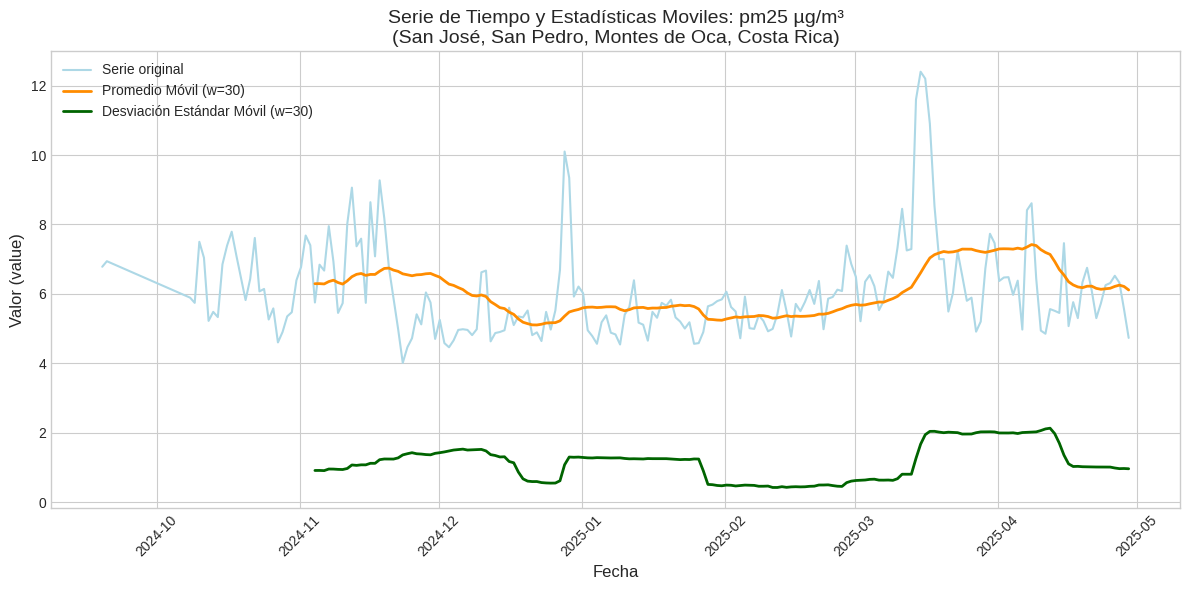

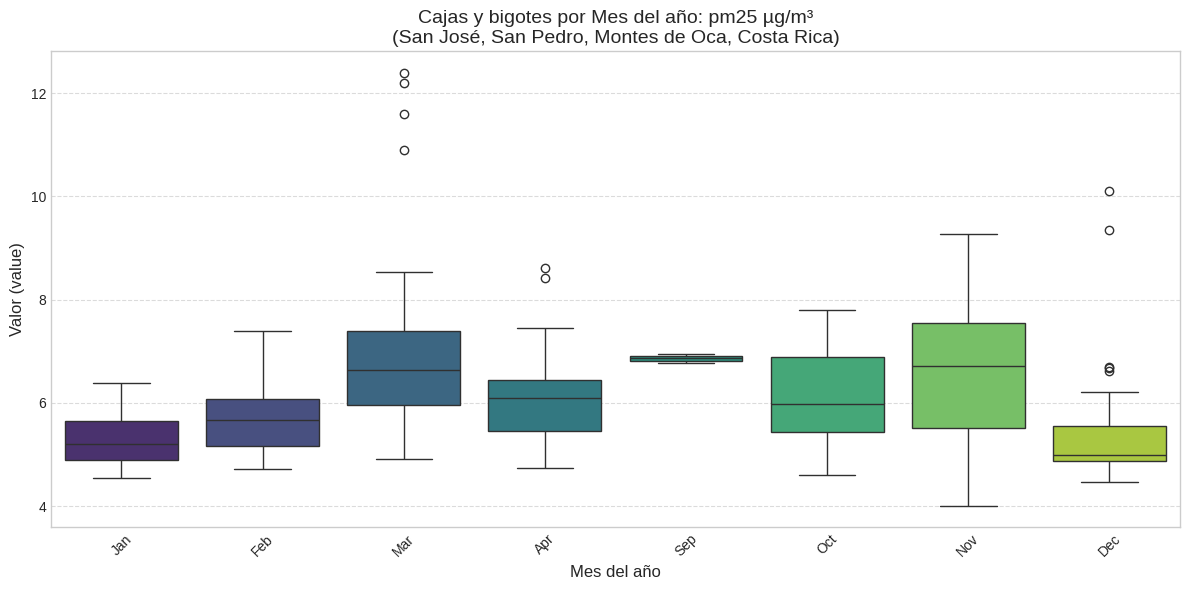


--- Processing: pm25 µg/m³ at Hong Kong, North, China ---


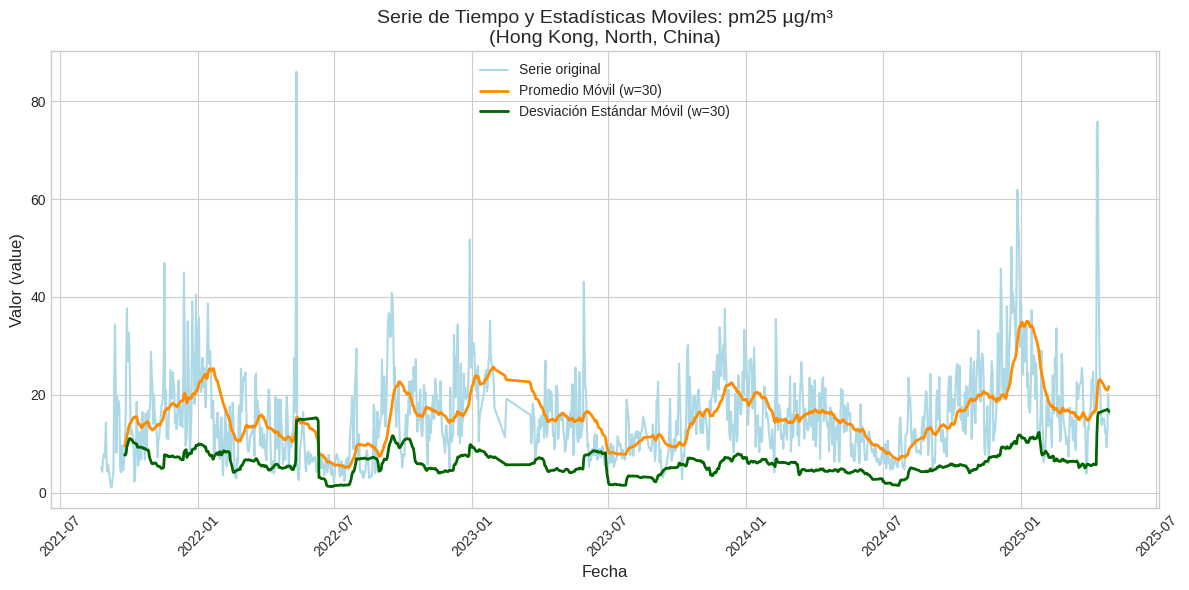

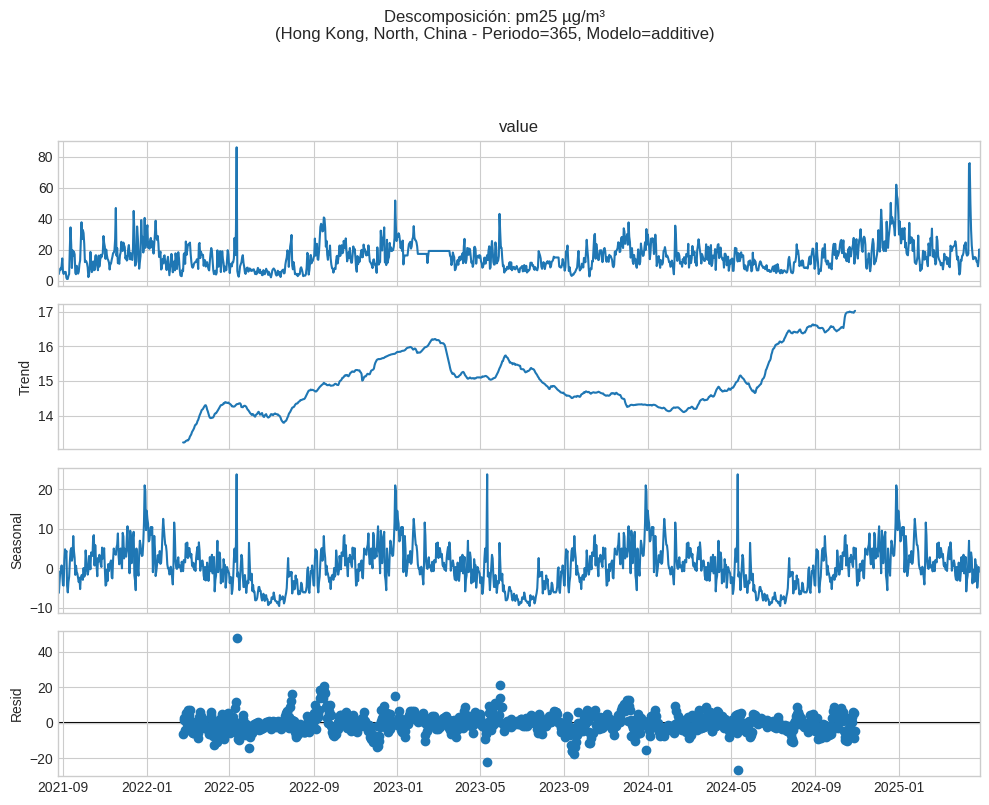

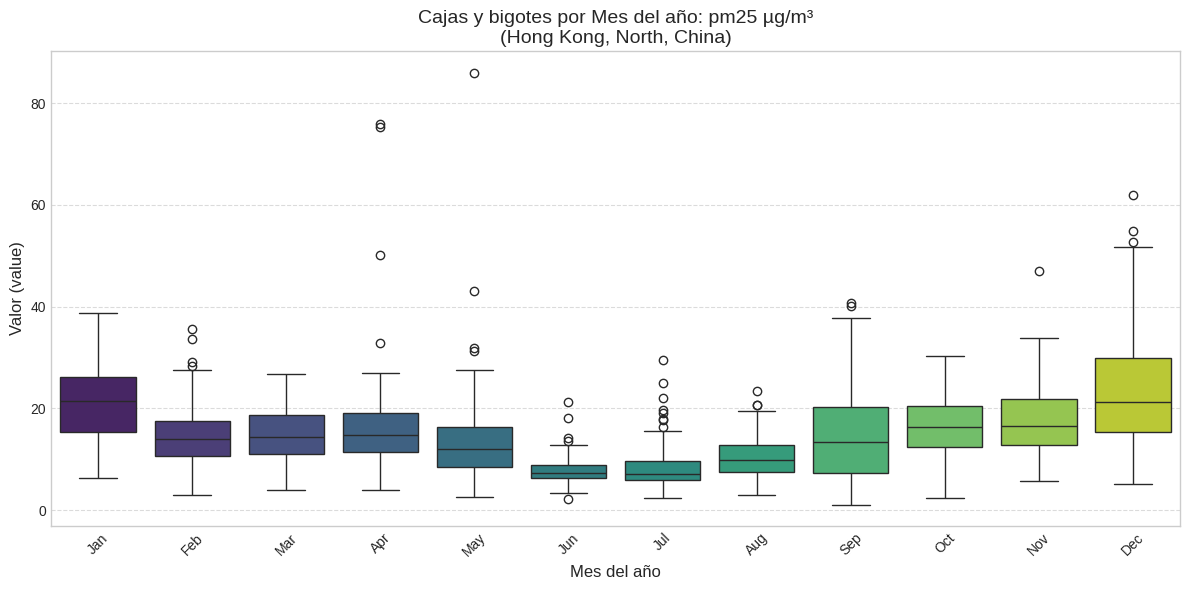


--- Processing: pm25 µg/m³ at Marche, Genga -Parco Gola della Rossa, Italia ---


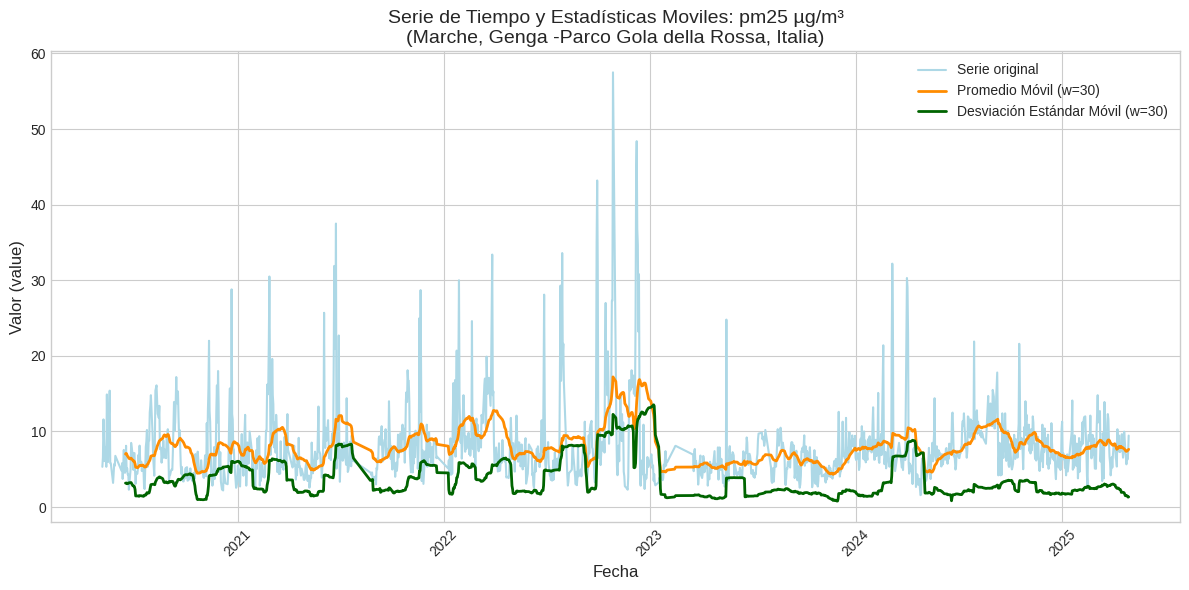

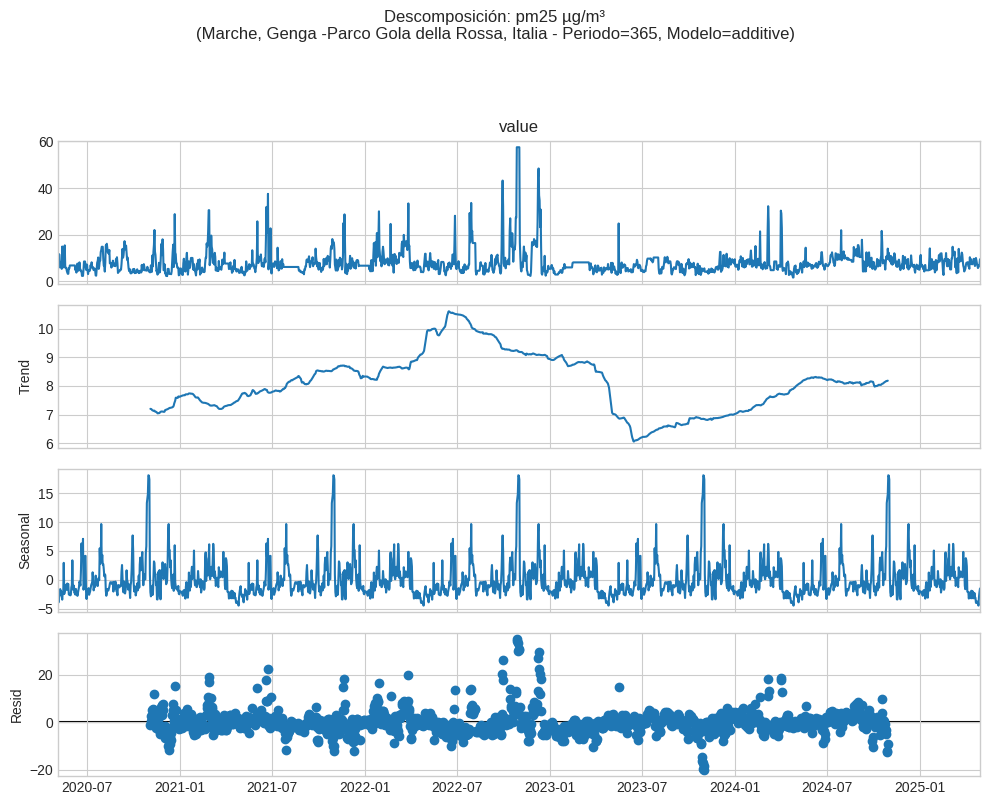

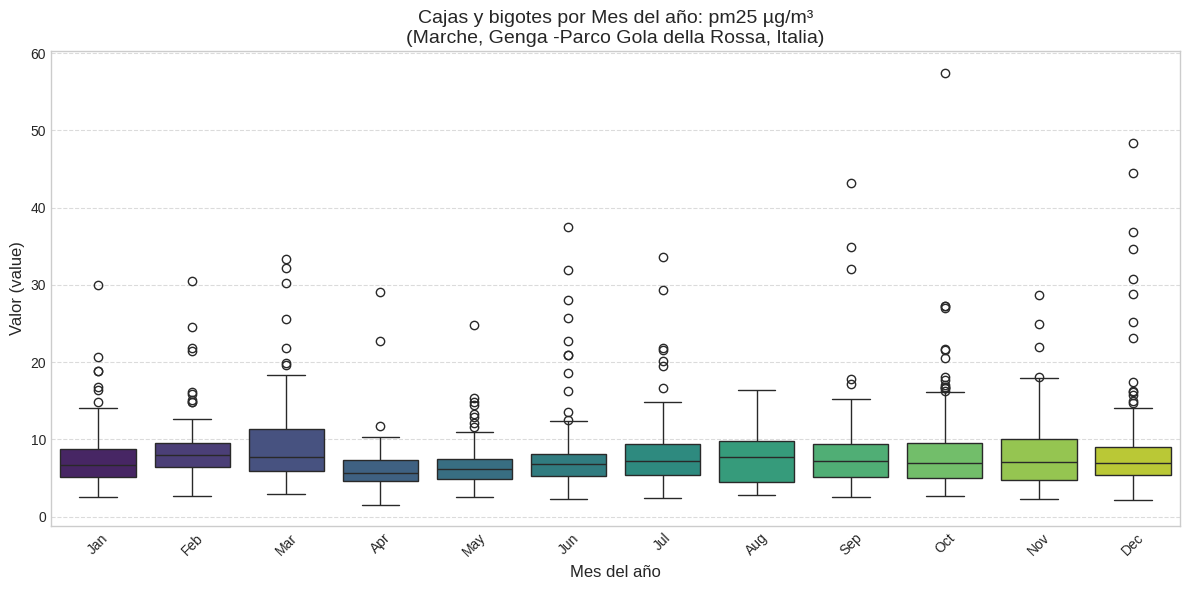


--- Processing: pm25 µg/m³ at Madrid, Villa del Prado, España ---


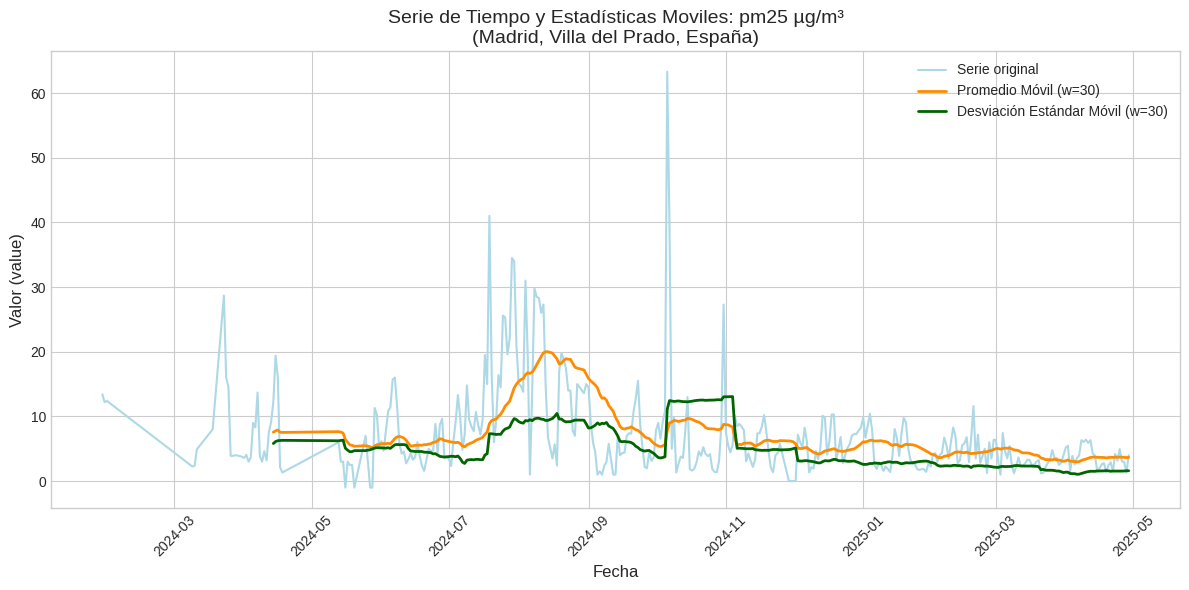

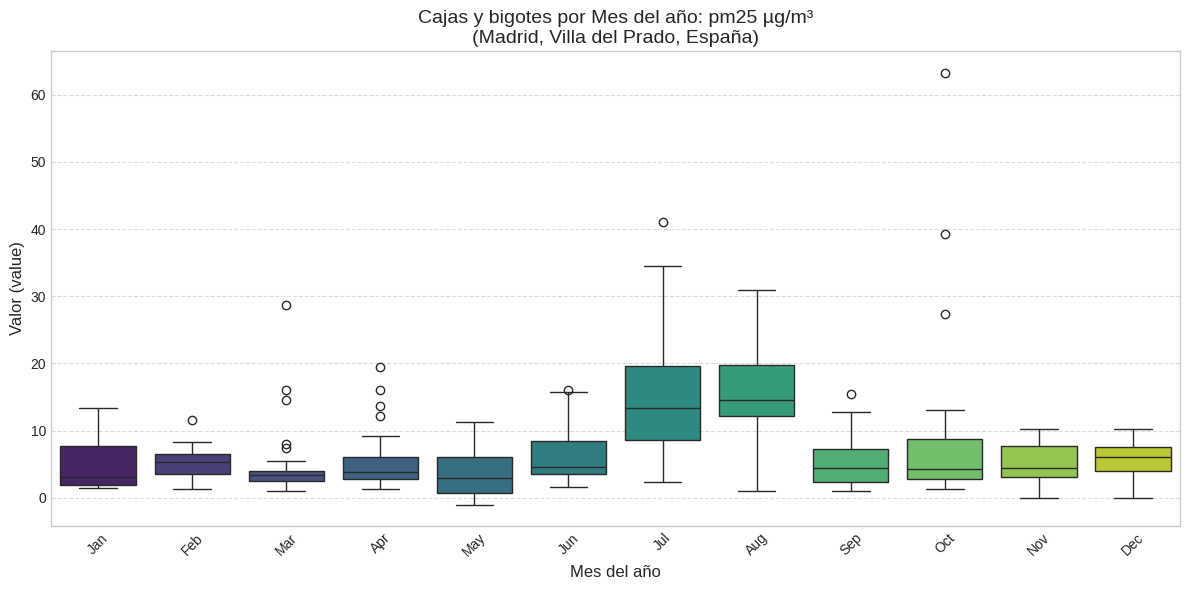


--- Processing: pm25 µg/m³ at Mahape, Navi Mumbai, India ---


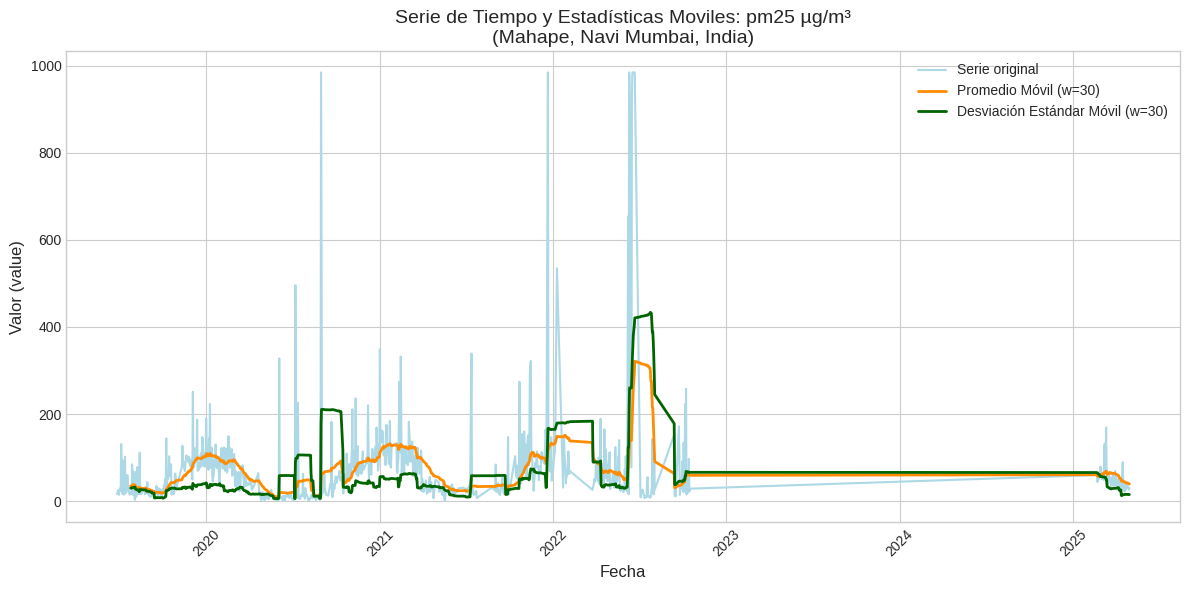

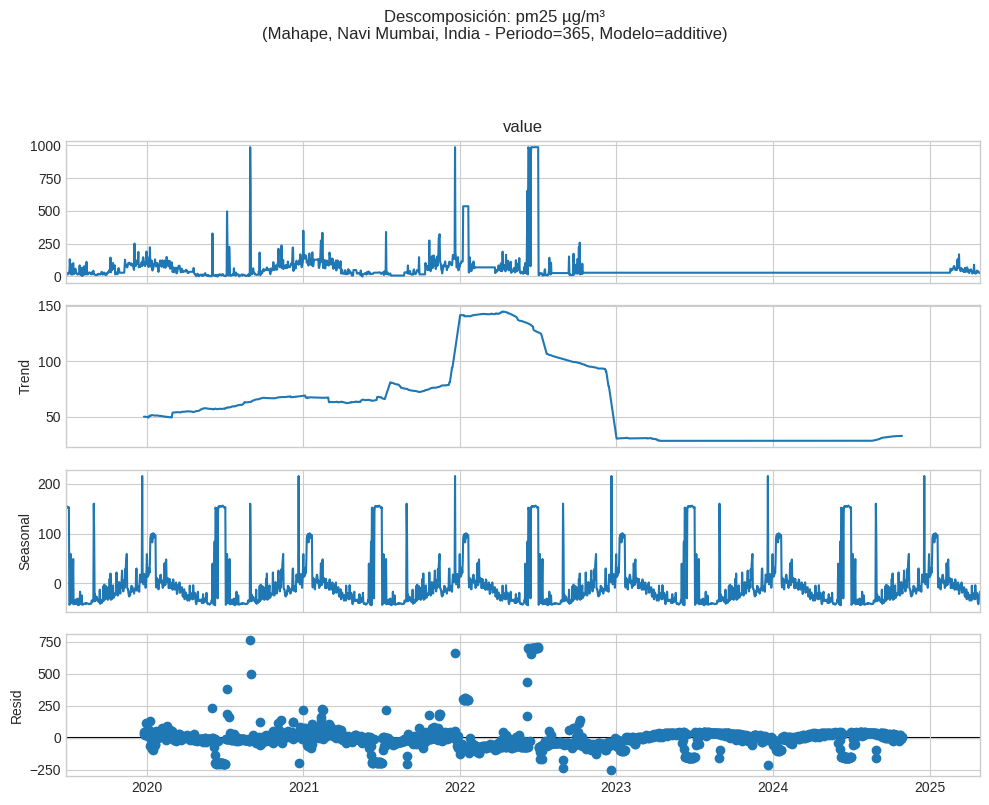

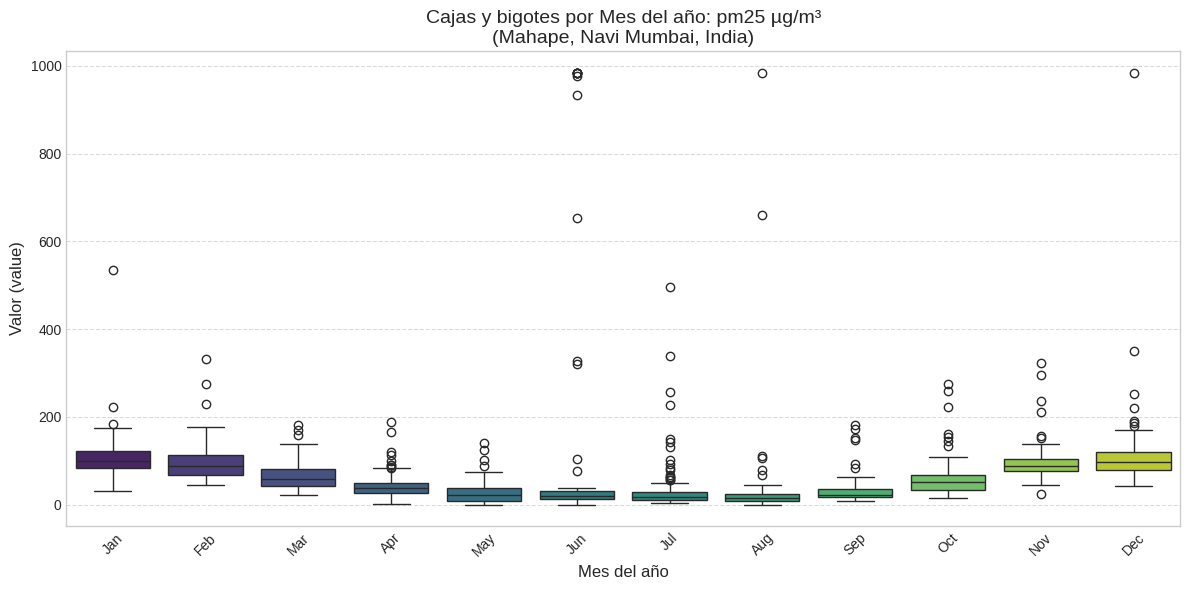


--- Processing: pm25 µg/m³ at Ayacucho, Pariachi, Perú ---


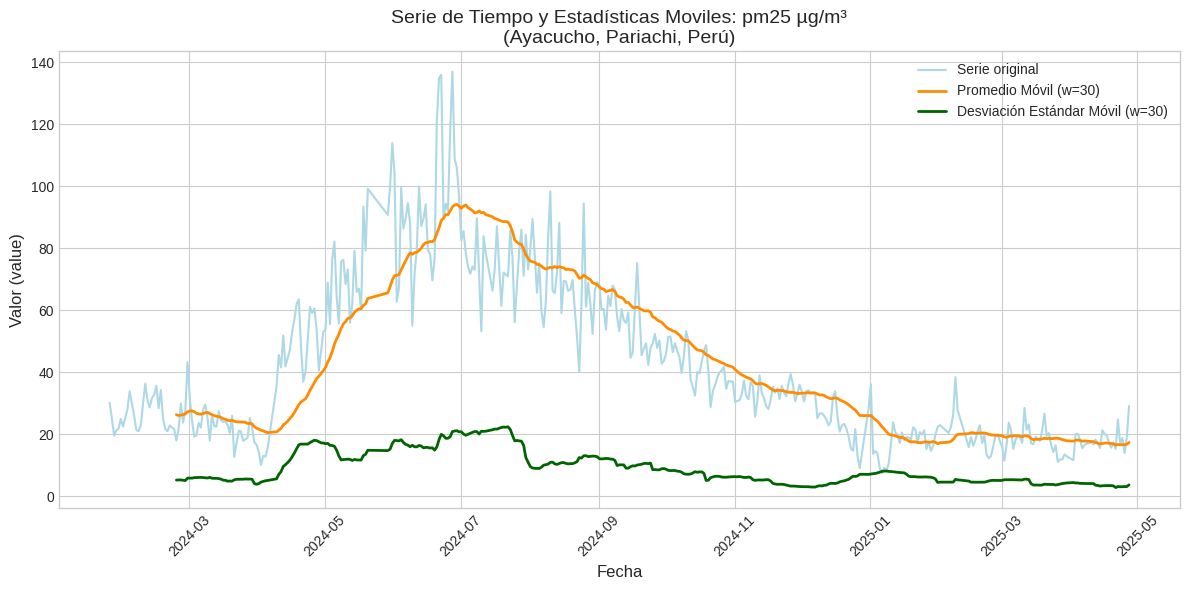

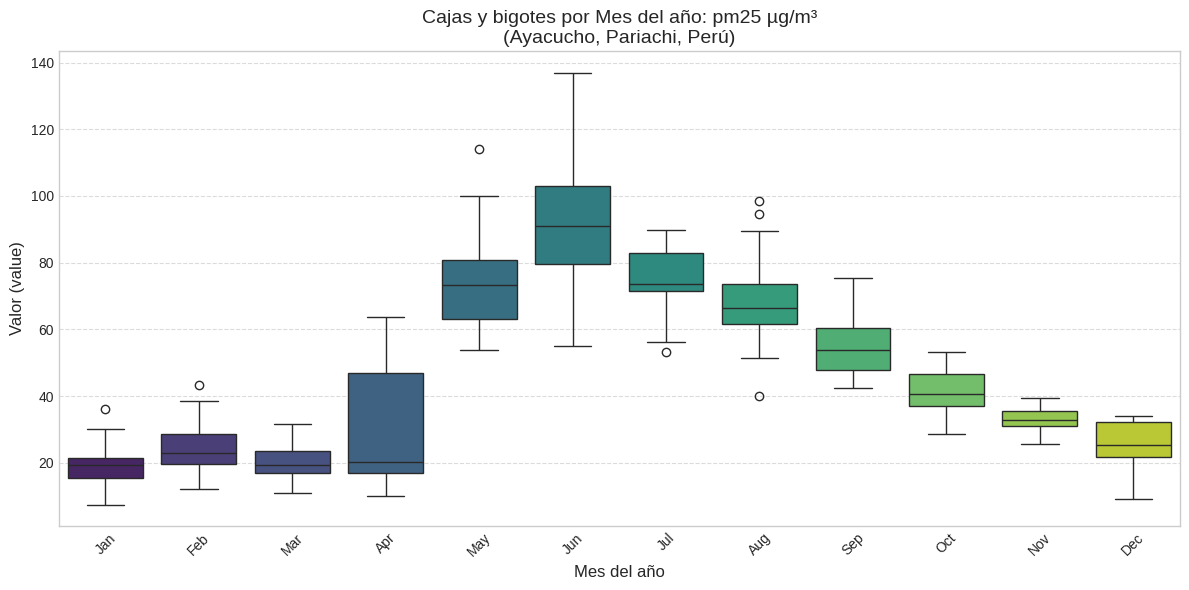


===== Finished All Locations for Parameter: pm25 µg/m³ =====

===== 1 - Visual Analysis for Parameter: co µg/m³ =====

--- Processing: co µg/m³ at San José, San Pedro, Montes de Oca, Costa Rica ---

--- Processing: co µg/m³ at Hong Kong, North, China ---


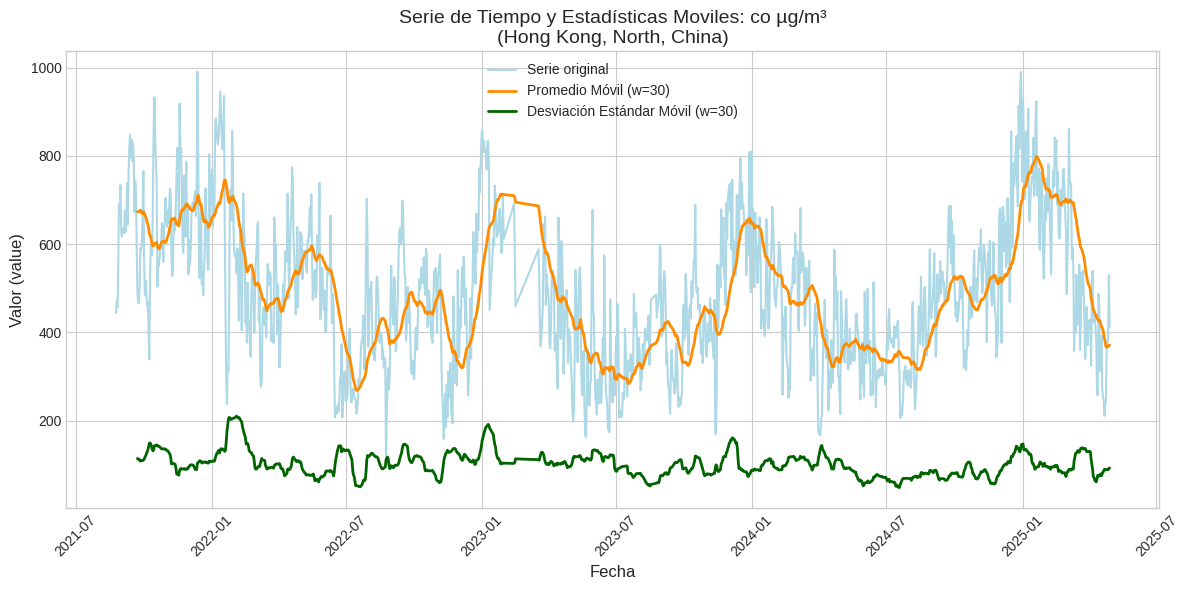

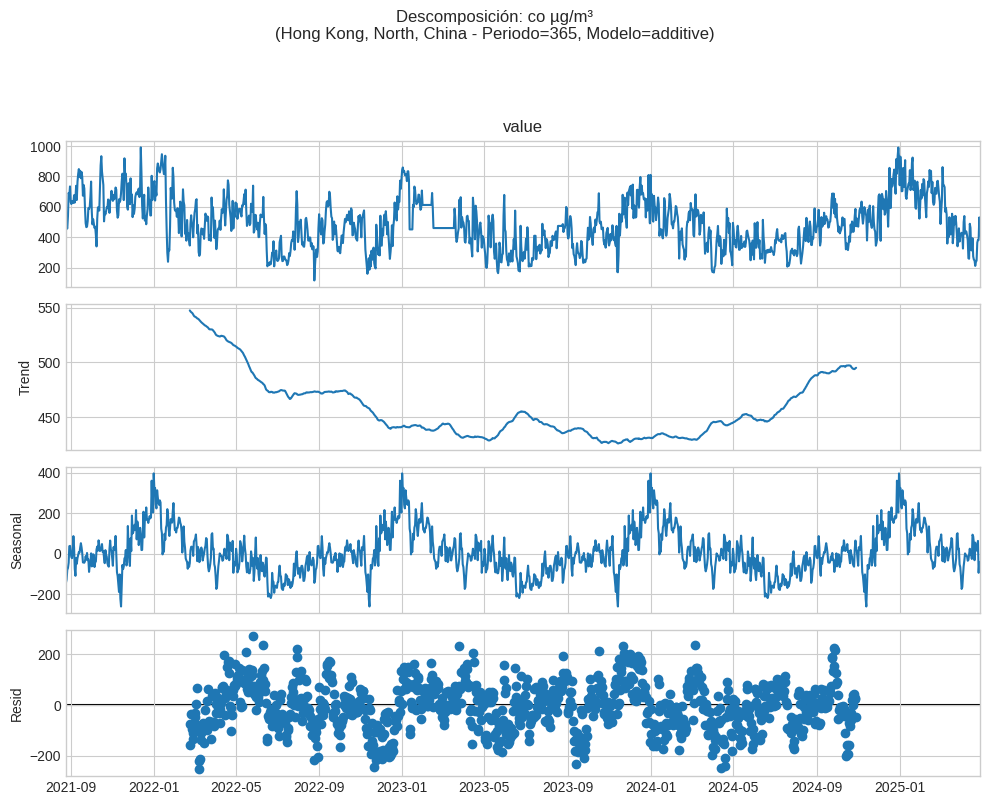

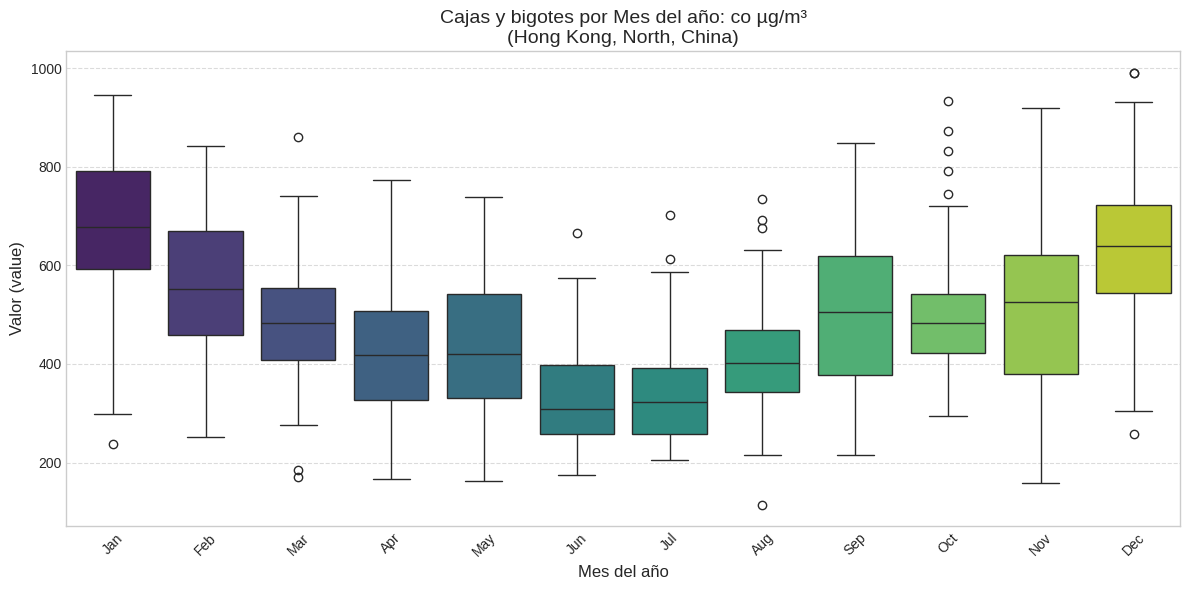


--- Processing: co µg/m³ at Marche, Genga -Parco Gola della Rossa, Italia ---


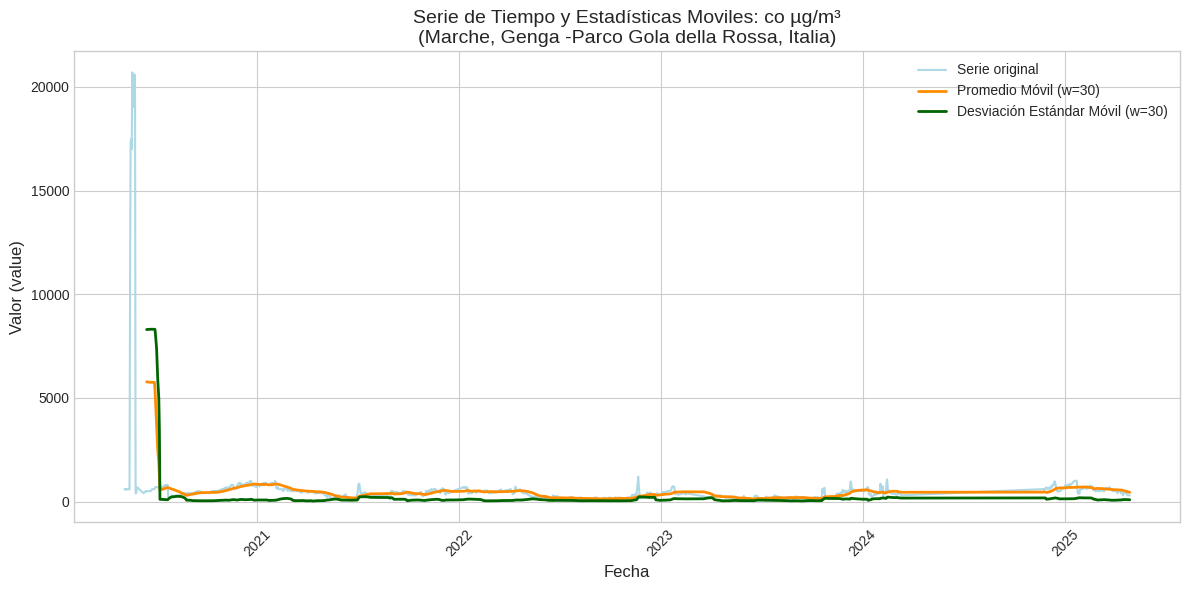

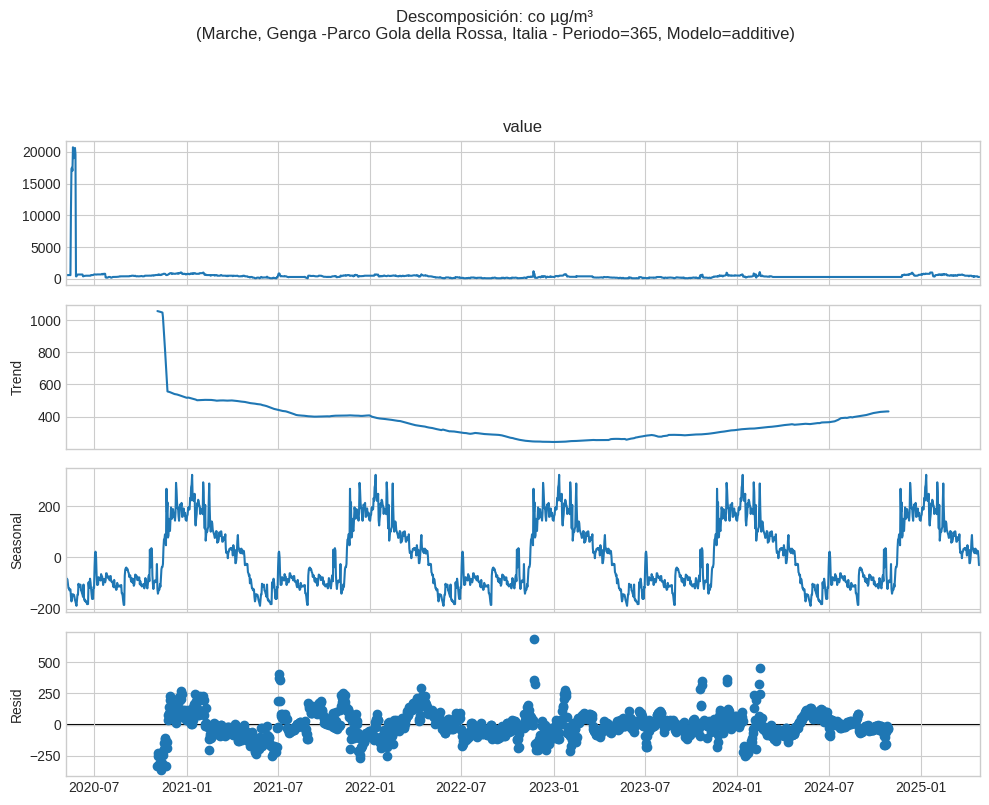

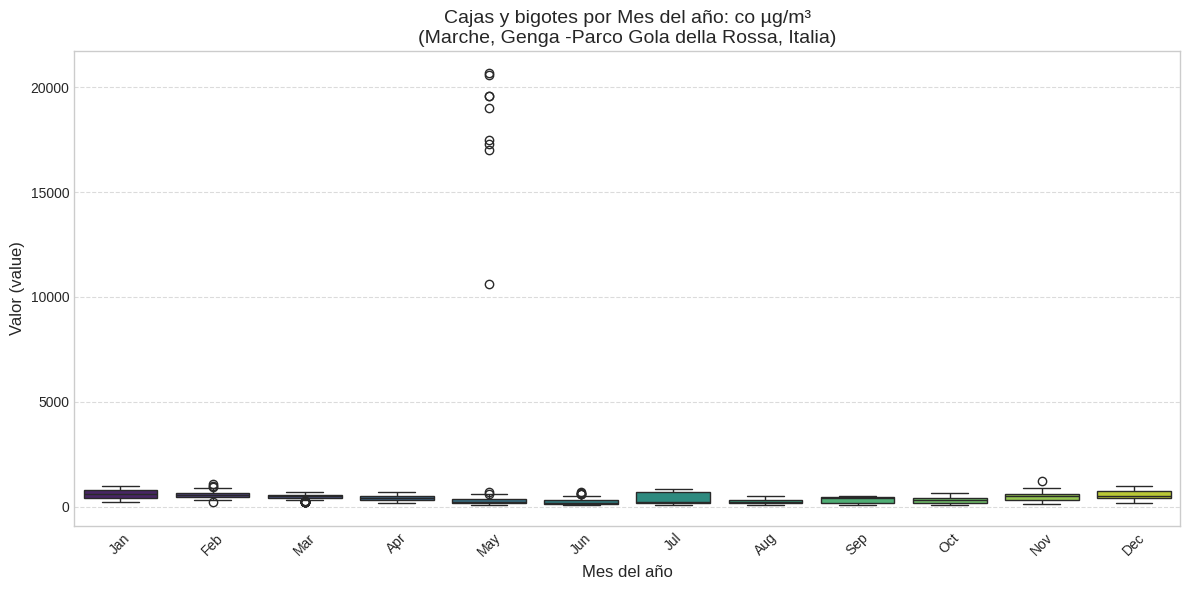


--- Processing: co µg/m³ at Madrid, Villa del Prado, España ---


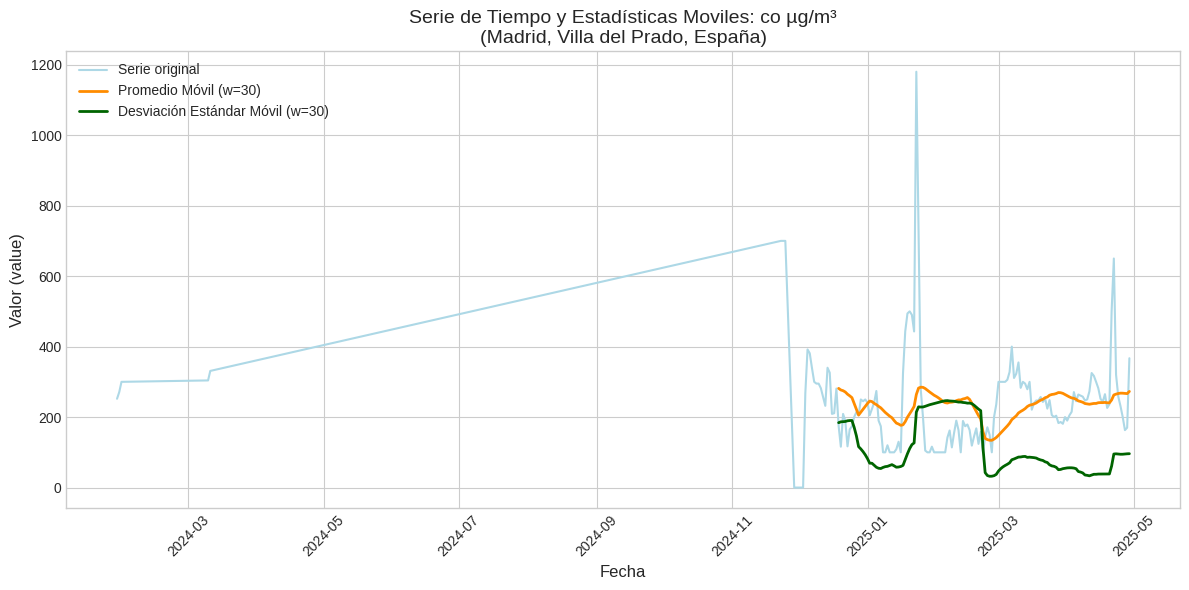

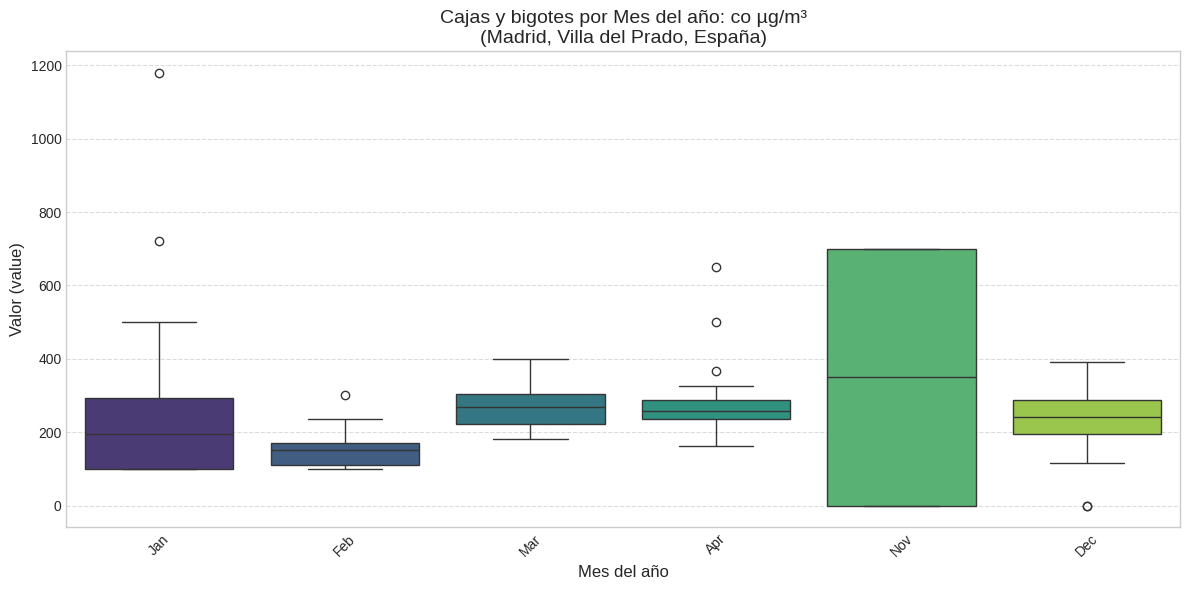


--- Processing: co µg/m³ at Mahape, Navi Mumbai, India ---


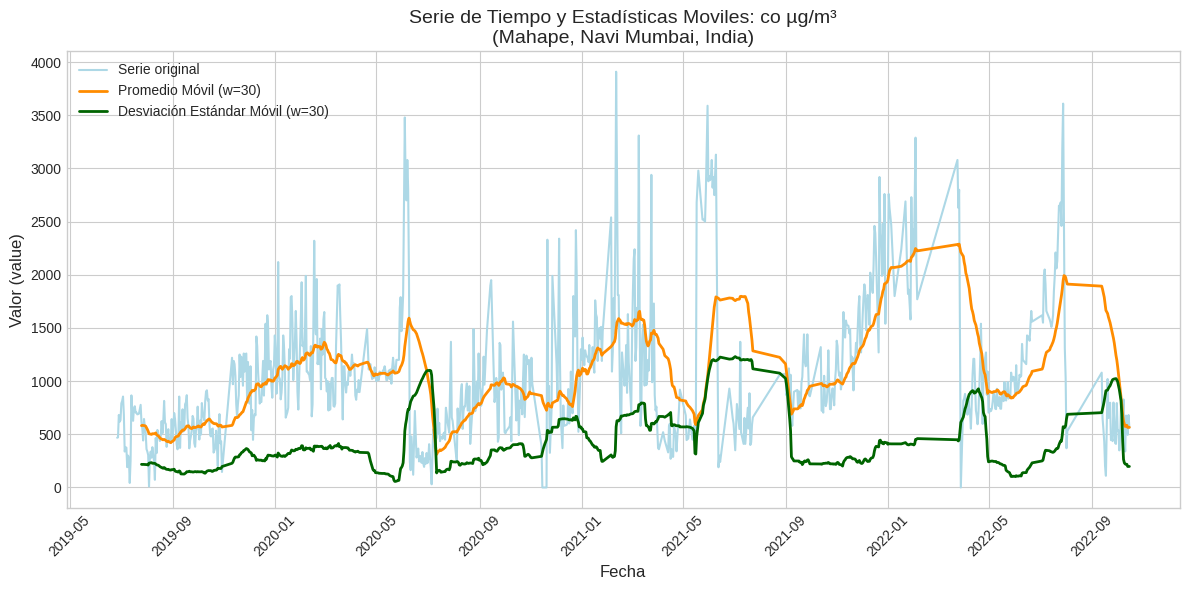

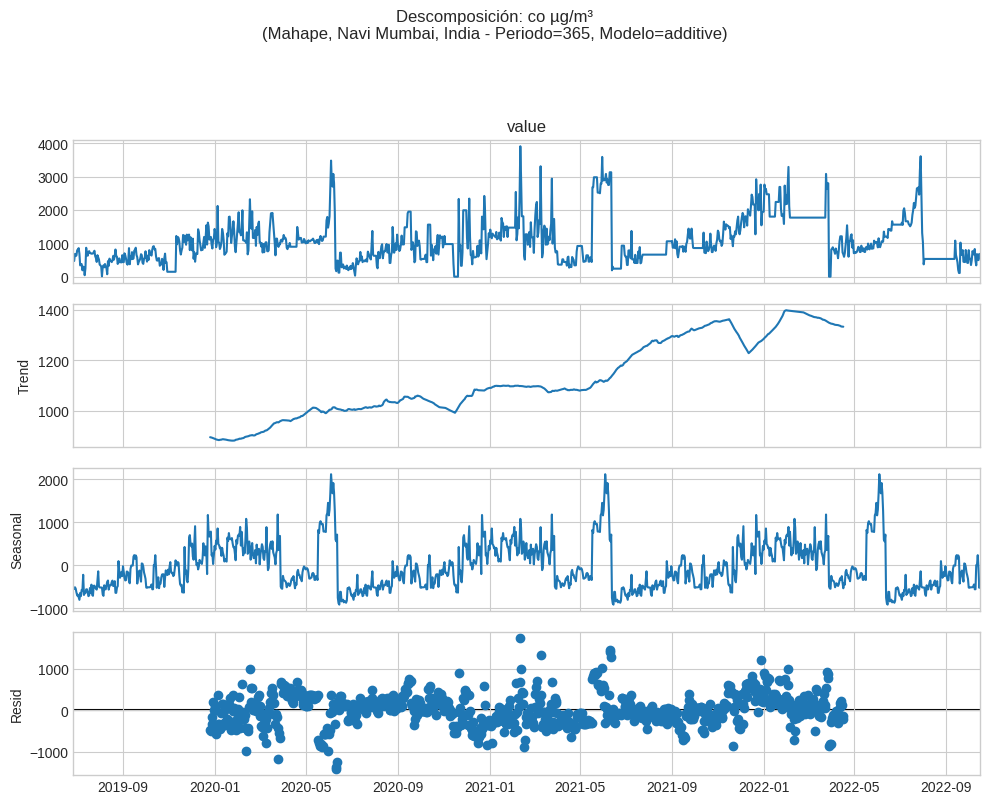

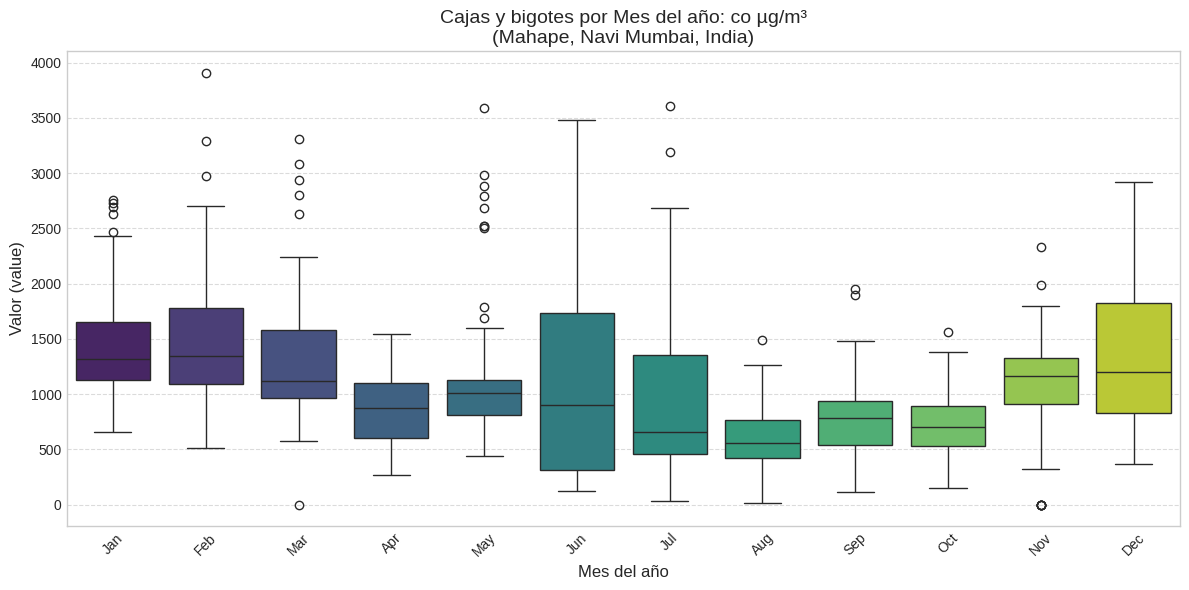


--- Processing: co µg/m³ at Ayacucho, Pariachi, Perú ---


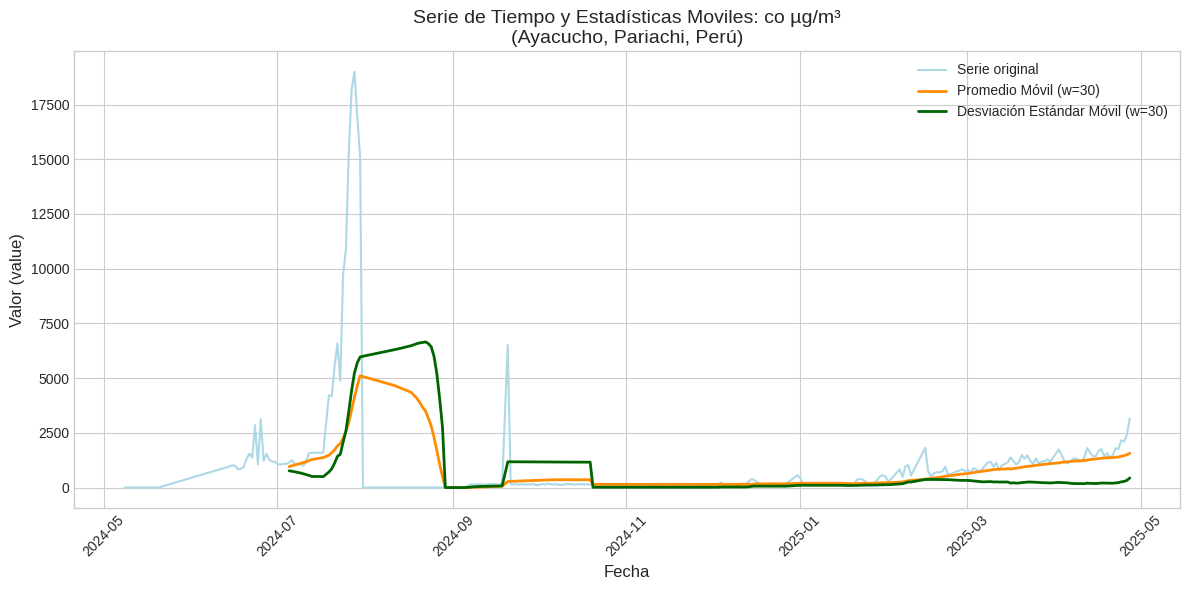

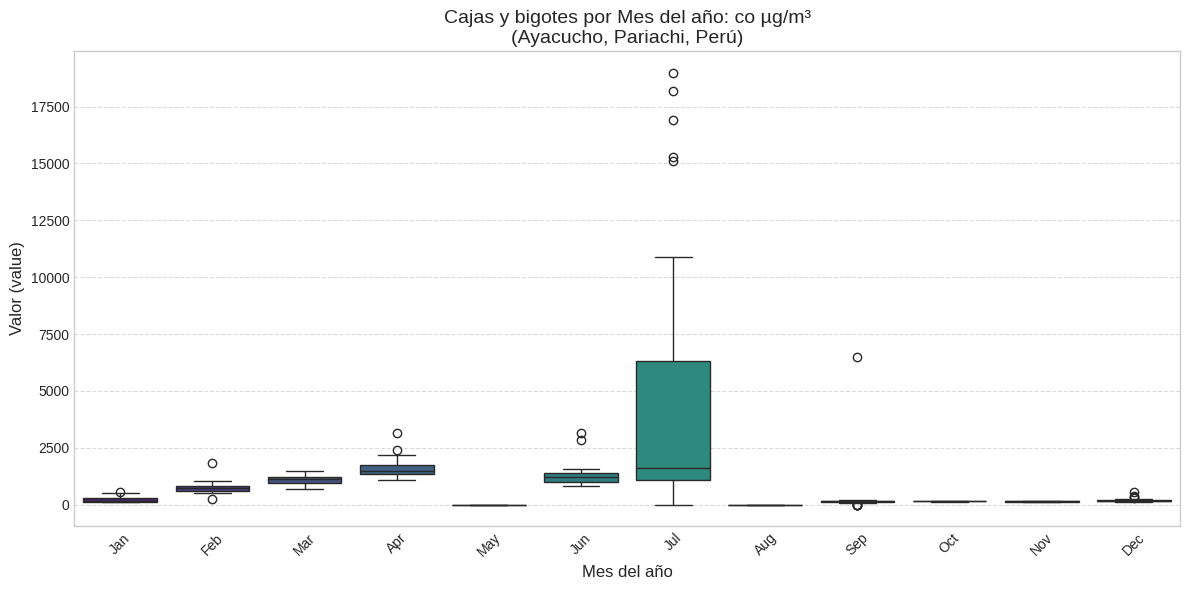


===== Finished All Locations for Parameter: co µg/m³ =====


In [ ]:
ANNUAL_PERIOD = 365
PRIMARY_SEASONAL_PERIOD = ANNUAL_PERIOD

parameters_mini = [parameters[0], parameters[1]]
print("--- Starting Visual Time Series Analysis ---")

for i, param_name in enumerate(parameters_mini):
    print(f"\n===== {i} - Visual Analysis for Parameter: {param_name} =====")

    for location_index, location_df in enumerate(locations_dfs):
        # Basic check for valid DataFrame
        if not isinstance(location_df, pd.DataFrame) or location_df.empty:
            # Log or print this warning if needed, but prepare_time_series_data handles it
            # print(f"INFO: Skipping location index {location_index} for {param_name}: Invalid/empty DataFrame.")
            continue

        # Extract Location Info Safely
        country = "Unknown Country"
        location_name = f"Unknown Location (Index {location_index})"
        location_key = f"{location_name}, {country}"  # Default key
        try:
            if (
                "country_name" in location_df.columns
                and not location_df["country_name"].empty
            ):
                country = location_df["country_name"].iloc[0]
            if (
                "location_name" in location_df.columns
                and not location_df["location_name"].empty
            ):
                location_name = location_df["location_name"].iloc[0]
            location_key = f"{location_name}, {country}"  # Use extracted names
        except Exception as e:
            # Log this error if it happens, but proceed with defaults
            logging.warning(
                f"Could not extract location info for index {location_index}. Using defaults. Error: {e}"
            )

        # Announce processing start for this combo
        print(f"\n--- Processing: {param_name} at {location_key} ---")

        # --- Call Refactored Stationarity Plotting Function ---
        # Errors are logged within the function/helpers, loop continues
        plot_stationarity_diagnostics_refactored(
            df=location_df,
            parameter_name=param_name,
            country_name=country,
            location_name=location_name,
        )

        # --- Call Refactored Seasonality Plotting Function ---
        # Errors are logged within the function/helpers, loop continues
        plot_seasonality_diagnostics_refactored(
            df=location_df,
            parameter_name=param_name,
            seasonal_period=PRIMARY_SEASONAL_PERIOD,
            country_name=country,
            location_name=location_name,
        )

        # No need for explicit "Finished plots" print here, as the start of the next block indicates progress

    print(f"\n===== Finished All Locations for Parameter: {param_name} =====")


Analizando el comportamiento de las tendencias para el indicador compartido entre todas las ciudades, **es decir el pm25**, que en general las tendencias más interesantes son las de Perú y las Hongkong. Hongkong muestra una tendencia creciente lo que nos indica que con el paso del tiempo, lo que indica que la calidad del aire ha ido empeorando en esta métrica. Por otro lado, Perú muestra una tendencia decreciente, lo que indica que la calidad del aire ha ido mejorando en esta métrica desde julio de 2024 cuando empezó a decrecer la tendencia después de un gran pico. Esto puede ser un indicativo de que las políticas de calidad del aire en Perú han tenido un impacto positivo en la calidad del aire.


Así mismo Italia tiene una tendencia similar a Perú, en el sentido de que alrededor de 2023 se puede observar un gran pico y un progresivo decrecimiento de la tendencia.


Con respecto a la estacionalidad, el caso de Italia es interesante pues muestra un comportamiento de picos cada vez que se acerca entre julio y diciembre de cada año. De manera similar para el caso de Mumbai a mitad de año.

Con respecto al indicador **co** la tendencia de Mumbai es muy creciente, lo que indica que con respecto a esta métrica la calidad del aire se ha deteriorado. Así mismo, de manera similar a lo que se observó con el indicador de pm25, su estacionalidad muestra picos a mitad del año. Resulta interesante resaltar que de los países para los cuales tenemos suficientes datos para hacer el gráfico de descomposición sobre el indicador de **co** solo los datos de Mumbai muestran una tendencia creciente así de marcada.

### Correlaciones

Ahora, podemos observar las correlaciones que hay entre cada parámetro. Para ello, primero vamos a crear un dataframe que permita hacer análisis según las columnas: esto es hacer una fila por cada día medido en cada país, y los correspondientes valores para cada parámetro.

In [ ]:
merged_df = all_dfs.copy()
merged_df["from_date"] = pd.to_datetime(merged_df["from_date"])

# Pivot the table to place every parameter as a column and each row as a date
df_pivot = merged_df.pivot_table(
    index=["country_name", "from_date"], columns="parameter_name", values="value"
).reset_index()

# Remove the index name
df_pivot.columns.name = None
df_pivot.head()

country_name                 from_date  co µg/m³  no2 µg/m³  o3 µg/m³  \
0        China 2021-08-24 16:00:00+00:00     444.0       30.4      18.4   
1        China 2021-08-25 16:00:00+00:00     470.0       21.8      26.2   
2        China 2021-08-26 16:00:00+00:00     457.0       30.1      16.0   
3        China 2021-08-27 16:00:00+00:00     539.0       31.5      20.2   
4        China 2021-08-28 16:00:00+00:00     691.0       25.8      35.0   

   pm10 µg/m³  pm25 µg/m³  so2 µg/m³  
0        8.54        5.32      15.30  
1        6.89        4.32      13.50  
2       10.50        6.55       1.33  
3       15.10        7.83       2.95  
4       12.60        7.21       4.86

#### Análisis de correlación

Vamos a analizar si es que existe alguna correlación entre los parámetros existentes.

Para el análisis de la correlación con el coeficiente de Pearson, se deben cumplir los siguientes supuestos:

1. Normalidad de los datos.
2. Muestras aleatoriedad.
3. Datos sin outliers.
4. Que ambas variables estén en mismo intervalo de medida.

Para la normalidad vamos a hacer qqplots.

In [ ]:
parameters_without_outliers = []

# Remove outliers
for parameter in different_parameters:
    Q1 = df_pivot[parameter].quantile(0.25)
    Q3 = df_pivot[parameter].quantile(0.75)
    IQR = Q3 - Q1

    parameters_without_outliers.append(
        list(
            df_pivot.loc[
                (df_pivot[parameter] > (Q1 - 1.5 * IQR))
                & (df_pivot[parameter] < (Q3 + 1.5 * IQR))
            ]
        )
    )


print(parameters_without_outliers)

[['country_name', 'from_date', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³', 'pm25 µg/m³', 'so2 µg/m³'], ['country_name', 'from_date', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³', 'pm25 µg/m³', 'so2 µg/m³'], ['country_name', 'from_date', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³', 'pm25 µg/m³', 'so2 µg/m³'], ['country_name', 'from_date', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³', 'pm25 µg/m³', 'so2 µg/m³'], ['country_name', 'from_date', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³', 'pm25 µg/m³', 'so2 µg/m³'], ['country_name', 'from_date', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³', 'pm25 µg/m³', 'so2 µg/m³']]


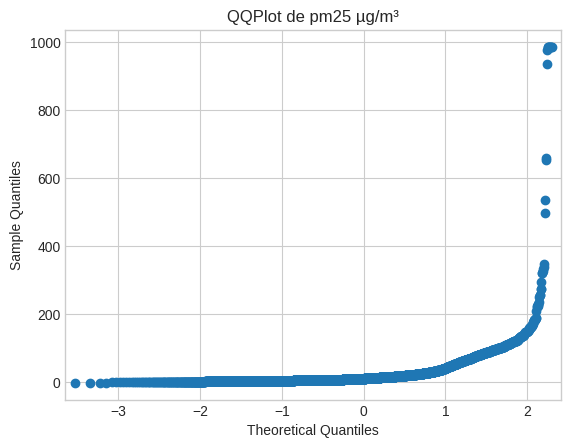

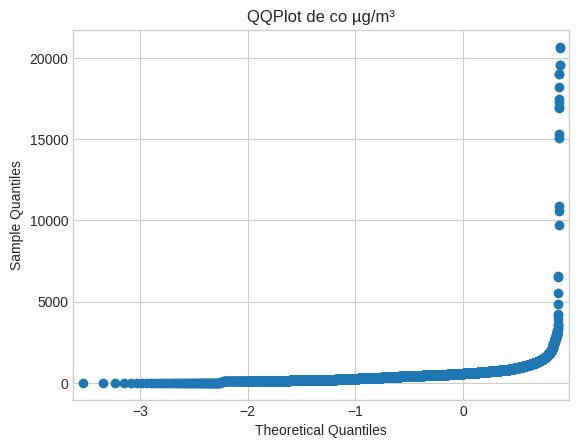

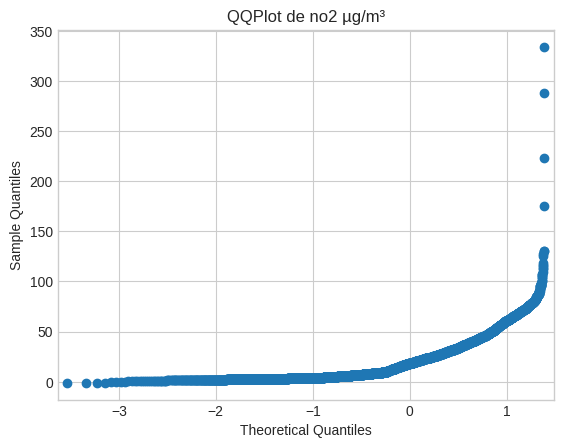

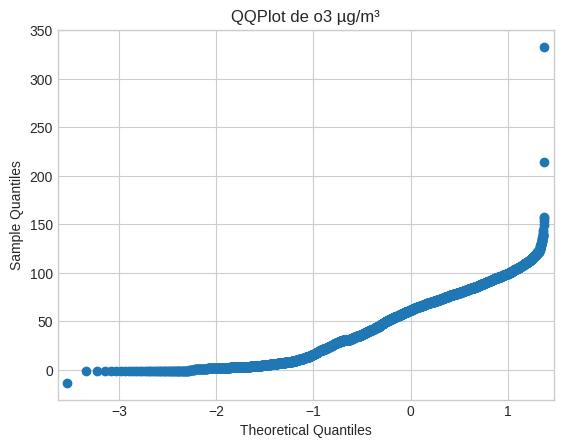

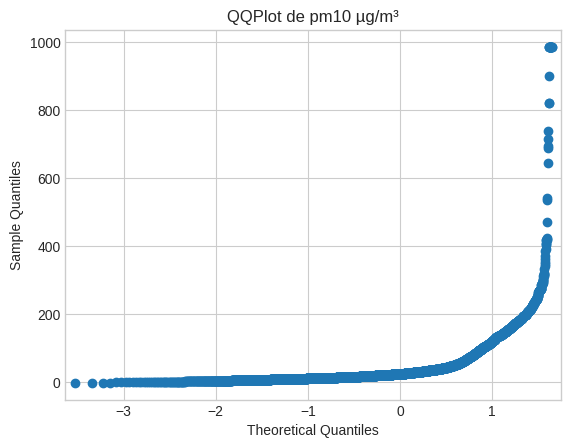

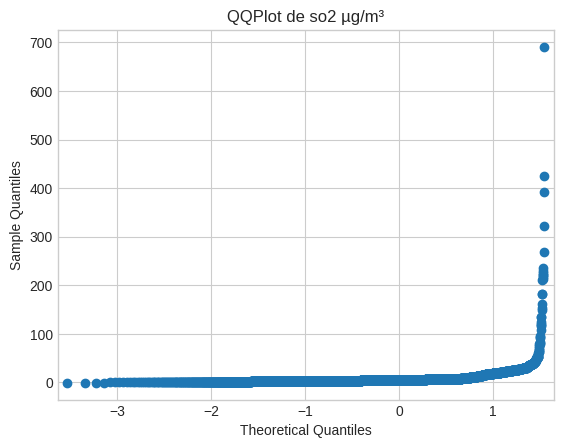

In [ ]:
for parameter in different_parameters:
    sm.qqplot(df_pivot[parameter], line="s")
    plt.title(f"QQPlot de {parameter}")
    plt.show()

In [ ]:
correlation_df = df_pivot[
    list(set(list(df_pivot.columns)) - {"country_name", "from_date"})
].corr()
correlation_df

pm10 µg/m³  co µg/m³  no2 µg/m³  o3 µg/m³  pm25 µg/m³  so2 µg/m³
pm10 µg/m³    1.000000  0.198551   0.358395 -0.255877    0.622115   0.366105
co µg/m³      0.198551  1.000000   0.130528 -0.117499    0.144510   0.113415
no2 µg/m³     0.358395  0.130528   1.000000 -0.355419    0.277252   0.136125
o3 µg/m³     -0.255877 -0.117499  -0.355419  1.000000   -0.203233  -0.196706
pm25 µg/m³    0.622115  0.144510   0.277252 -0.203233    1.000000   0.250961
so2 µg/m³     0.366105  0.113415   0.136125 -0.196706    0.250961   1.000000

A partir de la tabla, es visible que las correlaciones son bajas en general, y no parece haber ninguna notable. Sin embargo, la que tiene un valor más alto es pm10 con pm25, lo cual tiene sentido, pues son de una misma familia de contaminantes (es esperable que se comporten similar). Ahora, visto en un heatmap (con valor absoluto para resaltar también correlaciones negativas):

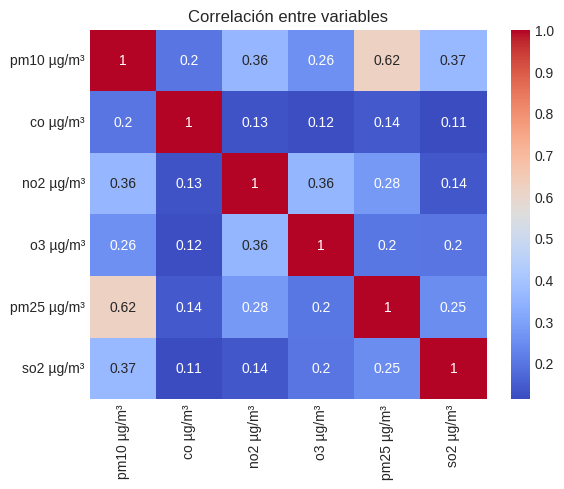

In [ ]:
plt.title("Correlación entre variables")
sns.heatmap(
    correlation_df.abs(),
    annot=True,
    cmap="coolwarm",
)
plt.show()

Visualmente da la misma impresión que con la tabla: solo pm10 y pm25 tienen una correlación. Para ver el tipo de interacción que tienen, podemos hacer un pairplot entre cada parámetro.

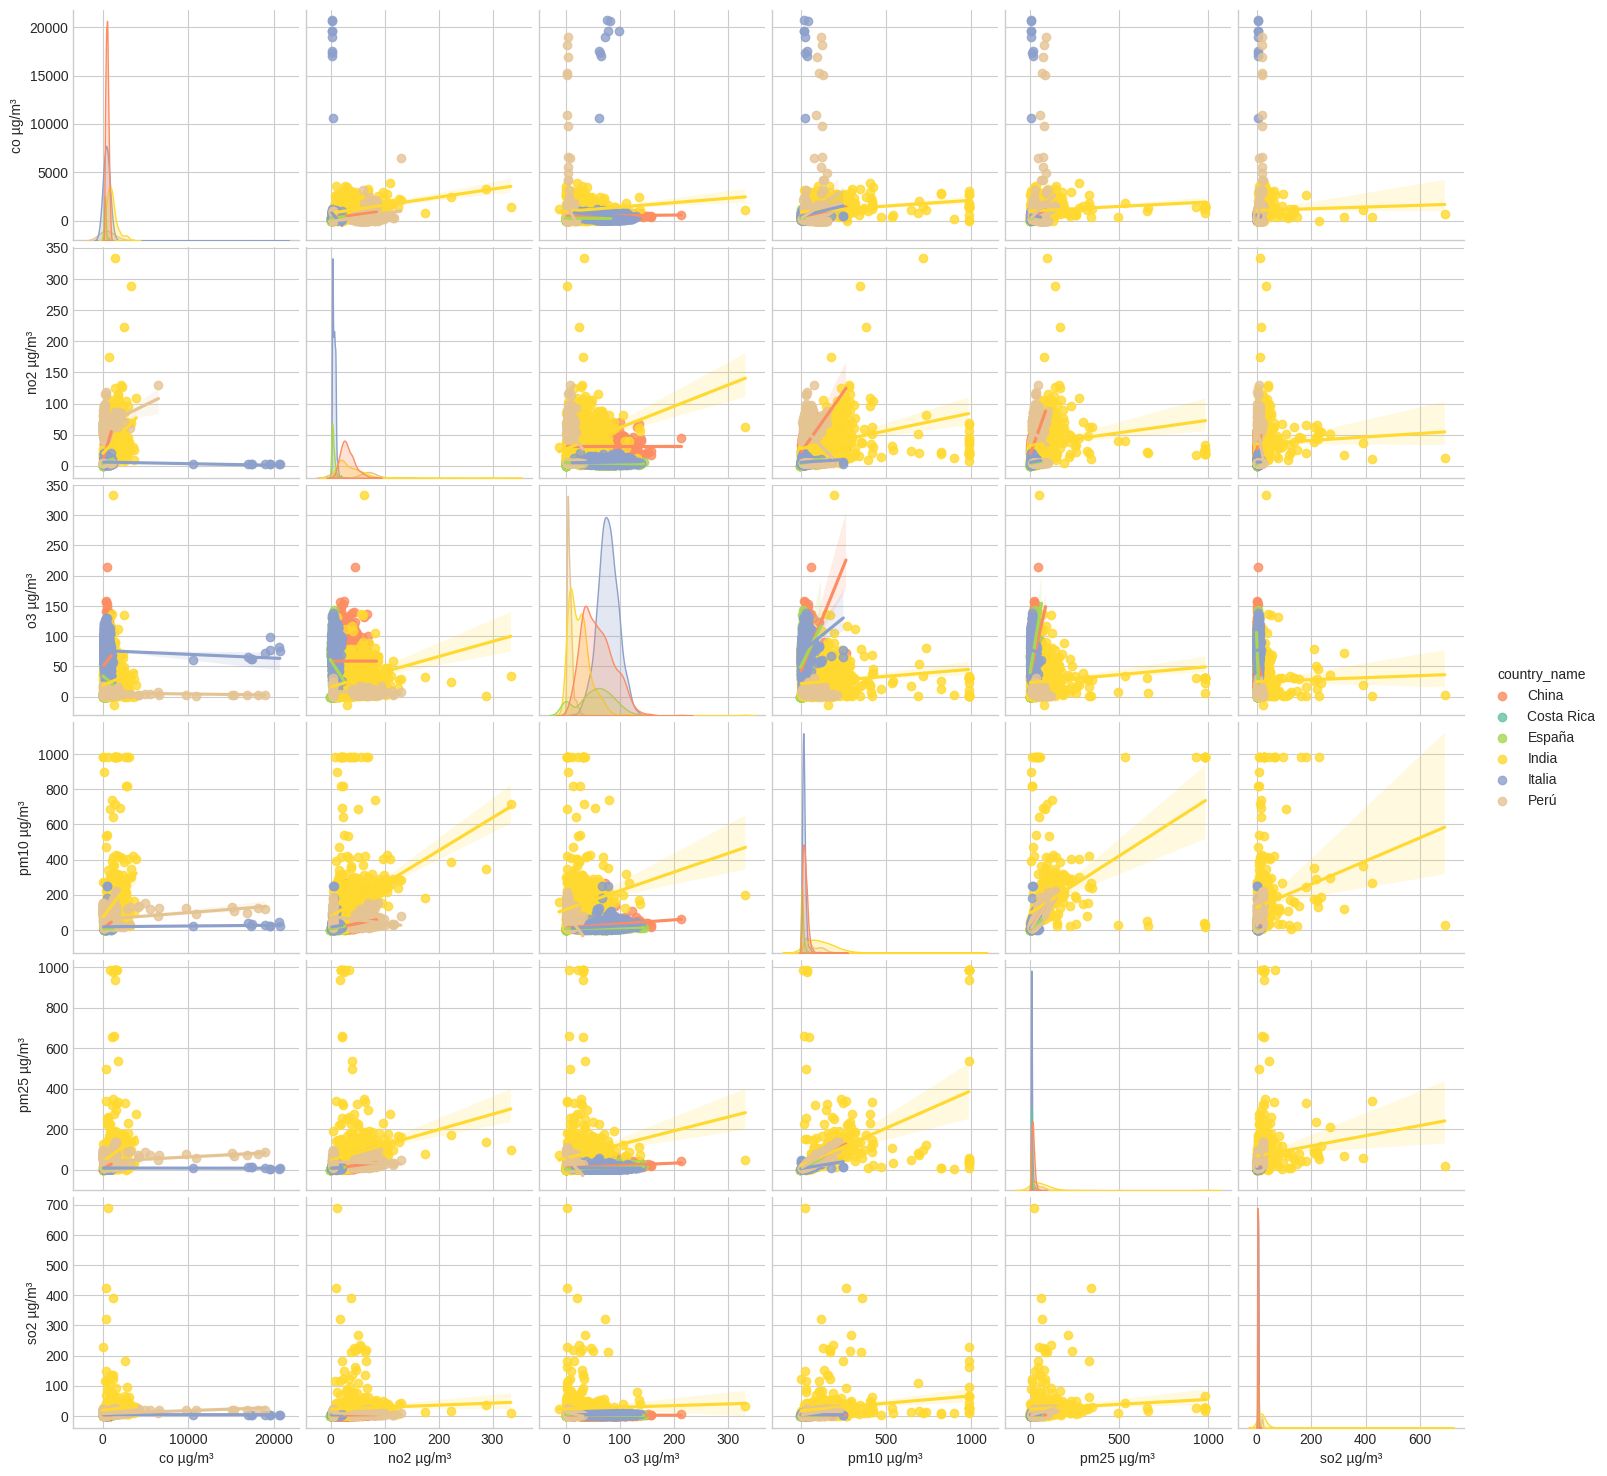

In [ ]:
sns.pairplot(df_pivot, hue="country_name", palette=locations_color_map, kind="reg")

El gráfico muestra que hay una correlación positiva entre las variables de pm25 y pm10. Cuando una crece, la otra igual. No es muy fuerte, pero es la más notable.


# 5. Conclusiones y Recomendaciones:

Extraer conclusiones sobre la evolución de la calidad del aire en Costa Rica y las ciudades seleccionadas, explicando cómo los datos sustentan estas conclusiones.

Buscar información sobre las políticas ambientales y regulaciones en estas ciudades y mostrar cómo los datos reflejan el efecto de estas políticas.



Actualmente en Italia y en España se está siguiendo la directiva 2008/50/EC. Esta directiva se refiere a la calidad del aire ambiente y a una atmósfera más limpia en Europa. Esto confirma los supuestos realizados en el análisis de los boxplots univariables sobre la similitud en la distribución de los datos en estos paises.

En el caso de Costa Rica, el Reglamento de calidad del aire para contaminantes estipula que el promedio diario de contaminantes PM25 no puede superar las 35 micras por metro cúbico. En esta área Costa Rica se encuentra muy bien posicionado ya que los valores diarios están muy por debajo de lo que estípula la norma.

Con Respecto al CO Mumbai y Perú no tienen regulaciones. Mientras que en Italia y Hong Kong se menciona el CO como contaminante pero no se especifican medidas o valores máximos. En el caso de España si se estipula un límite de 10 micras, lo cual si se cumple.

De igual forma con el NO2, los países que tienen regulaciones son España, Perú y Costa Rica. Costa Rica no reporta este contaminante, sin embargo España y Perú cumplen con los límites de cada país. Es importante notar que aunque en Perú no se llega al límite, hay mucho espacio para mejorar. Mientras que paises como España tienen medianas de 5 micras, Perú tiene una mediana de más de 20 micras.

El caso del O3 es muy diferente a los otros casos, para este contaminante las regulaciones estipulan que no se puede superar las 180 micras, sin embargo al ver los gráficos se nota que aún en países con valores muy buenos en los otros contaminantes como lo es España, para el caso del O3 si se acercan mucho al límite, y en varios páises se supera este límite.

Para las partículas PM10 es difícil obtener conclusiones de los datos analizados, ya que solo Madrid tiene regulaciones sobre estas partículas. Por ello, no se pueden extraer conclusiones sólidas a nivel comparativo.

Finalmente para el SO2 los países que tienen regulaciones estipulan el límite superior de partículas alrededor 200 y 250 micras diarias. Aún en los casos con una cantidad muy alta de partículas no se suele superar este umbral.

Si bien al comparar los valores obtenidos de zonas sin regulaciones con las regulaciones de otras zonas no se observan muchos registros que superen los límites en esas regulaciones, si existe una diferencia muy significativa entre los datos reportados. Esto parece indicar que la existencia de regulacion influye significativamente los esfuerzos por reducir estas emiciones.

De igual forma según el Plan de Calidad de Aire de Madrid 2019 la mayor parte de la emisiones de partículas PM2.5 se deriva del transporte en carretera. Esto quiere decir que además de las regulaciones para el control de la calidad del aire, si estas se combinan con mejores políticas en los permisos de circulación de los autos y mejores políticas en transporte público para reducir la cantidad de vehículos en las carreteras puede mejorar significativamente la calidad del aire.

Otro punto a tomar en cuenta es las estaciones del año. En varios de los países se vio que tienen picos de contaminación con ciertos parámetros a partir de las fechas de medio año hasta diciembre. Esto es un llamado a que se estudie el porqué se está generando más contaminación en estas fechas. Esto podría estar relacionado a muchos factores, entre ellos las fechas de vacaciones en ciertos lugares, los picos de producción industrial (algunas industrias intensifican sus labores en el segundo trimestre), muchos eventos masivos de verano, condiciones secas que limitan la dispersión de particular contamimnantes, etc.

Es así que algunas de la recomendaciones que podemos extraer son:
1.	Fortalecer la implementación de normativas de calidad del aire en países que aún carecen de ellas, especialmente para contaminantes como CO y NO₂. Muchos países aún no cuentan con límites claros o actualizados para contaminantes clave como el CO, NO₂ o PM10. Establecer regulaciones específicas y armonizadas con estándares internacionales, como los propuestos por la Organización Mundial de la Salud (OMS) o la Unión Europea sería una gran ayuda a reducir los niveles de ciertos contaminantes.

2.	Complementar las regulaciones ambientales con políticas de movilidad sostenible, priorizando transporte público eficiente y regulaciones sobre vehículos privados. Se puede restringir el uso de vehículos altamente contaminantes o incluso implementar zonas de bajas emisiones y ciclovías seguras para reducir la dependencia del vehículo particular.

3.	Establecer sistemas de monitoreo más integrales, especialmente en países con pocos datos reportados, para mejorar el diagnóstico y control. Para ello se puede ampliar la cobertura geográfica de estaciones de medición, incluyendo zonas rurales y suburbanas, y asegurarse de contribuir con estos datos a plataformas como OpenAQ, que permiten que distintas personas de todo el mundo observen y analicen el estado actual de los contaminantes en muchos países.

4.	Realizar estudios específicos sobre estacionalidad de la contaminación, para anticipar medidas preventivas en los meses con mayor riesgo. Esto implica realizar estudios meteorológicos y de comportamiento socioeconómico para entender las causas específicas del aumento estacional, y con ello establecer planes de contingencia temporales, como restricciones vehiculares, en los meses con mayor contaminación.